# Universidade Federal do Ceará
### Residência em Segurança da Informação


                                Equipe: Lorena da Silva Medeiros (543039)
                                        Lucelia Lima Souza (543024)
                                        Nathalia Cavalcanti Martins (543029)
                                        
                                        
### Projeto de ML com a base IoT-23

##### Preparação inicial do ambiente

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import shap

In [2]:
filepath = 'base.csv'
df_c = pd.read_csv(filepath, low_memory=False)

In [3]:
df_c.loc[(df_c.label == '-   Malicious   PartOfAHorizontalPortScan'), 'label'] = 'PartOfAHorizontalPortScan'
df_c.loc[(df_c.label == '(empty)   Malicious   PartOfAHorizontalPortScan'), 'label'] = 'PartOfAHorizontalPortScan'
df_c.loc[(df_c.label == '-   Malicious   Okiru'), 'label'] = 'Okiru'
df_c.loc[(df_c.label == '(empty)   Malicious   Okiru'), 'label'] = 'Okiru'
df_c.loc[(df_c.label == '-   Benign   -'), 'label'] = 'Benign'
df_c.loc[(df_c.label == '(empty)   Benign   -'), 'label'] = 'Benign'
df_c.loc[(df_c.label == '-   Malicious   DDoS'), 'label'] = 'DDoS'
df_c.loc[(df_c.label == '-   Malicious   C&C'), 'label'] = 'C&C'
df_c.loc[(df_c.label == '(empty)   Malicious   C&C'), 'label'] = 'C&C'
df_c.loc[(df_c.label == '-   Malicious   Attack'), 'label'] = 'Attack'
df_c.loc[(df_c.label == '(empty)   Malicious   Attack'), 'label'] = 'Attack'
df_c.loc[(df_c.label == '-   Malicious   C&C-HeartBeat'), 'label'] = 'C&C-HeartBeat'
df_c.loc[(df_c.label == '(empty)   Malicious   C&C-HeartBeat'), 'label'] = 'C&C-HeartBeat'
df_c.loc[(df_c.label == '-   Malicious   C&C-FileDownload'), 'label'] = 'C&C-FileDownload'
df_c.loc[(df_c.label == '-   Malicious   C&C-Torii'), 'label'] = 'C&C-Torii'
df_c.loc[(df_c.label == '-   Malicious   C&C-HeartBeat-FileDownload'), 'label'] = 'C&C-HeartBeat-FileDownload'
df_c.loc[(df_c.label == '-   Malicious   FileDownload'), 'label'] = 'FileDownload'
df_c.loc[(df_c.label == '-   Malicious   C&C-Mirai'), 'label'] = 'C&C-Mirai'
df_c.loc[(df_c.label == '-   Malicious   Okiru-Attack'), 'label'] = 'Okiru-Attack'

In [4]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444674 entries, 0 to 1444673
Data columns (total 21 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   ts             1444674 non-null  float64
 1   uid            1444674 non-null  object 
 2   id.orig_h      1444674 non-null  object 
 3   id.orig_p      1444674 non-null  float64
 4   id.resp_h      1444674 non-null  object 
 5   id.resp_p      1444674 non-null  float64
 6   proto          1444674 non-null  object 
 7   service        1444674 non-null  object 
 8   duration       1444674 non-null  object 
 9   orig_bytes     1444674 non-null  object 
 10  resp_bytes     1444674 non-null  object 
 11  conn_state     1444674 non-null  object 
 12  local_orig     1444674 non-null  object 
 13  local_resp     1444674 non-null  object 
 14  missed_bytes   1444674 non-null  float64
 15  history        1444674 non-null  object 
 16  orig_pkts      1444674 non-null  float64
 17  orig_ip_

##### Dropar features e Labels

- Features a serem dropadas: ts, uid, id.orig_h, id.resp_h, local_orig, local_resp
- Escolher uma para apagar: resp_pkts, resp_ip_bytes (são proporcionais). Escolhida: resp_pkts
- Labels com menos de 50 ataques

In [5]:
# sem dropar timestamp (ts) e history
df_c = df_c.drop(columns=['ts','uid', 'id.orig_h', 'id.resp_h', 'local_orig', 'local_resp', 'resp_pkts'])

In [6]:
df_c.shape

(1444674, 14)

In [7]:
df_c['label'].value_counts()

PartOfAHorizontalPortScan     825939
Okiru                         262690
Benign                        197809
DDoS                          138777
C&C                            15100
Attack                          3915
C&C-HeartBeat                    349
C&C-FileDownload                  43
C&C-Torii                         30
FileDownload                      13
C&C-HeartBeat-FileDownload         8
C&C-Mirai                          1
Name: label, dtype: int64

In [8]:
list = ['C&C-FileDownload', 'C&C-Torii', 'FileDownload', 'C&C-HeartBeat-FileDownload', 'C&C-Mirai']
df_c.drop(df_c[df_c.label.isin(list)].index, axis = 0, inplace = True)

In [9]:
df_c['label'].value_counts()

PartOfAHorizontalPortScan    825939
Okiru                        262690
Benign                       197809
DDoS                         138777
C&C                           15100
Attack                         3915
C&C-HeartBeat                   349
Name: label, dtype: int64

## Catboost

In [10]:
from catboost import CatBoostClassifier
import pickle
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [11]:
df = df_c.copy() 

In [13]:
#del df_c

In [14]:
df['id.orig_p'] = df['id.orig_p'].astype('int')
df['id.resp_p'] = df['id.resp_p'].astype('int')

In [15]:
df[df['id.resp_p'].isna()].sum()

id.orig_p        0.0
id.resp_p        0.0
proto            0.0
service          0.0
duration         0.0
orig_bytes       0.0
resp_bytes       0.0
conn_state       0.0
missed_bytes     0.0
history          0.0
orig_pkts        0.0
orig_ip_bytes    0.0
resp_ip_bytes    0.0
label            0.0
dtype: float64

In [16]:
X = df.drop(['label'], axis=1)
y = df['label']

# Definindo o modelo de cross-validation aninhado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [18]:
def catboost_model(X_train, y_train, X_test, y_test, metrics, conf_matrices):
    cat_features = ['history', 'service', 'proto', 'conn_state', 'id.orig_p', 'id.resp_p']
    model = CatBoostClassifier(random_state=42, task_type='GPU', cat_features=cat_features)

    params = {
        'iterations': [100],
        'learning_rate': [1, 0.1, 0.01],
        #'l2_leaf_reg': [3, 5, 7],
        'depth': [2,4,8, None],
        'loss_function': ['MultiClass'],
        
    }

    grid_search = GridSearchCV(model, param_grid=params, scoring="accuracy", cv=cv, error_score='raise')
    result = grid_search.fit(X_train, y_train)
    best_model = result.best_estimator_

    best_model.fit(X_train, y_train, cat_features=cat_features, verbose=False)
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred, zero_division=1)
    explainer = shap.TreeExplainer(best_model, feature_names=X_train.columns, 
                                   feature_perturbation="tree_path_dependent")
    shap_values = explainer.shap_values(X_test)
    
    
    metric_avg = classification_report(y_test, y_pred, output_dict=True, zero_division=1)

    metrics[0].append(metric_avg['accuracy'])
    metrics[1].append(metric_avg['macro avg']['precision'])
    metrics[2].append(metric_avg['macro avg']['recall'])
    metrics[3].append(metric_avg['macro avg']['f1-score'])

    conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
    conf_matrices.append(conf_matrix)

    return report, shap_values


def catboost(X, y, balanced):
    accuracy = []
    precision = []
    recall = []
    f1_score = []
    metrics = [accuracy, precision, recall, f1_score]
    conf_matrices = []

    # Realizando o cross-validation aninhado
    reports = []
    shap_values_list = []
    
    class_labels = ['Attack', 'Benign', 'C&C', 'C&C-Heart-Beat', 'DDos', 'Okiru', 'PorHoriztScan']
    
    
    for train_index, test_index in cv.split(X, y):
        # Separar os dados de treino e teste
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Balanceamento
        if balanced == 1:
            rus = RandomUnderSampler()
            X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        elif balanced == 2:
            ros = RandomOverSampler()
            X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
        else:
            X_resampled, y_resampled = X_train, y_train

        report, shap_values = catboost_model(X_resampled, y_resampled, X_test, y_test, metrics, conf_matrices)
        reports.append(report)
        shap_values_list.append(shap_values)
        
        print(f"Fold {len(conf_matrices)}:")
        print("Confusion Matrix:")
        print(conf_matrices[-1])
        print(report)
        shap.summary_plot(shap_values, X_test, class_names=class_labels)

    return metrics, conf_matrices

### Salvando os resultados das métricas, shap como arquivo pickle

0:	learn: 0.8182700	total: 24.4ms	remaining: 2.42s
1:	learn: 3.8813346	total: 44.1ms	remaining: 2.16s
2:	learn: 358.5505284	total: 66.3ms	remaining: 2.14s
3:	learn: 2180.4653867	total: 87.5ms	remaining: 2.1s
4:	learn: 8415.7674754	total: 110ms	remaining: 2.09s
5:	learn: 24320.0448574	total: 136ms	remaining: 2.13s
6:	learn: 17394.4519615	total: 158ms	remaining: 2.1s
7:	learn: 10180.2255935	total: 179ms	remaining: 2.06s
8:	learn: 19314.6028706	total: 200ms	remaining: 2.02s
9:	learn: 15593.7811948	total: 222ms	remaining: 1.99s
10:	learn: 11699.7069992	total: 243ms	remaining: 1.96s
11:	learn: 25810.5506063	total: 264ms	remaining: 1.93s
12:	learn: 12076.9066747	total: 284ms	remaining: 1.9s
13:	learn: 11351.7764918	total: 305ms	remaining: 1.87s
14:	learn: 9736.6502764	total: 325ms	remaining: 1.84s
15:	learn: 8535.0260997	total: 345ms	remaining: 1.81s
16:	learn: 7591.3208225	total: 365ms	remaining: 1.78s
17:	learn: 7231.0213060	total: 386ms	remaining: 1.76s
18:	learn: 6670.2812629	total: 407m

57:	learn: 10266.5622186	total: 1.41s	remaining: 1.02s
58:	learn: 15316.7331120	total: 1.43s	remaining: 991ms
59:	learn: 11542.8257644	total: 1.45s	remaining: 965ms
60:	learn: 8098.5127751	total: 1.47s	remaining: 939ms
61:	learn: 9640.2611662	total: 1.49s	remaining: 914ms
62:	learn: 7566.6376299	total: 1.51s	remaining: 888ms
63:	learn: 6141.7593458	total: 1.53s	remaining: 863ms
64:	learn: 8596.1711486	total: 1.55s	remaining: 838ms
65:	learn: 6566.5637848	total: 1.58s	remaining: 813ms
66:	learn: 4751.5198252	total: 1.6s	remaining: 788ms
67:	learn: 4663.2847912	total: 1.62s	remaining: 763ms
68:	learn: 4531.8963971	total: 1.64s	remaining: 738ms
69:	learn: 4217.4164862	total: 1.66s	remaining: 713ms
70:	learn: 3956.4403621	total: 1.69s	remaining: 689ms
71:	learn: 3708.7270721	total: 1.71s	remaining: 665ms
72:	learn: 3866.4683504	total: 1.73s	remaining: 640ms
73:	learn: 4590.6321612	total: 1.75s	remaining: 615ms
74:	learn: 3960.8316788	total: 1.77s	remaining: 591ms
75:	learn: 4514.4867468	to

10:	learn: 24953.7585998	total: 353ms	remaining: 2.85s
11:	learn: 20631.5867916	total: 375ms	remaining: 2.75s
12:	learn: 11058.9410458	total: 397ms	remaining: 2.65s
13:	learn: 7845.4510319	total: 419ms	remaining: 2.58s
14:	learn: 11072.3029947	total: 441ms	remaining: 2.5s
15:	learn: 6922.0931781	total: 461ms	remaining: 2.42s
16:	learn: 8012.8170846	total: 482ms	remaining: 2.35s
17:	learn: 8188.2380753	total: 502ms	remaining: 2.29s
18:	learn: 5051.2071180	total: 522ms	remaining: 2.22s
19:	learn: 3507.0200999	total: 543ms	remaining: 2.17s
20:	learn: 9386.5243415	total: 562ms	remaining: 2.12s
21:	learn: 5180.2716491	total: 584ms	remaining: 2.07s
22:	learn: 3062.3648098	total: 605ms	remaining: 2.02s
23:	learn: 3396.5422901	total: 626ms	remaining: 1.98s
24:	learn: 3300.8469116	total: 647ms	remaining: 1.94s
25:	learn: 2616.4227787	total: 669ms	remaining: 1.9s
26:	learn: 1935.4732897	total: 692ms	remaining: 1.87s
27:	learn: 1813.9949099	total: 712ms	remaining: 1.83s
28:	learn: 1731.0464917	to

68:	learn: 686.0187836	total: 1.54s	remaining: 694ms
69:	learn: 586.7416020	total: 1.56s	remaining: 671ms
70:	learn: 616.0288060	total: 1.59s	remaining: 648ms
71:	learn: 1616.8556295	total: 1.6s	remaining: 624ms
72:	learn: 765.4389090	total: 1.63s	remaining: 601ms
73:	learn: 632.1429741	total: 1.65s	remaining: 578ms
74:	learn: 624.7303682	total: 1.66s	remaining: 555ms
75:	learn: 704.3252849	total: 1.69s	remaining: 532ms
76:	learn: 1435.3001208	total: 1.71s	remaining: 509ms
77:	learn: 609.9293847	total: 1.73s	remaining: 487ms
78:	learn: 647.8762010	total: 1.75s	remaining: 465ms
79:	learn: 1387.4758294	total: 1.77s	remaining: 443ms
80:	learn: 577.0490249	total: 1.79s	remaining: 420ms
81:	learn: 647.8352202	total: 1.81s	remaining: 398ms
82:	learn: 1358.6639886	total: 1.83s	remaining: 376ms
83:	learn: 564.0799930	total: 1.86s	remaining: 354ms
84:	learn: 752.0398559	total: 1.88s	remaining: 331ms
85:	learn: 857.2464439	total: 1.9s	remaining: 309ms
86:	learn: 813.8673208	total: 1.92s	remainin

30:	learn: 0.2864123	total: 773ms	remaining: 1.72s
31:	learn: 0.2773019	total: 793ms	remaining: 1.68s
32:	learn: 0.2683944	total: 813ms	remaining: 1.65s
33:	learn: 0.2603309	total: 833ms	remaining: 1.62s
34:	learn: 0.2544109	total: 853ms	remaining: 1.58s
35:	learn: 0.2478238	total: 873ms	remaining: 1.55s
36:	learn: 0.2423540	total: 893ms	remaining: 1.52s
37:	learn: 0.2367061	total: 914ms	remaining: 1.49s
38:	learn: 0.2299320	total: 935ms	remaining: 1.46s
39:	learn: 0.2238482	total: 956ms	remaining: 1.43s
40:	learn: 0.2213404	total: 976ms	remaining: 1.4s
41:	learn: 0.2170501	total: 1000ms	remaining: 1.38s
42:	learn: 0.2116653	total: 1.03s	remaining: 1.36s
43:	learn: 0.2080402	total: 1.05s	remaining: 1.34s
44:	learn: 0.2036201	total: 1.08s	remaining: 1.32s
45:	learn: 0.1999632	total: 1.1s	remaining: 1.29s
46:	learn: 0.1967075	total: 1.12s	remaining: 1.26s
47:	learn: 0.1930425	total: 1.14s	remaining: 1.24s
48:	learn: 0.1886823	total: 1.16s	remaining: 1.21s
49:	learn: 0.1873068	total: 1.18

96:	learn: 0.0954020	total: 2.3s	remaining: 71.1ms
97:	learn: 0.0941631	total: 2.32s	remaining: 47.3ms
98:	learn: 0.0932926	total: 2.34s	remaining: 23.6ms
99:	learn: 0.0922569	total: 2.36s	remaining: 0us
0:	learn: 1.5655847	total: 141ms	remaining: 13.9s
1:	learn: 1.3395911	total: 230ms	remaining: 11.3s
2:	learn: 1.1863054	total: 252ms	remaining: 8.14s
3:	learn: 1.0706082	total: 272ms	remaining: 6.52s
4:	learn: 0.9806826	total: 292ms	remaining: 5.55s
5:	learn: 0.9082165	total: 314ms	remaining: 4.92s
6:	learn: 0.8473535	total: 334ms	remaining: 4.44s
7:	learn: 0.7969125	total: 356ms	remaining: 4.09s
8:	learn: 0.7514177	total: 376ms	remaining: 3.8s
9:	learn: 0.7121230	total: 397ms	remaining: 3.58s
10:	learn: 0.6753161	total: 419ms	remaining: 3.39s
11:	learn: 0.6444743	total: 440ms	remaining: 3.23s
12:	learn: 0.6185616	total: 462ms	remaining: 3.09s
13:	learn: 0.5932290	total: 484ms	remaining: 2.98s
14:	learn: 0.5663704	total: 505ms	remaining: 2.86s
15:	learn: 0.5484158	total: 526ms	remainin

58:	learn: 0.1552335	total: 1.47s	remaining: 1.02s
59:	learn: 0.1524595	total: 1.49s	remaining: 996ms
60:	learn: 0.1506600	total: 1.51s	remaining: 969ms
61:	learn: 0.1477942	total: 1.54s	remaining: 942ms
62:	learn: 0.1463334	total: 1.55s	remaining: 914ms
63:	learn: 0.1447688	total: 1.57s	remaining: 886ms
64:	learn: 0.1434893	total: 1.59s	remaining: 859ms
65:	learn: 0.1403016	total: 1.62s	remaining: 833ms
66:	learn: 0.1365148	total: 1.64s	remaining: 807ms
67:	learn: 0.1353662	total: 1.66s	remaining: 781ms
68:	learn: 0.1327023	total: 1.68s	remaining: 755ms
69:	learn: 0.1316625	total: 1.7s	remaining: 730ms
70:	learn: 0.1289789	total: 1.72s	remaining: 704ms
71:	learn: 0.1277728	total: 1.74s	remaining: 678ms
72:	learn: 0.1268598	total: 1.76s	remaining: 652ms
73:	learn: 0.1259227	total: 1.78s	remaining: 627ms
74:	learn: 0.1240637	total: 1.8s	remaining: 602ms
75:	learn: 0.1232070	total: 1.82s	remaining: 576ms
76:	learn: 0.1201933	total: 1.85s	remaining: 552ms
77:	learn: 0.1185395	total: 1.87s

27:	learn: 1.2711371	total: 675ms	remaining: 1.74s
28:	learn: 1.2571127	total: 696ms	remaining: 1.7s
29:	learn: 1.2434599	total: 716ms	remaining: 1.67s
30:	learn: 1.2301388	total: 736ms	remaining: 1.64s
31:	learn: 1.2172905	total: 757ms	remaining: 1.61s
32:	learn: 1.2046443	total: 778ms	remaining: 1.58s
33:	learn: 1.1923207	total: 799ms	remaining: 1.55s
34:	learn: 1.1799927	total: 820ms	remaining: 1.52s
35:	learn: 1.1682520	total: 840ms	remaining: 1.49s
36:	learn: 1.1568433	total: 861ms	remaining: 1.47s
37:	learn: 1.1456578	total: 882ms	remaining: 1.44s
38:	learn: 1.1347404	total: 902ms	remaining: 1.41s
39:	learn: 1.1240744	total: 924ms	remaining: 1.39s
40:	learn: 1.1136953	total: 945ms	remaining: 1.36s
41:	learn: 1.1031555	total: 966ms	remaining: 1.33s
42:	learn: 1.0931840	total: 987ms	remaining: 1.31s
43:	learn: 1.0834381	total: 1.01s	remaining: 1.28s
44:	learn: 1.0739020	total: 1.03s	remaining: 1.25s
45:	learn: 1.0642134	total: 1.05s	remaining: 1.23s
46:	learn: 1.0547439	total: 1.07

90:	learn: 0.7761817	total: 1.99s	remaining: 196ms
91:	learn: 0.7716453	total: 2s	remaining: 174ms
92:	learn: 0.7669994	total: 2.03s	remaining: 153ms
93:	learn: 0.7627261	total: 2.05s	remaining: 131ms
94:	learn: 0.7585251	total: 2.07s	remaining: 109ms
95:	learn: 0.7543746	total: 2.09s	remaining: 87.1ms
96:	learn: 0.7502810	total: 2.11s	remaining: 65.3ms
97:	learn: 0.7462480	total: 2.13s	remaining: 43.6ms
98:	learn: 0.7422570	total: 2.15s	remaining: 21.8ms
99:	learn: 0.7380300	total: 2.18s	remaining: 0us
0:	learn: 1.9057913	total: 32.2ms	remaining: 3.19s
1:	learn: 1.8662373	total: 64.2ms	remaining: 3.15s
2:	learn: 1.8289000	total: 95.5ms	remaining: 3.09s
3:	learn: 1.7935563	total: 128ms	remaining: 3.07s
4:	learn: 1.7600199	total: 159ms	remaining: 3.02s
5:	learn: 1.7281369	total: 190ms	remaining: 2.98s
6:	learn: 1.6977568	total: 224ms	remaining: 2.98s
7:	learn: 1.6687631	total: 252ms	remaining: 2.9s
8:	learn: 1.6410517	total: 274ms	remaining: 2.77s
9:	learn: 1.6145086	total: 295ms	remain

55:	learn: 0.9792114	total: 1.4s	remaining: 1.1s
56:	learn: 0.9717225	total: 1.42s	remaining: 1.07s
57:	learn: 0.9641270	total: 1.44s	remaining: 1.04s
58:	learn: 0.9569146	total: 1.46s	remaining: 1.02s
59:	learn: 0.9495917	total: 1.48s	remaining: 989ms
60:	learn: 0.9424145	total: 1.5s	remaining: 962ms
61:	learn: 0.9355859	total: 1.52s	remaining: 935ms
62:	learn: 0.9286616	total: 1.55s	remaining: 909ms
63:	learn: 0.9218688	total: 1.57s	remaining: 882ms
64:	learn: 0.9154041	total: 1.59s	remaining: 856ms
65:	learn: 0.9088466	total: 1.61s	remaining: 830ms
66:	learn: 0.9025988	total: 1.63s	remaining: 804ms
67:	learn: 0.8962640	total: 1.65s	remaining: 778ms
68:	learn: 0.8900450	total: 1.67s	remaining: 752ms
69:	learn: 0.8839379	total: 1.7s	remaining: 727ms
70:	learn: 0.8779370	total: 1.72s	remaining: 702ms
71:	learn: 0.8721945	total: 1.74s	remaining: 677ms
72:	learn: 0.8665563	total: 1.76s	remaining: 651ms
73:	learn: 0.8608442	total: 1.78s	remaining: 626ms
74:	learn: 0.8552298	total: 1.8s	re

13:	learn: 347.3248981	total: 596ms	remaining: 3.66s
14:	learn: 252.7564925	total: 623ms	remaining: 3.53s
15:	learn: 205.5851600	total: 649ms	remaining: 3.41s
16:	learn: 292.9688555	total: 676ms	remaining: 3.3s
17:	learn: 282.6915990	total: 703ms	remaining: 3.2s
18:	learn: 267.7926644	total: 730ms	remaining: 3.11s
19:	learn: 246.0891480	total: 758ms	remaining: 3.03s
20:	learn: 212.1411571	total: 786ms	remaining: 2.96s
21:	learn: 212.0286848	total: 813ms	remaining: 2.88s
22:	learn: 484.9674018	total: 837ms	remaining: 2.8s
23:	learn: 841.5591922	total: 864ms	remaining: 2.73s
24:	learn: 280.2447600	total: 891ms	remaining: 2.67s
25:	learn: 273.1053400	total: 915ms	remaining: 2.6s
26:	learn: 306.2534607	total: 938ms	remaining: 2.54s
27:	learn: 227.2525413	total: 964ms	remaining: 2.48s
28:	learn: 221.0843910	total: 990ms	remaining: 2.42s
29:	learn: 214.5833061	total: 1.01s	remaining: 2.37s
30:	learn: 228.4123782	total: 1.04s	remaining: 2.32s
31:	learn: 492.4902556	total: 1.07s	remaining: 2.2

73:	learn: 174.0187122	total: 2.1s	remaining: 738ms
74:	learn: 148.6216780	total: 2.13s	remaining: 709ms
75:	learn: 137.4030480	total: 2.15s	remaining: 681ms
76:	learn: 208.6738126	total: 2.18s	remaining: 652ms
77:	learn: 194.3625237	total: 2.21s	remaining: 623ms
78:	learn: 184.0294030	total: 2.24s	remaining: 595ms
79:	learn: 176.1130261	total: 2.26s	remaining: 566ms
80:	learn: 176.9130693	total: 2.29s	remaining: 537ms
81:	learn: 138.2056353	total: 2.32s	remaining: 509ms
82:	learn: 230.7985939	total: 2.35s	remaining: 480ms
83:	learn: 220.9164008	total: 2.37s	remaining: 452ms
84:	learn: 199.6855310	total: 2.4s	remaining: 424ms
85:	learn: 174.3078105	total: 2.43s	remaining: 395ms
86:	learn: 150.9754621	total: 2.45s	remaining: 366ms
87:	learn: 126.6365743	total: 2.48s	remaining: 338ms
88:	learn: 210.4904157	total: 2.51s	remaining: 310ms
89:	learn: 201.4926503	total: 2.54s	remaining: 282ms
90:	learn: 178.3081998	total: 2.56s	remaining: 253ms
91:	learn: 149.8949910	total: 2.59s	remaining: 2

31:	learn: 204.4959877	total: 995ms	remaining: 2.12s
32:	learn: 103.0904448	total: 1.02s	remaining: 2.07s
33:	learn: 315.0077520	total: 1.05s	remaining: 2.04s
34:	learn: 263.3346594	total: 1.08s	remaining: 2s
35:	learn: 169.0098872	total: 1.11s	remaining: 1.97s
36:	learn: 114.7167591	total: 1.14s	remaining: 1.94s
37:	learn: 189.5334348	total: 1.17s	remaining: 1.9s
38:	learn: 182.1741142	total: 1.19s	remaining: 1.87s
39:	learn: 155.1248103	total: 1.22s	remaining: 1.83s
40:	learn: 139.8656832	total: 1.25s	remaining: 1.8s
41:	learn: 112.7832382	total: 1.27s	remaining: 1.76s
42:	learn: 114.7901541	total: 1.3s	remaining: 1.73s
43:	learn: 126.8700952	total: 1.33s	remaining: 1.7s
44:	learn: 175.4972067	total: 1.36s	remaining: 1.66s
45:	learn: 148.7081515	total: 1.39s	remaining: 1.63s
46:	learn: 134.3823149	total: 1.41s	remaining: 1.59s
47:	learn: 132.2052716	total: 1.44s	remaining: 1.56s
48:	learn: 99.9684813	total: 1.47s	remaining: 1.52s
49:	learn: 84.7995708	total: 1.49s	remaining: 1.49s
50

91:	learn: 0.0420129	total: 2.56s	remaining: 222ms
92:	learn: 0.0416872	total: 2.58s	remaining: 194ms
93:	learn: 0.0412049	total: 2.61s	remaining: 166ms
94:	learn: 0.0407654	total: 2.63s	remaining: 139ms
95:	learn: 0.0403839	total: 2.66s	remaining: 111ms
96:	learn: 0.0402264	total: 2.68s	remaining: 83ms
97:	learn: 0.0399867	total: 2.71s	remaining: 55.2ms
98:	learn: 0.0396993	total: 2.73s	remaining: 27.6ms
99:	learn: 0.0393324	total: 2.76s	remaining: 0us
0:	learn: 1.5059953	total: 167ms	remaining: 16.5s
1:	learn: 1.2673041	total: 237ms	remaining: 11.6s
2:	learn: 1.1025125	total: 262ms	remaining: 8.47s
3:	learn: 0.9753673	total: 288ms	remaining: 6.92s
4:	learn: 0.8698347	total: 315ms	remaining: 5.99s
5:	learn: 0.7808356	total: 341ms	remaining: 5.35s
6:	learn: 0.7093040	total: 369ms	remaining: 4.91s
7:	learn: 0.6527923	total: 395ms	remaining: 4.54s
8:	learn: 0.6004107	total: 421ms	remaining: 4.26s
9:	learn: 0.5569260	total: 448ms	remaining: 4.03s
10:	learn: 0.5200864	total: 474ms	remainin

56:	learn: 0.0691581	total: 1.56s	remaining: 1.18s
57:	learn: 0.0675123	total: 1.59s	remaining: 1.15s
58:	learn: 0.0662462	total: 1.62s	remaining: 1.12s
59:	learn: 0.0649877	total: 1.64s	remaining: 1.09s
60:	learn: 0.0639888	total: 1.67s	remaining: 1.07s
61:	learn: 0.0629635	total: 1.69s	remaining: 1.04s
62:	learn: 0.0618544	total: 1.72s	remaining: 1.01s
63:	learn: 0.0605097	total: 1.74s	remaining: 981ms
64:	learn: 0.0595296	total: 1.77s	remaining: 951ms
65:	learn: 0.0586931	total: 1.79s	remaining: 925ms
66:	learn: 0.0578412	total: 1.82s	remaining: 896ms
67:	learn: 0.0568721	total: 1.85s	remaining: 869ms
68:	learn: 0.0559905	total: 1.87s	remaining: 840ms
69:	learn: 0.0552366	total: 1.9s	remaining: 812ms
70:	learn: 0.0545894	total: 1.92s	remaining: 786ms
71:	learn: 0.0538855	total: 1.95s	remaining: 758ms
72:	learn: 0.0519309	total: 1.98s	remaining: 730ms
73:	learn: 0.0512304	total: 2s	remaining: 703ms
74:	learn: 0.0506311	total: 2.02s	remaining: 675ms
75:	learn: 0.0500988	total: 2.05s	r

23:	learn: 0.2076808	total: 875ms	remaining: 2.77s
24:	learn: 0.1978522	total: 902ms	remaining: 2.71s
25:	learn: 0.1885450	total: 929ms	remaining: 2.65s
26:	learn: 0.1798768	total: 955ms	remaining: 2.58s
27:	learn: 0.1718927	total: 981ms	remaining: 2.52s
28:	learn: 0.1638189	total: 1.01s	remaining: 2.47s
29:	learn: 0.1575546	total: 1.03s	remaining: 2.41s
30:	learn: 0.1503815	total: 1.06s	remaining: 2.36s
31:	learn: 0.1451420	total: 1.09s	remaining: 2.31s
32:	learn: 0.1390965	total: 1.11s	remaining: 2.26s
33:	learn: 0.1343029	total: 1.14s	remaining: 2.22s
34:	learn: 0.1281345	total: 1.17s	remaining: 2.18s
35:	learn: 0.1239885	total: 1.2s	remaining: 2.13s
36:	learn: 0.1198045	total: 1.23s	remaining: 2.09s
37:	learn: 0.1156927	total: 1.25s	remaining: 2.05s
38:	learn: 0.1120944	total: 1.28s	remaining: 2s
39:	learn: 0.1087002	total: 1.31s	remaining: 1.96s
40:	learn: 0.1058371	total: 1.33s	remaining: 1.92s
41:	learn: 0.1023186	total: 1.36s	remaining: 1.88s
42:	learn: 0.0985599	total: 1.38s	r

92:	learn: 0.6393749	total: 2.61s	remaining: 196ms
93:	learn: 0.6342460	total: 2.63s	remaining: 168ms
94:	learn: 0.6291312	total: 2.66s	remaining: 140ms
95:	learn: 0.6243091	total: 2.69s	remaining: 112ms
96:	learn: 0.6195446	total: 2.71s	remaining: 83.9ms
97:	learn: 0.6148966	total: 2.74s	remaining: 56ms
98:	learn: 0.6104652	total: 2.77s	remaining: 28ms
99:	learn: 0.6056675	total: 2.8s	remaining: 0us
0:	learn: 1.8994745	total: 170ms	remaining: 16.9s
1:	learn: 1.8557828	total: 214ms	remaining: 10.5s
2:	learn: 1.8146216	total: 240ms	remaining: 7.76s
3:	learn: 1.7757259	total: 265ms	remaining: 6.37s
4:	learn: 1.7388706	total: 292ms	remaining: 5.54s
5:	learn: 1.7038728	total: 317ms	remaining: 4.96s
6:	learn: 1.6705622	total: 342ms	remaining: 4.54s
7:	learn: 1.6387963	total: 369ms	remaining: 4.24s
8:	learn: 1.6084501	total: 394ms	remaining: 3.98s
9:	learn: 1.5792850	total: 419ms	remaining: 3.77s
10:	learn: 1.5514276	total: 442ms	remaining: 3.58s
11:	learn: 1.5246187	total: 466ms	remaining: 

58:	learn: 0.8578753	total: 1.66s	remaining: 1.16s
59:	learn: 0.8498618	total: 1.69s	remaining: 1.13s
60:	learn: 0.8423209	total: 1.72s	remaining: 1.1s
61:	learn: 0.8347254	total: 1.75s	remaining: 1.07s
62:	learn: 0.8271227	total: 1.77s	remaining: 1.04s
63:	learn: 0.8190295	total: 1.8s	remaining: 1.01s
64:	learn: 0.8111120	total: 1.82s	remaining: 981ms
65:	learn: 0.8038822	total: 1.85s	remaining: 953ms
66:	learn: 0.7969137	total: 1.87s	remaining: 923ms
67:	learn: 0.7893964	total: 1.9s	remaining: 894ms
68:	learn: 0.7820278	total: 1.93s	remaining: 866ms
69:	learn: 0.7748079	total: 1.95s	remaining: 837ms
70:	learn: 0.7684955	total: 1.98s	remaining: 808ms
71:	learn: 0.7613696	total: 2s	remaining: 779ms
72:	learn: 0.7549168	total: 2.03s	remaining: 752ms
73:	learn: 0.7481204	total: 2.06s	remaining: 724ms
74:	learn: 0.7418702	total: 2.09s	remaining: 696ms
75:	learn: 0.7352998	total: 2.11s	remaining: 667ms
76:	learn: 0.7288182	total: 2.14s	remaining: 640ms
77:	learn: 0.7224557	total: 2.17s	rem

22:	learn: 1.2861468	total: 823ms	remaining: 2.76s
23:	learn: 1.2684053	total: 850ms	remaining: 2.69s
24:	learn: 1.2509344	total: 879ms	remaining: 2.64s
25:	learn: 1.2342366	total: 906ms	remaining: 2.58s
26:	learn: 1.2180291	total: 929ms	remaining: 2.51s
27:	learn: 1.2021954	total: 956ms	remaining: 2.46s
28:	learn: 1.1868712	total: 981ms	remaining: 2.4s
29:	learn: 1.1716027	total: 1.01s	remaining: 2.35s
30:	learn: 1.1570879	total: 1.03s	remaining: 2.3s
31:	learn: 1.1426767	total: 1.06s	remaining: 2.25s
32:	learn: 1.1286349	total: 1.08s	remaining: 2.2s
33:	learn: 1.1152010	total: 1.11s	remaining: 2.15s
34:	learn: 1.1021136	total: 1.14s	remaining: 2.11s
35:	learn: 1.0890603	total: 1.16s	remaining: 2.07s
36:	learn: 1.0763282	total: 1.19s	remaining: 2.03s
37:	learn: 1.0641667	total: 1.22s	remaining: 1.99s
38:	learn: 1.0522979	total: 1.25s	remaining: 1.95s
39:	learn: 1.0404182	total: 1.27s	remaining: 1.91s
40:	learn: 1.0288085	total: 1.3s	remaining: 1.87s
41:	learn: 1.0177401	total: 1.33s	r

83:	learn: 848.8228354	total: 4.22s	remaining: 804ms
84:	learn: 3469.9503705	total: 4.28s	remaining: 754ms
85:	learn: 2716.9388295	total: 4.32s	remaining: 704ms
86:	learn: 1996.6675046	total: 4.37s	remaining: 653ms
87:	learn: 1205.6407126	total: 4.42s	remaining: 603ms
88:	learn: 2262.8753291	total: 4.47s	remaining: 553ms
89:	learn: 3034.9065406	total: 4.52s	remaining: 502ms
90:	learn: 2552.2208430	total: 4.57s	remaining: 452ms
91:	learn: 1750.2952289	total: 4.62s	remaining: 402ms
92:	learn: 1035.4666003	total: 4.67s	remaining: 351ms
93:	learn: 2717.4256152	total: 4.71s	remaining: 301ms
94:	learn: 2173.9407137	total: 4.76s	remaining: 251ms
95:	learn: 2032.0234324	total: 4.81s	remaining: 201ms
96:	learn: 1880.8865737	total: 4.86s	remaining: 150ms
97:	learn: 1752.9170324	total: 4.91s	remaining: 100ms
98:	learn: 1616.1053249	total: 4.96s	remaining: 50.1ms
99:	learn: 1447.0800601	total: 5.01s	remaining: 0us
0:	learn: 0.2405858	total: 256ms	remaining: 25.4s
1:	learn: 0.9107565	total: 350ms	r

44:	learn: 0.0596693	total: 2.25s	remaining: 2.75s
45:	learn: 0.0594677	total: 2.29s	remaining: 2.69s
46:	learn: 0.0589651	total: 2.34s	remaining: 2.63s
47:	learn: 0.0588656	total: 2.38s	remaining: 2.58s
48:	learn: 0.0584689	total: 2.42s	remaining: 2.52s
49:	learn: 0.0583474	total: 2.46s	remaining: 2.46s
50:	learn: 0.0576299	total: 2.5s	remaining: 2.4s
51:	learn: 0.0574255	total: 2.54s	remaining: 2.34s
52:	learn: 0.0568583	total: 2.58s	remaining: 2.29s
53:	learn: 0.0559977	total: 2.62s	remaining: 2.24s
54:	learn: 0.0557877	total: 2.66s	remaining: 2.18s
55:	learn: 0.0555683	total: 2.71s	remaining: 2.13s
56:	learn: 0.0553667	total: 2.75s	remaining: 2.07s
57:	learn: 0.0548279	total: 2.79s	remaining: 2.02s
58:	learn: 0.0546818	total: 2.83s	remaining: 1.97s
59:	learn: 0.0544786	total: 2.88s	remaining: 1.92s
60:	learn: 0.0540750	total: 2.93s	remaining: 1.87s
61:	learn: 0.0539161	total: 2.97s	remaining: 1.82s
62:	learn: 0.0537016	total: 3.01s	remaining: 1.77s
63:	learn: 0.0536138	total: 3.05s

4:	learn: 108.8712179	total: 384ms	remaining: 7.3s
5:	learn: 94.5234979	total: 433ms	remaining: 6.78s
6:	learn: 71.2970706	total: 483ms	remaining: 6.41s
7:	learn: 43.7339018	total: 528ms	remaining: 6.07s
8:	learn: 17.6344839	total: 576ms	remaining: 5.83s
9:	learn: 57.3269777	total: 624ms	remaining: 5.62s
10:	learn: 69.9478936	total: 673ms	remaining: 5.44s
11:	learn: 49.9361730	total: 720ms	remaining: 5.28s
12:	learn: 22.7802551	total: 767ms	remaining: 5.13s
13:	learn: 16.4669935	total: 813ms	remaining: 5s
14:	learn: 85.3746689	total: 861ms	remaining: 4.88s
15:	learn: 70.1529186	total: 907ms	remaining: 4.76s
16:	learn: 49.9322489	total: 953ms	remaining: 4.65s
17:	learn: 32.9773561	total: 1s	remaining: 4.56s
18:	learn: 55.5127475	total: 1.05s	remaining: 4.47s
19:	learn: 70.6589006	total: 1.1s	remaining: 4.38s
20:	learn: 55.0495895	total: 1.14s	remaining: 4.31s
21:	learn: 38.1712760	total: 1.19s	remaining: 4.23s
22:	learn: 9.8836383	total: 1.24s	remaining: 4.16s
23:	learn: 68.3459267	tota

67:	learn: 0.0300425	total: 3.39s	remaining: 1.59s
68:	learn: 0.0297773	total: 3.44s	remaining: 1.54s
69:	learn: 0.0295238	total: 3.48s	remaining: 1.49s
70:	learn: 0.0293355	total: 3.52s	remaining: 1.44s
71:	learn: 0.0290818	total: 3.56s	remaining: 1.39s
72:	learn: 0.0288486	total: 3.61s	remaining: 1.33s
73:	learn: 0.0286989	total: 3.65s	remaining: 1.28s
74:	learn: 0.0285898	total: 3.69s	remaining: 1.23s
75:	learn: 0.0283438	total: 3.74s	remaining: 1.18s
76:	learn: 0.0281385	total: 3.79s	remaining: 1.13s
77:	learn: 0.0279166	total: 3.84s	remaining: 1.08s
78:	learn: 0.0276126	total: 3.89s	remaining: 1.03s
79:	learn: 0.0274645	total: 3.94s	remaining: 984ms
80:	learn: 0.0272793	total: 3.98s	remaining: 933ms
81:	learn: 0.0270358	total: 4.03s	remaining: 884ms
82:	learn: 0.0268970	total: 4.08s	remaining: 835ms
83:	learn: 0.0267463	total: 4.12s	remaining: 785ms
84:	learn: 0.0266194	total: 4.17s	remaining: 736ms
85:	learn: 0.0264789	total: 4.22s	remaining: 687ms
86:	learn: 0.0263830	total: 4.2

30:	learn: 0.0838880	total: 1.64s	remaining: 3.64s
31:	learn: 0.0789715	total: 1.68s	remaining: 3.57s
32:	learn: 0.0745060	total: 1.73s	remaining: 3.51s
33:	learn: 0.0705756	total: 1.78s	remaining: 3.45s
34:	learn: 0.0671740	total: 1.83s	remaining: 3.4s
35:	learn: 0.0641705	total: 1.87s	remaining: 3.33s
36:	learn: 0.0614538	total: 1.92s	remaining: 3.27s
37:	learn: 0.0587542	total: 1.97s	remaining: 3.21s
38:	learn: 0.0563079	total: 2.01s	remaining: 3.15s
39:	learn: 0.0536588	total: 2.06s	remaining: 3.09s
40:	learn: 0.0513332	total: 2.11s	remaining: 3.04s
41:	learn: 0.0490725	total: 2.16s	remaining: 2.98s
42:	learn: 0.0470944	total: 2.21s	remaining: 2.93s
43:	learn: 0.0455337	total: 2.26s	remaining: 2.88s
44:	learn: 0.0440581	total: 2.31s	remaining: 2.82s
45:	learn: 0.0425650	total: 2.36s	remaining: 2.77s
46:	learn: 0.0414520	total: 2.4s	remaining: 2.71s
47:	learn: 0.0402438	total: 2.45s	remaining: 2.65s
48:	learn: 0.0392905	total: 2.5s	remaining: 2.6s
49:	learn: 0.0382119	total: 2.54s	r

93:	learn: 0.0254962	total: 4.56s	remaining: 291ms
94:	learn: 0.0254084	total: 4.61s	remaining: 242ms
95:	learn: 0.0253693	total: 4.65s	remaining: 194ms
96:	learn: 0.0252949	total: 4.69s	remaining: 145ms
97:	learn: 0.0252598	total: 4.74s	remaining: 96.7ms
98:	learn: 0.0252108	total: 4.79s	remaining: 48.3ms
99:	learn: 0.0251489	total: 4.82s	remaining: 0us
0:	learn: 1.4402578	total: 262ms	remaining: 25.9s
1:	learn: 1.1796142	total: 306ms	remaining: 15s
2:	learn: 0.9972650	total: 349ms	remaining: 11.3s
3:	learn: 0.8646310	total: 391ms	remaining: 9.39s
4:	learn: 0.7577352	total: 435ms	remaining: 8.26s
5:	learn: 0.6718717	total: 480ms	remaining: 7.51s
6:	learn: 0.6016216	total: 524ms	remaining: 6.97s
7:	learn: 0.5403849	total: 569ms	remaining: 6.55s
8:	learn: 0.4896193	total: 613ms	remaining: 6.2s
9:	learn: 0.4434841	total: 658ms	remaining: 5.92s
10:	learn: 0.4060404	total: 703ms	remaining: 5.68s
11:	learn: 0.3726686	total: 748ms	remaining: 5.48s
12:	learn: 0.3445426	total: 792ms	remaining:

55:	learn: 0.7610318	total: 2.78s	remaining: 2.19s
56:	learn: 0.7517599	total: 2.83s	remaining: 2.13s
57:	learn: 0.7429023	total: 2.87s	remaining: 2.08s
58:	learn: 0.7339808	total: 2.92s	remaining: 2.03s
59:	learn: 0.7252323	total: 2.97s	remaining: 1.98s
60:	learn: 0.7169452	total: 3.02s	remaining: 1.93s
61:	learn: 0.7087309	total: 3.06s	remaining: 1.88s
62:	learn: 0.7004545	total: 3.11s	remaining: 1.82s
63:	learn: 0.6923310	total: 3.15s	remaining: 1.77s
64:	learn: 0.6846330	total: 3.19s	remaining: 1.72s
65:	learn: 0.6770708	total: 3.24s	remaining: 1.67s
66:	learn: 0.6693709	total: 3.29s	remaining: 1.62s
67:	learn: 0.6618099	total: 3.34s	remaining: 1.57s
68:	learn: 0.6545675	total: 3.38s	remaining: 1.52s
69:	learn: 0.6474536	total: 3.43s	remaining: 1.47s
70:	learn: 0.6402766	total: 3.48s	remaining: 1.42s
71:	learn: 0.6332262	total: 3.53s	remaining: 1.37s
72:	learn: 0.6264414	total: 3.57s	remaining: 1.32s
73:	learn: 0.6197496	total: 3.62s	remaining: 1.27s
74:	learn: 0.6131913	total: 3.6

19:	learn: 1.2672060	total: 1.14s	remaining: 4.55s
20:	learn: 1.2457081	total: 1.18s	remaining: 4.45s
21:	learn: 1.2248786	total: 1.23s	remaining: 4.36s
22:	learn: 1.2044638	total: 1.27s	remaining: 4.27s
23:	learn: 1.1848969	total: 1.32s	remaining: 4.17s
24:	learn: 1.1656751	total: 1.36s	remaining: 4.09s
25:	learn: 1.1470432	total: 1.41s	remaining: 4.01s
26:	learn: 1.1289494	total: 1.45s	remaining: 3.93s
27:	learn: 1.1115400	total: 1.5s	remaining: 3.85s
28:	learn: 1.0944408	total: 1.54s	remaining: 3.77s
29:	learn: 1.0779879	total: 1.58s	remaining: 3.7s
30:	learn: 1.0620920	total: 1.63s	remaining: 3.63s
31:	learn: 1.0462912	total: 1.67s	remaining: 3.56s
32:	learn: 1.0309197	total: 1.72s	remaining: 3.49s
33:	learn: 1.0160927	total: 1.77s	remaining: 3.43s
34:	learn: 1.0014849	total: 1.81s	remaining: 3.36s
35:	learn: 0.9873785	total: 1.86s	remaining: 3.3s
36:	learn: 0.9736194	total: 1.9s	remaining: 3.24s
37:	learn: 0.9600380	total: 1.95s	remaining: 3.18s
38:	learn: 0.9467796	total: 1.99s	r

84:	learn: 0.5528385	total: 4.09s	remaining: 721ms
85:	learn: 0.5473624	total: 4.13s	remaining: 673ms
86:	learn: 0.5419551	total: 4.18s	remaining: 625ms
87:	learn: 0.5366316	total: 4.22s	remaining: 576ms
88:	learn: 0.5314072	total: 4.27s	remaining: 528ms
89:	learn: 0.5262653	total: 4.32s	remaining: 480ms
90:	learn: 0.5212003	total: 4.37s	remaining: 432ms
91:	learn: 0.5161967	total: 4.42s	remaining: 384ms
92:	learn: 0.5112682	total: 4.46s	remaining: 336ms
93:	learn: 0.5064310	total: 4.51s	remaining: 288ms
94:	learn: 0.5016666	total: 4.55s	remaining: 240ms
95:	learn: 0.4969579	total: 4.6s	remaining: 192ms
96:	learn: 0.4923181	total: 4.65s	remaining: 144ms
97:	learn: 0.4877510	total: 4.69s	remaining: 95.7ms
98:	learn: 0.4832621	total: 4.74s	remaining: 47.9ms
99:	learn: 0.4788180	total: 4.79s	remaining: 0us
0:	learn: 1.8924945	total: 238ms	remaining: 23.5s
1:	learn: 1.8428071	total: 324ms	remaining: 15.9s
2:	learn: 1.7961598	total: 368ms	remaining: 11.9s
3:	learn: 1.7522177	total: 411ms	re

46:	learn: 2095.8430338	total: 1.77s	remaining: 2s
47:	learn: 1946.7545239	total: 1.81s	remaining: 1.96s
48:	learn: 1794.5016300	total: 1.84s	remaining: 1.92s
49:	learn: 1629.7310331	total: 1.88s	remaining: 1.88s
50:	learn: 1480.3754556	total: 1.91s	remaining: 1.83s
51:	learn: 1532.6413724	total: 1.94s	remaining: 1.79s
52:	learn: 1435.6509794	total: 1.98s	remaining: 1.75s
53:	learn: 1303.2847220	total: 2.01s	remaining: 1.71s
54:	learn: 1183.3748348	total: 2.04s	remaining: 1.67s
55:	learn: 992.8417682	total: 2.08s	remaining: 1.63s
56:	learn: 971.2502050	total: 2.11s	remaining: 1.59s
57:	learn: 798.1078905	total: 2.15s	remaining: 1.55s
58:	learn: 687.6158394	total: 2.18s	remaining: 1.52s
59:	learn: 586.5400322	total: 2.22s	remaining: 1.48s
60:	learn: 575.3943214	total: 2.25s	remaining: 1.44s
61:	learn: 550.6565455	total: 2.29s	remaining: 1.4s
62:	learn: 522.0383287	total: 2.32s	remaining: 1.36s
63:	learn: 516.0045948	total: 2.35s	remaining: 1.32s
64:	learn: 511.9532389	total: 2.38s	remai

4:	learn: 4.4926541	total: 433ms	remaining: 8.24s
5:	learn: 3.7199999	total: 467ms	remaining: 7.31s
6:	learn: 2.9000406	total: 497ms	remaining: 6.6s
7:	learn: 2.4430270	total: 528ms	remaining: 6.07s
8:	learn: 2.2549616	total: 561ms	remaining: 5.67s
9:	learn: 2.0978639	total: 594ms	remaining: 5.34s
10:	learn: 2.3664300	total: 626ms	remaining: 5.07s
11:	learn: 2.3663578	total: 664ms	remaining: 4.87s
12:	learn: 1.4094371	total: 698ms	remaining: 4.67s
13:	learn: 1.2463341	total: 732ms	remaining: 4.5s
14:	learn: 1.2468000	total: 765ms	remaining: 4.33s
15:	learn: 2.1631885	total: 799ms	remaining: 4.19s
16:	learn: 1.0411583	total: 834ms	remaining: 4.07s
17:	learn: 0.9866519	total: 871ms	remaining: 3.96s
18:	learn: 0.9629815	total: 904ms	remaining: 3.85s
19:	learn: 1.2290673	total: 936ms	remaining: 3.74s
20:	learn: 7.1088061	total: 971ms	remaining: 3.65s
21:	learn: 17.6221118	total: 1s	remaining: 3.56s
22:	learn: 6.1166101	total: 1.04s	remaining: 3.48s
23:	learn: 3.3685919	total: 1.07s	remaini

65:	learn: 703.9733486	total: 2.25s	remaining: 1.16s
66:	learn: 846.0098883	total: 2.28s	remaining: 1.13s
67:	learn: 647.2594818	total: 2.32s	remaining: 1.09s
68:	learn: 636.5143494	total: 2.35s	remaining: 1.06s
69:	learn: 596.5363541	total: 2.39s	remaining: 1.02s
70:	learn: 593.0253675	total: 2.42s	remaining: 989ms
71:	learn: 563.3638677	total: 2.45s	remaining: 954ms
72:	learn: 556.5785723	total: 2.48s	remaining: 919ms
73:	learn: 540.0777172	total: 2.52s	remaining: 885ms
74:	learn: 528.6561943	total: 2.55s	remaining: 851ms
75:	learn: 514.9513083	total: 2.58s	remaining: 816ms
76:	learn: 505.7201457	total: 2.62s	remaining: 781ms
77:	learn: 501.3290068	total: 2.65s	remaining: 747ms
78:	learn: 495.7779112	total: 2.68s	remaining: 712ms
79:	learn: 473.1935911	total: 2.71s	remaining: 678ms
80:	learn: 466.9339849	total: 2.75s	remaining: 644ms
81:	learn: 463.3463324	total: 2.78s	remaining: 610ms
82:	learn: 451.5644278	total: 2.81s	remaining: 576ms
83:	learn: 445.9511688	total: 2.85s	remaining:

25:	learn: 0.1389258	total: 1.03s	remaining: 2.93s
26:	learn: 0.1308112	total: 1.07s	remaining: 2.88s
27:	learn: 0.1178326	total: 1.1s	remaining: 2.83s
28:	learn: 0.1090235	total: 1.14s	remaining: 2.78s
29:	learn: 0.1029229	total: 1.17s	remaining: 2.73s
30:	learn: 0.0974864	total: 1.21s	remaining: 2.69s
31:	learn: 0.0925823	total: 1.24s	remaining: 2.64s
32:	learn: 0.0881425	total: 1.28s	remaining: 2.59s
33:	learn: 0.0840428	total: 1.31s	remaining: 2.54s
34:	learn: 0.0803331	total: 1.34s	remaining: 2.49s
35:	learn: 0.0767537	total: 1.38s	remaining: 2.44s
36:	learn: 0.0734782	total: 1.41s	remaining: 2.4s
37:	learn: 0.0705256	total: 1.44s	remaining: 2.35s
38:	learn: 0.0679590	total: 1.48s	remaining: 2.31s
39:	learn: 0.0656052	total: 1.51s	remaining: 2.27s
40:	learn: 0.0627123	total: 1.54s	remaining: 2.22s
41:	learn: 0.0607797	total: 1.58s	remaining: 2.18s
42:	learn: 0.0588053	total: 1.61s	remaining: 2.14s
43:	learn: 0.0573661	total: 1.64s	remaining: 2.09s
44:	learn: 0.0555814	total: 1.68s

91:	learn: 0.0295376	total: 3.31s	remaining: 288ms
92:	learn: 0.0293168	total: 3.35s	remaining: 252ms
93:	learn: 0.0290994	total: 3.38s	remaining: 216ms
94:	learn: 0.0289279	total: 3.42s	remaining: 180ms
95:	learn: 0.0288110	total: 3.45s	remaining: 144ms
96:	learn: 0.0286730	total: 3.48s	remaining: 108ms
97:	learn: 0.0285352	total: 3.51s	remaining: 71.7ms
98:	learn: 0.0284770	total: 3.54s	remaining: 35.8ms
99:	learn: 0.0284163	total: 3.57s	remaining: 0us
0:	learn: 1.4735092	total: 203ms	remaining: 20.1s
1:	learn: 1.2246973	total: 341ms	remaining: 16.7s
2:	learn: 1.0447155	total: 371ms	remaining: 12s
3:	learn: 0.9118110	total: 404ms	remaining: 9.7s
4:	learn: 0.8017526	total: 441ms	remaining: 8.38s
5:	learn: 0.7154756	total: 475ms	remaining: 7.45s
6:	learn: 0.6456950	total: 508ms	remaining: 6.74s
7:	learn: 0.5819056	total: 542ms	remaining: 6.23s
8:	learn: 0.5320470	total: 575ms	remaining: 5.81s
9:	learn: 0.4852252	total: 609ms	remaining: 5.48s
10:	learn: 0.4450465	total: 643ms	remaining:

53:	learn: 0.0432236	total: 1.94s	remaining: 1.65s
54:	learn: 0.0425796	total: 1.97s	remaining: 1.61s
55:	learn: 0.0420162	total: 2s	remaining: 1.57s
56:	learn: 0.0413158	total: 2.03s	remaining: 1.53s
57:	learn: 0.0405112	total: 2.07s	remaining: 1.5s
58:	learn: 0.0396585	total: 2.1s	remaining: 1.46s
59:	learn: 0.0391237	total: 2.13s	remaining: 1.42s
60:	learn: 0.0386542	total: 2.17s	remaining: 1.39s
61:	learn: 0.0379457	total: 2.2s	remaining: 1.35s
62:	learn: 0.0373169	total: 2.23s	remaining: 1.31s
63:	learn: 0.0369136	total: 2.27s	remaining: 1.27s
64:	learn: 0.0363090	total: 2.3s	remaining: 1.24s
65:	learn: 0.0359862	total: 2.33s	remaining: 1.2s
66:	learn: 0.0355792	total: 2.36s	remaining: 1.16s
67:	learn: 0.0350855	total: 2.4s	remaining: 1.13s
68:	learn: 0.0346836	total: 2.42s	remaining: 1.09s
69:	learn: 0.0343362	total: 2.46s	remaining: 1.05s
70:	learn: 0.0341508	total: 2.49s	remaining: 1.02s
71:	learn: 0.0338486	total: 2.52s	remaining: 980ms
72:	learn: 0.0335365	total: 2.55s	remain

17:	learn: 1.3471242	total: 833ms	remaining: 3.79s
18:	learn: 1.3244008	total: 867ms	remaining: 3.7s
19:	learn: 1.3024517	total: 903ms	remaining: 3.61s
20:	learn: 1.2819904	total: 936ms	remaining: 3.52s
21:	learn: 1.2613966	total: 971ms	remaining: 3.44s
22:	learn: 1.2421697	total: 1s	remaining: 3.36s
23:	learn: 1.2235282	total: 1.04s	remaining: 3.29s
24:	learn: 1.2046883	total: 1.07s	remaining: 3.22s
25:	learn: 1.1864138	total: 1.11s	remaining: 3.15s
26:	learn: 1.1683447	total: 1.14s	remaining: 3.08s
27:	learn: 1.1510578	total: 1.18s	remaining: 3.03s
28:	learn: 1.1342609	total: 1.21s	remaining: 2.97s
29:	learn: 1.1176012	total: 1.25s	remaining: 2.91s
30:	learn: 1.1016738	total: 1.28s	remaining: 2.85s
31:	learn: 1.0858817	total: 1.31s	remaining: 2.79s
32:	learn: 1.0707341	total: 1.35s	remaining: 2.73s
33:	learn: 1.0557384	total: 1.38s	remaining: 2.67s
34:	learn: 1.0413180	total: 1.41s	remaining: 2.62s
35:	learn: 1.0272628	total: 1.45s	remaining: 2.57s
36:	learn: 1.0133143	total: 1.48s	r

80:	learn: 0.6183006	total: 2.83s	remaining: 665ms
81:	learn: 0.6121438	total: 2.87s	remaining: 630ms
82:	learn: 0.6060953	total: 2.9s	remaining: 595ms
83:	learn: 0.6001493	total: 2.94s	remaining: 560ms
84:	learn: 0.5943047	total: 2.97s	remaining: 524ms
85:	learn: 0.5889058	total: 3s	remaining: 489ms
86:	learn: 0.5832332	total: 3.04s	remaining: 454ms
87:	learn: 0.5776828	total: 3.07s	remaining: 419ms
88:	learn: 0.5721965	total: 3.11s	remaining: 384ms
89:	learn: 0.5668008	total: 3.14s	remaining: 349ms
90:	learn: 0.5617818	total: 3.17s	remaining: 314ms
91:	learn: 0.5568421	total: 3.21s	remaining: 279ms
92:	learn: 0.5519823	total: 3.24s	remaining: 244ms
93:	learn: 0.5468700	total: 3.27s	remaining: 209ms
94:	learn: 0.5418405	total: 3.31s	remaining: 174ms
95:	learn: 0.5371223	total: 3.34s	remaining: 139ms
96:	learn: 0.5325393	total: 3.37s	remaining: 104ms
97:	learn: 0.5277193	total: 3.4s	remaining: 69.5ms
98:	learn: 0.5232675	total: 3.44s	remaining: 34.7ms
99:	learn: 0.5186073	total: 3.47s	

43:	learn: 0.9257151	total: 1.71s	remaining: 2.18s
44:	learn: 0.9141897	total: 1.74s	remaining: 2.13s
45:	learn: 0.9028830	total: 1.78s	remaining: 2.09s
46:	learn: 0.8918474	total: 1.81s	remaining: 2.04s
47:	learn: 0.8810197	total: 1.84s	remaining: 2s
48:	learn: 0.8704259	total: 1.88s	remaining: 1.95s
49:	learn: 0.8600436	total: 1.91s	remaining: 1.91s
50:	learn: 0.8498412	total: 1.94s	remaining: 1.87s
51:	learn: 0.8398517	total: 1.98s	remaining: 1.82s
52:	learn: 0.8300675	total: 2.01s	remaining: 1.78s
53:	learn: 0.8204961	total: 2.04s	remaining: 1.74s
54:	learn: 0.8110809	total: 2.07s	remaining: 1.7s
55:	learn: 0.8018014	total: 2.11s	remaining: 1.66s
56:	learn: 0.7927009	total: 2.14s	remaining: 1.61s
57:	learn: 0.7838376	total: 2.17s	remaining: 1.57s
58:	learn: 0.7751562	total: 2.21s	remaining: 1.53s
59:	learn: 0.7665264	total: 2.24s	remaining: 1.49s
60:	learn: 0.7580672	total: 2.27s	remaining: 1.45s
61:	learn: 0.7498074	total: 2.31s	remaining: 1.41s
62:	learn: 0.7417459	total: 2.34s	r

9:	learn: 0.4445291	total: 677ms	remaining: 6.09s
10:	learn: 0.4069335	total: 730ms	remaining: 5.91s
11:	learn: 0.3716584	total: 788ms	remaining: 5.78s
12:	learn: 0.3430274	total: 844ms	remaining: 5.65s
13:	learn: 0.3176217	total: 899ms	remaining: 5.52s
14:	learn: 0.2961304	total: 954ms	remaining: 5.41s
15:	learn: 0.2765648	total: 1.01s	remaining: 5.29s
16:	learn: 0.2487897	total: 1.06s	remaining: 5.2s
17:	learn: 0.2253491	total: 1.12s	remaining: 5.11s
18:	learn: 0.2052728	total: 1.18s	remaining: 5.01s
19:	learn: 0.1878715	total: 1.23s	remaining: 4.92s
20:	learn: 0.1726076	total: 1.28s	remaining: 4.83s
21:	learn: 0.1591188	total: 1.34s	remaining: 4.74s
22:	learn: 0.1471802	total: 1.39s	remaining: 4.66s
23:	learn: 0.1366010	total: 1.45s	remaining: 4.58s
24:	learn: 0.1268125	total: 1.5s	remaining: 4.5s
25:	learn: 0.1183956	total: 1.55s	remaining: 4.42s
26:	learn: 0.1109040	total: 1.61s	remaining: 4.36s
27:	learn: 0.1041769	total: 1.66s	remaining: 4.28s
28:	learn: 0.0978640	total: 1.72s	r

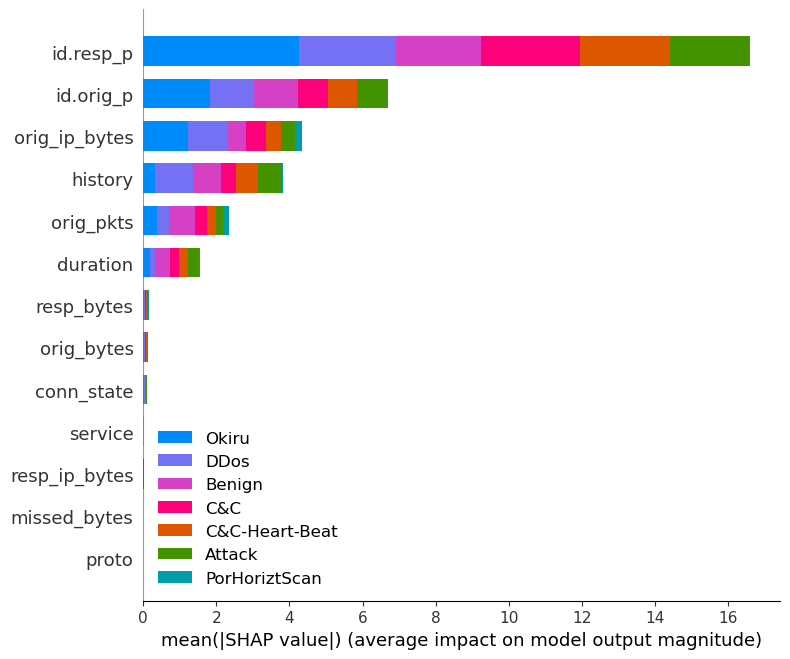

0:	learn: 0.8188225	total: 32.1ms	remaining: 3.18s
1:	learn: 3.8795193	total: 62.3ms	remaining: 3.05s
2:	learn: 355.4035542	total: 95.8ms	remaining: 3.1s
3:	learn: 2181.8375521	total: 130ms	remaining: 3.11s
4:	learn: 8458.0486085	total: 164ms	remaining: 3.12s
5:	learn: 24322.3597201	total: 198ms	remaining: 3.1s
6:	learn: 17396.7745774	total: 232ms	remaining: 3.09s
7:	learn: 10295.0128779	total: 266ms	remaining: 3.06s
8:	learn: 19328.3613512	total: 292ms	remaining: 2.95s
9:	learn: 15592.4742388	total: 313ms	remaining: 2.82s
10:	learn: 11697.7720398	total: 334ms	remaining: 2.7s
11:	learn: 25976.2039523	total: 357ms	remaining: 2.62s
12:	learn: 12056.7895212	total: 378ms	remaining: 2.53s
13:	learn: 11339.9784453	total: 399ms	remaining: 2.45s
14:	learn: 9713.5138330	total: 421ms	remaining: 2.38s
15:	learn: 8505.5409516	total: 441ms	remaining: 2.32s
16:	learn: 7555.4099921	total: 461ms	remaining: 2.25s
17:	learn: 7242.1498145	total: 480ms	remaining: 2.19s
18:	learn: 6640.9694526	total: 502ms

55:	learn: 810.5869664	total: 1.43s	remaining: 1.12s
56:	learn: 716.5487848	total: 1.45s	remaining: 1.09s
57:	learn: 651.5688447	total: 1.47s	remaining: 1.06s
58:	learn: 660.5426757	total: 1.49s	remaining: 1.04s
59:	learn: 861.6451949	total: 1.51s	remaining: 1.01s
60:	learn: 766.8914411	total: 1.54s	remaining: 982ms
61:	learn: 705.6609694	total: 1.56s	remaining: 954ms
62:	learn: 659.7064454	total: 1.58s	remaining: 927ms
63:	learn: 840.2565974	total: 1.6s	remaining: 900ms
64:	learn: 814.9917125	total: 1.62s	remaining: 874ms
65:	learn: 720.2423891	total: 1.65s	remaining: 848ms
66:	learn: 625.4937579	total: 1.67s	remaining: 821ms
67:	learn: 850.5353769	total: 1.69s	remaining: 794ms
68:	learn: 781.6193396	total: 1.71s	remaining: 768ms
69:	learn: 771.7847728	total: 1.73s	remaining: 742ms
70:	learn: 751.8844299	total: 1.75s	remaining: 716ms
71:	learn: 657.1795485	total: 1.77s	remaining: 690ms
72:	learn: 840.3025624	total: 1.79s	remaining: 663ms
73:	learn: 859.0333597	total: 1.82s	remaining: 

16:	learn: 7602.4826426	total: 451ms	remaining: 2.2s
17:	learn: 7285.5688690	total: 471ms	remaining: 2.15s
18:	learn: 6632.6786143	total: 491ms	remaining: 2.09s
19:	learn: 4793.2525010	total: 512ms	remaining: 2.05s
20:	learn: 5398.1703242	total: 533ms	remaining: 2.01s
21:	learn: 3996.8054722	total: 554ms	remaining: 1.96s
22:	learn: 2836.2979457	total: 576ms	remaining: 1.93s
23:	learn: 2758.7559444	total: 598ms	remaining: 1.89s
24:	learn: 2986.9601776	total: 618ms	remaining: 1.85s
25:	learn: 5903.5956782	total: 639ms	remaining: 1.82s
26:	learn: 6869.7485406	total: 661ms	remaining: 1.79s
27:	learn: 5762.9601690	total: 682ms	remaining: 1.75s
28:	learn: 5616.7662263	total: 703ms	remaining: 1.72s
29:	learn: 5170.8593611	total: 724ms	remaining: 1.69s
30:	learn: 5847.9498730	total: 745ms	remaining: 1.66s
31:	learn: 6772.7730666	total: 767ms	remaining: 1.63s
32:	learn: 4837.9996344	total: 788ms	remaining: 1.6s
33:	learn: 4569.0242339	total: 809ms	remaining: 1.57s
34:	learn: 4146.3828211	total:

79:	learn: 898.8717696	total: 1.75s	remaining: 438ms
80:	learn: 840.0817279	total: 1.77s	remaining: 416ms
81:	learn: 826.8427213	total: 1.79s	remaining: 394ms
82:	learn: 879.7741038	total: 1.81s	remaining: 371ms
83:	learn: 1266.5030637	total: 1.83s	remaining: 349ms
84:	learn: 984.1812898	total: 1.85s	remaining: 327ms
85:	learn: 961.4254665	total: 1.87s	remaining: 305ms
86:	learn: 939.0782743	total: 1.89s	remaining: 283ms
87:	learn: 928.4649449	total: 1.91s	remaining: 261ms
88:	learn: 872.5700707	total: 1.94s	remaining: 239ms
89:	learn: 854.8265704	total: 1.96s	remaining: 217ms
90:	learn: 789.1657413	total: 1.98s	remaining: 196ms
91:	learn: 849.8907403	total: 2s	remaining: 174ms
92:	learn: 1024.0449958	total: 2.02s	remaining: 152ms
93:	learn: 822.2924705	total: 2.04s	remaining: 130ms
94:	learn: 1345.0571241	total: 2.06s	remaining: 109ms
95:	learn: 2155.6880710	total: 2.08s	remaining: 86.8ms
96:	learn: 831.3923492	total: 2.1s	remaining: 65.1ms
97:	learn: 822.1890494	total: 2.13s	remainin

46:	learn: 0.1958317	total: 1.2s	remaining: 1.35s
47:	learn: 0.1891443	total: 1.22s	remaining: 1.32s
48:	learn: 0.1861596	total: 1.24s	remaining: 1.29s
49:	learn: 0.1817063	total: 1.26s	remaining: 1.26s
50:	learn: 0.1793206	total: 1.28s	remaining: 1.23s
51:	learn: 0.1766684	total: 1.3s	remaining: 1.2s
52:	learn: 0.1735082	total: 1.32s	remaining: 1.18s
53:	learn: 0.1685593	total: 1.35s	remaining: 1.15s
54:	learn: 0.1662623	total: 1.37s	remaining: 1.12s
55:	learn: 0.1632604	total: 1.39s	remaining: 1.09s
56:	learn: 0.1592244	total: 1.41s	remaining: 1.06s
57:	learn: 0.1547741	total: 1.43s	remaining: 1.04s
58:	learn: 0.1527877	total: 1.46s	remaining: 1.01s
59:	learn: 0.1510554	total: 1.48s	remaining: 984ms
60:	learn: 0.1482840	total: 1.5s	remaining: 959ms
61:	learn: 0.1465267	total: 1.52s	remaining: 932ms
62:	learn: 0.1450204	total: 1.54s	remaining: 905ms
63:	learn: 0.1434880	total: 1.56s	remaining: 878ms
64:	learn: 0.1403369	total: 1.58s	remaining: 852ms
65:	learn: 0.1367169	total: 1.6s	re

9:	learn: 0.7124737	total: 330ms	remaining: 2.97s
10:	learn: 0.6756572	total: 351ms	remaining: 2.84s
11:	learn: 0.6448317	total: 372ms	remaining: 2.73s
12:	learn: 0.6188857	total: 393ms	remaining: 2.63s
13:	learn: 0.5935399	total: 414ms	remaining: 2.54s
14:	learn: 0.5664123	total: 435ms	remaining: 2.46s
15:	learn: 0.5484270	total: 456ms	remaining: 2.4s
16:	learn: 0.5118344	total: 477ms	remaining: 2.33s
17:	learn: 0.4809876	total: 499ms	remaining: 2.27s
18:	learn: 0.4609988	total: 522ms	remaining: 2.23s
19:	learn: 0.4369600	total: 543ms	remaining: 2.17s
20:	learn: 0.4216070	total: 564ms	remaining: 2.12s
21:	learn: 0.4025379	total: 585ms	remaining: 2.07s
22:	learn: 0.3903896	total: 606ms	remaining: 2.03s
23:	learn: 0.3692522	total: 627ms	remaining: 1.99s
24:	learn: 0.3587253	total: 649ms	remaining: 1.95s
25:	learn: 0.3416594	total: 671ms	remaining: 1.91s
26:	learn: 0.3274996	total: 690ms	remaining: 1.87s
27:	learn: 0.3133941	total: 711ms	remaining: 1.83s
28:	learn: 0.3031234	total: 731ms

75:	learn: 0.1223545	total: 1.86s	remaining: 589ms
76:	learn: 0.1214929	total: 1.89s	remaining: 563ms
77:	learn: 0.1190417	total: 1.91s	remaining: 538ms
78:	learn: 0.1180868	total: 1.93s	remaining: 512ms
79:	learn: 0.1162256	total: 1.95s	remaining: 487ms
80:	learn: 0.1154385	total: 1.97s	remaining: 462ms
81:	learn: 0.1135282	total: 1.99s	remaining: 437ms
82:	learn: 0.1125548	total: 2.01s	remaining: 412ms
83:	learn: 0.1110374	total: 2.03s	remaining: 387ms
84:	learn: 0.1089098	total: 2.05s	remaining: 362ms
85:	learn: 0.1082524	total: 2.07s	remaining: 337ms
86:	learn: 0.1067107	total: 2.09s	remaining: 313ms
87:	learn: 0.1048083	total: 2.11s	remaining: 288ms
88:	learn: 0.1043695	total: 2.13s	remaining: 264ms
89:	learn: 0.1037715	total: 2.16s	remaining: 240ms
90:	learn: 0.1023374	total: 2.18s	remaining: 215ms
91:	learn: 0.1010010	total: 2.2s	remaining: 191ms
92:	learn: 0.1004569	total: 2.22s	remaining: 167ms
93:	learn: 0.0991909	total: 2.25s	remaining: 143ms
94:	learn: 0.0985468	total: 2.27

37:	learn: 1.1458536	total: 978ms	remaining: 1.59s
38:	learn: 1.1349407	total: 999ms	remaining: 1.56s
39:	learn: 1.1242809	total: 1.02s	remaining: 1.53s
40:	learn: 1.1139014	total: 1.04s	remaining: 1.5s
41:	learn: 1.1037602	total: 1.06s	remaining: 1.47s
42:	learn: 1.0938059	total: 1.09s	remaining: 1.44s
43:	learn: 1.0836961	total: 1.11s	remaining: 1.42s
44:	learn: 1.0741634	total: 1.14s	remaining: 1.39s
45:	learn: 1.0644761	total: 1.16s	remaining: 1.36s
46:	learn: 1.0550123	total: 1.18s	remaining: 1.33s
47:	learn: 1.0460763	total: 1.2s	remaining: 1.3s
48:	learn: 1.0373131	total: 1.23s	remaining: 1.28s
49:	learn: 1.0284018	total: 1.25s	remaining: 1.25s
50:	learn: 1.0196832	total: 1.27s	remaining: 1.22s
51:	learn: 1.0114311	total: 1.29s	remaining: 1.19s
52:	learn: 1.0030514	total: 1.31s	remaining: 1.16s
53:	learn: 0.9948473	total: 1.33s	remaining: 1.13s
54:	learn: 0.9868127	total: 1.35s	remaining: 1.11s
55:	learn: 0.9791721	total: 1.38s	remaining: 1.08s
56:	learn: 0.9716830	total: 1.4s	r

0:	learn: 1.9058045	total: 34.1ms	remaining: 3.38s
1:	learn: 1.8662669	total: 69ms	remaining: 3.38s
2:	learn: 1.8289439	total: 103ms	remaining: 3.32s
3:	learn: 1.7936135	total: 137ms	remaining: 3.28s
4:	learn: 1.7600951	total: 173ms	remaining: 3.29s
5:	learn: 1.7282223	total: 201ms	remaining: 3.15s
6:	learn: 1.6978584	total: 222ms	remaining: 2.95s
7:	learn: 1.6688754	total: 244ms	remaining: 2.81s
8:	learn: 1.6411758	total: 265ms	remaining: 2.68s
9:	learn: 1.6146427	total: 285ms	remaining: 2.56s
10:	learn: 1.5894044	total: 306ms	remaining: 2.47s
11:	learn: 1.5649767	total: 327ms	remaining: 2.4s
12:	learn: 1.5414994	total: 349ms	remaining: 2.33s
13:	learn: 1.5189028	total: 370ms	remaining: 2.27s
14:	learn: 1.4972998	total: 391ms	remaining: 2.22s
15:	learn: 1.4762976	total: 413ms	remaining: 2.17s
16:	learn: 1.4560292	total: 435ms	remaining: 2.12s
17:	learn: 1.4366033	total: 457ms	remaining: 2.08s
18:	learn: 1.4176672	total: 477ms	remaining: 2.03s
19:	learn: 1.3993484	total: 498ms	remainin

70:	learn: 0.8782974	total: 1.65s	remaining: 676ms
71:	learn: 0.8723900	total: 1.68s	remaining: 652ms
72:	learn: 0.8667499	total: 1.7s	remaining: 628ms
73:	learn: 0.8610375	total: 1.72s	remaining: 604ms
74:	learn: 0.8555799	total: 1.74s	remaining: 580ms
75:	learn: 0.8500499	total: 1.76s	remaining: 556ms
76:	learn: 0.8446156	total: 1.78s	remaining: 532ms
77:	learn: 0.8394167	total: 1.8s	remaining: 509ms
78:	learn: 0.8341558	total: 1.82s	remaining: 485ms
79:	learn: 0.8291231	total: 1.84s	remaining: 461ms
80:	learn: 0.8240260	total: 1.87s	remaining: 438ms
81:	learn: 0.8191526	total: 1.89s	remaining: 415ms
82:	learn: 0.8142143	total: 1.91s	remaining: 391ms
83:	learn: 0.8093512	total: 1.93s	remaining: 368ms
84:	learn: 0.8045693	total: 1.95s	remaining: 344ms
85:	learn: 0.7999876	total: 1.97s	remaining: 321ms
86:	learn: 0.7951972	total: 1.99s	remaining: 298ms
87:	learn: 0.7905024	total: 2.02s	remaining: 275ms
88:	learn: 0.7859657	total: 2.04s	remaining: 252ms
89:	learn: 0.7814121	total: 2.06s

33:	learn: 155.5040507	total: 1.03s	remaining: 2s
34:	learn: 207.5305377	total: 1.06s	remaining: 1.97s
35:	learn: 178.6116968	total: 1.09s	remaining: 1.94s
36:	learn: 132.4280835	total: 1.12s	remaining: 1.91s
37:	learn: 87.1744303	total: 1.15s	remaining: 1.87s
38:	learn: 145.3967573	total: 1.18s	remaining: 1.84s
39:	learn: 693.9627443	total: 1.2s	remaining: 1.81s
40:	learn: 279.7224968	total: 1.23s	remaining: 1.77s
41:	learn: 202.2908764	total: 1.26s	remaining: 1.74s
42:	learn: 117.5899711	total: 1.28s	remaining: 1.7s
43:	learn: 94.0702584	total: 1.31s	remaining: 1.67s
44:	learn: 673.3317383	total: 1.34s	remaining: 1.63s
45:	learn: 356.1259451	total: 1.36s	remaining: 1.6s
46:	learn: 217.3740863	total: 1.39s	remaining: 1.57s
47:	learn: 234.0676279	total: 1.41s	remaining: 1.53s
48:	learn: 919.1883617	total: 1.44s	remaining: 1.5s
49:	learn: 617.5542081	total: 1.46s	remaining: 1.46s
50:	learn: 453.2827880	total: 1.49s	remaining: 1.43s
51:	learn: 844.2301450	total: 1.52s	remaining: 1.4s
52:

95:	learn: 99.1654657	total: 2.79s	remaining: 116ms
96:	learn: 201.9327961	total: 2.82s	remaining: 87.3ms
97:	learn: 157.6446064	total: 2.85s	remaining: 58.2ms
98:	learn: 98.3382432	total: 2.88s	remaining: 29.1ms
99:	learn: 127.7270743	total: 2.91s	remaining: 0us
0:	learn: 0.4872192	total: 155ms	remaining: 15.4s
1:	learn: 7.9582037	total: 179ms	remaining: 8.75s
2:	learn: 1711.3973160	total: 204ms	remaining: 6.58s
3:	learn: 1514.7232229	total: 229ms	remaining: 5.5s
4:	learn: 2229.1119194	total: 255ms	remaining: 4.85s
5:	learn: 2565.3781734	total: 284ms	remaining: 4.45s
6:	learn: 1361.5484262	total: 310ms	remaining: 4.11s
7:	learn: 1135.6848045	total: 336ms	remaining: 3.87s
8:	learn: 813.6523794	total: 362ms	remaining: 3.66s
9:	learn: 583.0113128	total: 388ms	remaining: 3.49s
10:	learn: 662.4445908	total: 414ms	remaining: 3.35s
11:	learn: 545.6901110	total: 439ms	remaining: 3.22s
12:	learn: 509.4163419	total: 465ms	remaining: 3.11s
13:	learn: 723.5850739	total: 491ms	remaining: 3.02s
14:

58:	learn: 209.6106069	total: 1.73s	remaining: 1.2s
59:	learn: 216.3812787	total: 1.76s	remaining: 1.17s
60:	learn: 216.3046647	total: 1.78s	remaining: 1.14s
61:	learn: 165.6014909	total: 1.81s	remaining: 1.11s
62:	learn: 163.0860880	total: 1.84s	remaining: 1.08s
63:	learn: 155.7233754	total: 1.87s	remaining: 1.05s
64:	learn: 176.6606420	total: 1.89s	remaining: 1.02s
65:	learn: 208.1926166	total: 1.92s	remaining: 989ms
66:	learn: 193.9602242	total: 1.95s	remaining: 959ms
67:	learn: 162.9063990	total: 1.98s	remaining: 929ms
68:	learn: 142.1905896	total: 2s	remaining: 900ms
69:	learn: 123.9993727	total: 2.03s	remaining: 870ms
70:	learn: 121.7594045	total: 2.05s	remaining: 839ms
71:	learn: 105.1533632	total: 2.08s	remaining: 810ms
72:	learn: 255.8702564	total: 2.11s	remaining: 780ms
73:	learn: 209.2203550	total: 2.14s	remaining: 751ms
74:	learn: 162.9679567	total: 2.16s	remaining: 721ms
75:	learn: 116.7235625	total: 2.19s	remaining: 692ms
76:	learn: 148.2724192	total: 2.22s	remaining: 663

19:	learn: 0.2606811	total: 821ms	remaining: 3.28s
20:	learn: 0.2457254	total: 847ms	remaining: 3.19s
21:	learn: 0.2306065	total: 873ms	remaining: 3.09s
22:	learn: 0.2174275	total: 900ms	remaining: 3.01s
23:	learn: 0.2058215	total: 925ms	remaining: 2.93s
24:	learn: 0.1962066	total: 954ms	remaining: 2.86s
25:	learn: 0.1858923	total: 982ms	remaining: 2.79s
26:	learn: 0.1774275	total: 1.01s	remaining: 2.73s
27:	learn: 0.1688440	total: 1.03s	remaining: 2.66s
28:	learn: 0.1612791	total: 1.06s	remaining: 2.6s
29:	learn: 0.1549746	total: 1.09s	remaining: 2.54s
30:	learn: 0.1482430	total: 1.11s	remaining: 2.48s
31:	learn: 0.1400751	total: 1.14s	remaining: 2.42s
32:	learn: 0.1349318	total: 1.17s	remaining: 2.37s
33:	learn: 0.1293469	total: 1.2s	remaining: 2.32s
34:	learn: 0.1237850	total: 1.23s	remaining: 2.29s
35:	learn: 0.1188958	total: 1.26s	remaining: 2.24s
36:	learn: 0.1096883	total: 1.29s	remaining: 2.19s
37:	learn: 0.1060222	total: 1.32s	remaining: 2.15s
38:	learn: 0.1028703	total: 1.35s

81:	learn: 0.0441597	total: 2.33s	remaining: 512ms
82:	learn: 0.0437478	total: 2.36s	remaining: 483ms
83:	learn: 0.0432129	total: 2.38s	remaining: 454ms
84:	learn: 0.0426846	total: 2.41s	remaining: 425ms
85:	learn: 0.0422290	total: 2.43s	remaining: 396ms
86:	learn: 0.0417996	total: 2.46s	remaining: 367ms
87:	learn: 0.0414227	total: 2.48s	remaining: 339ms
88:	learn: 0.0410591	total: 2.51s	remaining: 310ms
89:	learn: 0.0407284	total: 2.54s	remaining: 282ms
90:	learn: 0.0403420	total: 2.56s	remaining: 254ms
91:	learn: 0.0399723	total: 2.59s	remaining: 225ms
92:	learn: 0.0397022	total: 2.61s	remaining: 197ms
93:	learn: 0.0393254	total: 2.64s	remaining: 169ms
94:	learn: 0.0388661	total: 2.67s	remaining: 140ms
95:	learn: 0.0382983	total: 2.69s	remaining: 112ms
96:	learn: 0.0379269	total: 2.72s	remaining: 84.2ms
97:	learn: 0.0376430	total: 2.75s	remaining: 56ms
98:	learn: 0.0372194	total: 2.77s	remaining: 28ms
99:	learn: 0.0370496	total: 2.79s	remaining: 0us
0:	learn: 1.5063735	total: 165ms	r

45:	learn: 0.0838701	total: 1.3s	remaining: 1.52s
46:	learn: 0.0814681	total: 1.32s	remaining: 1.49s
47:	learn: 0.0795098	total: 1.35s	remaining: 1.46s
48:	learn: 0.0778937	total: 1.37s	remaining: 1.43s
49:	learn: 0.0759055	total: 1.4s	remaining: 1.4s
50:	learn: 0.0732806	total: 1.43s	remaining: 1.37s
51:	learn: 0.0715436	total: 1.46s	remaining: 1.34s
52:	learn: 0.0700923	total: 1.48s	remaining: 1.31s
53:	learn: 0.0685195	total: 1.5s	remaining: 1.28s
54:	learn: 0.0666239	total: 1.53s	remaining: 1.25s
55:	learn: 0.0649152	total: 1.56s	remaining: 1.23s
56:	learn: 0.0634454	total: 1.59s	remaining: 1.2s
57:	learn: 0.0621783	total: 1.62s	remaining: 1.17s
58:	learn: 0.0609805	total: 1.64s	remaining: 1.14s
59:	learn: 0.0598759	total: 1.67s	remaining: 1.11s
60:	learn: 0.0589630	total: 1.69s	remaining: 1.08s
61:	learn: 0.0577669	total: 1.72s	remaining: 1.05s
62:	learn: 0.0567988	total: 1.74s	remaining: 1.02s
63:	learn: 0.0561095	total: 1.77s	remaining: 994ms
64:	learn: 0.0550812	total: 1.79s	re

8:	learn: 1.6085804	total: 342ms	remaining: 3.45s
9:	learn: 1.5794137	total: 367ms	remaining: 3.3s
10:	learn: 1.5515699	total: 391ms	remaining: 3.17s
11:	learn: 1.5247591	total: 416ms	remaining: 3.05s
12:	learn: 1.4989374	total: 443ms	remaining: 2.96s
13:	learn: 1.4741644	total: 467ms	remaining: 2.87s
14:	learn: 1.4502403	total: 494ms	remaining: 2.8s
15:	learn: 1.4271849	total: 522ms	remaining: 2.74s
16:	learn: 1.4049447	total: 548ms	remaining: 2.67s
17:	learn: 1.3834938	total: 574ms	remaining: 2.61s
18:	learn: 1.3627816	total: 599ms	remaining: 2.55s
19:	learn: 1.3426671	total: 625ms	remaining: 2.5s
20:	learn: 1.3232017	total: 652ms	remaining: 2.45s
21:	learn: 1.3043103	total: 677ms	remaining: 2.4s
22:	learn: 1.2860800	total: 702ms	remaining: 2.35s
23:	learn: 1.2684119	total: 729ms	remaining: 2.31s
24:	learn: 1.2511544	total: 755ms	remaining: 2.27s
25:	learn: 1.2343992	total: 782ms	remaining: 2.23s
26:	learn: 1.2181227	total: 810ms	remaining: 2.19s
27:	learn: 1.2020268	total: 837ms	rem

74:	learn: 0.7433495	total: 2.03s	remaining: 675ms
75:	learn: 0.7366327	total: 2.05s	remaining: 648ms
76:	learn: 0.7305540	total: 2.08s	remaining: 621ms
77:	learn: 0.7246395	total: 2.11s	remaining: 594ms
78:	learn: 0.7183258	total: 2.13s	remaining: 567ms
79:	learn: 0.7121372	total: 2.16s	remaining: 539ms
80:	learn: 0.7064163	total: 2.19s	remaining: 513ms
81:	learn: 0.7004256	total: 2.21s	remaining: 485ms
82:	learn: 0.6945142	total: 2.24s	remaining: 458ms
83:	learn: 0.6885225	total: 2.26s	remaining: 431ms
84:	learn: 0.6828317	total: 2.29s	remaining: 405ms
85:	learn: 0.6775141	total: 2.32s	remaining: 378ms
86:	learn: 0.6717890	total: 2.35s	remaining: 351ms
87:	learn: 0.6663454	total: 2.37s	remaining: 324ms
88:	learn: 0.6612602	total: 2.4s	remaining: 297ms
89:	learn: 0.6559528	total: 2.42s	remaining: 269ms
90:	learn: 0.6505970	total: 2.45s	remaining: 242ms
91:	learn: 0.6454797	total: 2.48s	remaining: 215ms
92:	learn: 0.6406759	total: 2.5s	remaining: 188ms
93:	learn: 0.6357002	total: 2.53s

42:	learn: 1.0067628	total: 1.36s	remaining: 1.81s
43:	learn: 0.9959061	total: 1.39s	remaining: 1.77s
44:	learn: 0.9855538	total: 1.41s	remaining: 1.73s
45:	learn: 0.9751510	total: 1.44s	remaining: 1.69s
46:	learn: 0.9650114	total: 1.46s	remaining: 1.65s
47:	learn: 0.9550475	total: 1.49s	remaining: 1.61s
48:	learn: 0.9453294	total: 1.51s	remaining: 1.57s
49:	learn: 0.9357747	total: 1.54s	remaining: 1.54s
50:	learn: 0.9264124	total: 1.56s	remaining: 1.5s
51:	learn: 0.9174740	total: 1.59s	remaining: 1.47s
52:	learn: 0.9086903	total: 1.61s	remaining: 1.43s
53:	learn: 0.8998644	total: 1.64s	remaining: 1.4s
54:	learn: 0.8912113	total: 1.66s	remaining: 1.36s
55:	learn: 0.8827441	total: 1.69s	remaining: 1.33s
56:	learn: 0.8744190	total: 1.72s	remaining: 1.29s
57:	learn: 0.8664582	total: 1.74s	remaining: 1.26s
58:	learn: 0.8584374	total: 1.77s	remaining: 1.23s
59:	learn: 0.8507751	total: 1.79s	remaining: 1.2s
60:	learn: 0.8430464	total: 1.82s	remaining: 1.16s
61:	learn: 0.8352944	total: 1.84s	

3:	learn: 37.7204201	total: 436ms	remaining: 10.5s
4:	learn: 163.1840957	total: 482ms	remaining: 9.15s
5:	learn: 119.9177355	total: 529ms	remaining: 8.29s
6:	learn: 91.7290039	total: 576ms	remaining: 7.65s
7:	learn: 59.7854650	total: 626ms	remaining: 7.2s
8:	learn: 39.1503402	total: 674ms	remaining: 6.82s
9:	learn: 63.2980823	total: 721ms	remaining: 6.49s
10:	learn: 120.1565076	total: 768ms	remaining: 6.22s
11:	learn: 86.8122570	total: 820ms	remaining: 6.01s
12:	learn: 59.2826712	total: 868ms	remaining: 5.81s
13:	learn: 36.0881356	total: 914ms	remaining: 5.61s
14:	learn: 101.5203314	total: 961ms	remaining: 5.45s
15:	learn: 188.3797389	total: 1.01s	remaining: 5.29s
16:	learn: 165.9861595	total: 1.05s	remaining: 5.15s
17:	learn: 140.3043709	total: 1.1s	remaining: 5.02s
18:	learn: 96.5163878	total: 1.15s	remaining: 4.91s
19:	learn: 38.4313413	total: 1.2s	remaining: 4.79s
20:	learn: 130.9314527	total: 1.24s	remaining: 4.68s
21:	learn: 86.1822980	total: 1.29s	remaining: 4.58s
22:	learn: 244

63:	learn: 35.4465101	total: 3.18s	remaining: 1.79s
64:	learn: 22.1572150	total: 3.22s	remaining: 1.74s
65:	learn: 29.6620185	total: 3.27s	remaining: 1.69s
66:	learn: 63.9739240	total: 3.32s	remaining: 1.64s
67:	learn: 51.0967259	total: 3.37s	remaining: 1.59s
68:	learn: 31.4024856	total: 3.42s	remaining: 1.54s
69:	learn: 19.2749397	total: 3.47s	remaining: 1.49s
70:	learn: 57.5837150	total: 3.52s	remaining: 1.44s
71:	learn: 41.1758580	total: 3.56s	remaining: 1.39s
72:	learn: 23.8093410	total: 3.61s	remaining: 1.34s
73:	learn: 14.9481585	total: 3.66s	remaining: 1.28s
74:	learn: 38.4534715	total: 3.71s	remaining: 1.24s
75:	learn: 78.0552021	total: 3.76s	remaining: 1.19s
76:	learn: 74.0903767	total: 3.8s	remaining: 1.14s
77:	learn: 65.1908364	total: 3.85s	remaining: 1.08s
78:	learn: 52.3052751	total: 3.89s	remaining: 1.03s
79:	learn: 50.3912950	total: 3.94s	remaining: 985ms
80:	learn: 28.0017998	total: 3.99s	remaining: 936ms
81:	learn: 36.1594194	total: 4.04s	remaining: 886ms
82:	learn: 74

23:	learn: 14.1321124	total: 1.3s	remaining: 4.11s
24:	learn: 55.2164633	total: 1.34s	remaining: 4.04s
25:	learn: 68.8993360	total: 1.4s	remaining: 3.97s
26:	learn: 48.1432640	total: 1.44s	remaining: 3.9s
27:	learn: 32.3785206	total: 1.49s	remaining: 3.83s
28:	learn: 14.7009132	total: 1.54s	remaining: 3.77s
29:	learn: 54.7320923	total: 1.59s	remaining: 3.7s
30:	learn: 62.9048198	total: 1.63s	remaining: 3.64s
31:	learn: 51.3608348	total: 1.68s	remaining: 3.58s
32:	learn: 24.8976184	total: 1.73s	remaining: 3.52s
33:	learn: 9.9954020	total: 1.78s	remaining: 3.46s
34:	learn: 71.5340989	total: 1.83s	remaining: 3.39s
35:	learn: 73.8398950	total: 1.87s	remaining: 3.33s
36:	learn: 53.6505839	total: 1.92s	remaining: 3.27s
37:	learn: 31.3650943	total: 1.97s	remaining: 3.21s
38:	learn: 59.3506416	total: 2.02s	remaining: 3.16s
39:	learn: 84.9696722	total: 2.06s	remaining: 3.1s
40:	learn: 62.3779408	total: 2.11s	remaining: 3.04s
41:	learn: 38.9370351	total: 2.16s	remaining: 2.98s
42:	learn: 20.3149

84:	learn: 0.0262141	total: 4.18s	remaining: 737ms
85:	learn: 0.0261195	total: 4.22s	remaining: 687ms
86:	learn: 0.0259672	total: 4.26s	remaining: 637ms
87:	learn: 0.0258870	total: 4.31s	remaining: 588ms
88:	learn: 0.0258475	total: 4.35s	remaining: 538ms
89:	learn: 0.0257208	total: 4.39s	remaining: 488ms
90:	learn: 0.0256425	total: 4.44s	remaining: 439ms
91:	learn: 0.0255356	total: 4.49s	remaining: 390ms
92:	learn: 0.0254405	total: 4.53s	remaining: 341ms
93:	learn: 0.0253872	total: 4.57s	remaining: 292ms
94:	learn: 0.0253689	total: 4.61s	remaining: 243ms
95:	learn: 0.0253225	total: 4.65s	remaining: 194ms
96:	learn: 0.0252383	total: 4.7s	remaining: 145ms
97:	learn: 0.0251687	total: 4.75s	remaining: 96.9ms
98:	learn: 0.0250771	total: 4.79s	remaining: 48.4ms
99:	learn: 0.0250414	total: 4.83s	remaining: 0us
0:	learn: 1.4405184	total: 161ms	remaining: 15.9s
1:	learn: 1.1797878	total: 204ms	remaining: 9.97s
2:	learn: 0.9972526	total: 248ms	remaining: 8.03s
3:	learn: 0.8645992	total: 294ms	re

49:	learn: 0.0384781	total: 2.46s	remaining: 2.46s
50:	learn: 0.0375128	total: 2.51s	remaining: 2.41s
51:	learn: 0.0367271	total: 2.56s	remaining: 2.36s
52:	learn: 0.0358591	total: 2.61s	remaining: 2.31s
53:	learn: 0.0351839	total: 2.66s	remaining: 2.26s
54:	learn: 0.0345989	total: 2.7s	remaining: 2.21s
55:	learn: 0.0341125	total: 2.75s	remaining: 2.16s
56:	learn: 0.0335870	total: 2.79s	remaining: 2.11s
57:	learn: 0.0331138	total: 2.84s	remaining: 2.06s
58:	learn: 0.0327255	total: 2.89s	remaining: 2s
59:	learn: 0.0322515	total: 2.94s	remaining: 1.96s
60:	learn: 0.0318014	total: 2.98s	remaining: 1.9s
61:	learn: 0.0314975	total: 3.02s	remaining: 1.85s
62:	learn: 0.0311113	total: 3.07s	remaining: 1.8s
63:	learn: 0.0307772	total: 3.11s	remaining: 1.75s
64:	learn: 0.0305253	total: 3.16s	remaining: 1.7s
65:	learn: 0.0301674	total: 3.2s	remaining: 1.65s
66:	learn: 0.0299463	total: 3.25s	remaining: 1.6s
67:	learn: 0.0297714	total: 3.29s	remaining: 1.55s
68:	learn: 0.0294618	total: 3.33s	remain

14:	learn: 0.2915132	total: 923ms	remaining: 5.23s
15:	learn: 0.2683677	total: 972ms	remaining: 5.1s
16:	learn: 0.2481672	total: 1.02s	remaining: 4.97s
17:	learn: 0.2299623	total: 1.06s	remaining: 4.85s
18:	learn: 0.2080741	total: 1.11s	remaining: 4.74s
19:	learn: 0.1886622	total: 1.16s	remaining: 4.64s
20:	learn: 0.1722918	total: 1.21s	remaining: 4.54s
21:	learn: 0.1579194	total: 1.25s	remaining: 4.45s
22:	learn: 0.1449816	total: 1.3s	remaining: 4.36s
23:	learn: 0.1337001	total: 1.35s	remaining: 4.27s
24:	learn: 0.1235103	total: 1.4s	remaining: 4.19s
25:	learn: 0.1146261	total: 1.44s	remaining: 4.11s
26:	learn: 0.1062955	total: 1.49s	remaining: 4.03s
27:	learn: 0.0992532	total: 1.53s	remaining: 3.95s
28:	learn: 0.0927888	total: 1.58s	remaining: 3.87s
29:	learn: 0.0869518	total: 1.63s	remaining: 3.8s
30:	learn: 0.0816482	total: 1.67s	remaining: 3.72s
31:	learn: 0.0771176	total: 1.72s	remaining: 3.66s
32:	learn: 0.0728473	total: 1.77s	remaining: 3.59s
33:	learn: 0.0688521	total: 1.82s	r

80:	learn: 0.5761713	total: 3.83s	remaining: 899ms
81:	learn: 0.5703098	total: 3.88s	remaining: 851ms
82:	learn: 0.5645598	total: 3.92s	remaining: 804ms
83:	learn: 0.5589019	total: 3.97s	remaining: 756ms
84:	learn: 0.5533335	total: 4.02s	remaining: 709ms
85:	learn: 0.5478361	total: 4.06s	remaining: 662ms
86:	learn: 0.5424903	total: 4.11s	remaining: 614ms
87:	learn: 0.5371609	total: 4.16s	remaining: 567ms
88:	learn: 0.5319168	total: 4.2s	remaining: 519ms
89:	learn: 0.5267509	total: 4.25s	remaining: 472ms
90:	learn: 0.5216790	total: 4.29s	remaining: 425ms
91:	learn: 0.5166699	total: 4.34s	remaining: 377ms
92:	learn: 0.5117403	total: 4.38s	remaining: 330ms
93:	learn: 0.5068948	total: 4.43s	remaining: 283ms
94:	learn: 0.5021107	total: 4.48s	remaining: 236ms
95:	learn: 0.4973970	total: 4.52s	remaining: 189ms
96:	learn: 0.4927662	total: 4.57s	remaining: 141ms
97:	learn: 0.4881916	total: 4.62s	remaining: 94.2ms
98:	learn: 0.4836963	total: 4.66s	remaining: 47.1ms
99:	learn: 0.4792667	total: 4.

45:	learn: 0.8621302	total: 2.25s	remaining: 2.65s
46:	learn: 0.8511635	total: 2.3s	remaining: 2.59s
47:	learn: 0.8403116	total: 2.34s	remaining: 2.54s
48:	learn: 0.8296765	total: 2.39s	remaining: 2.49s
49:	learn: 0.8192769	total: 2.43s	remaining: 2.43s
50:	learn: 0.8088325	total: 2.48s	remaining: 2.39s
51:	learn: 0.7989572	total: 2.53s	remaining: 2.34s
52:	learn: 0.7891740	total: 2.58s	remaining: 2.28s
53:	learn: 0.7793510	total: 2.63s	remaining: 2.24s
54:	learn: 0.7697197	total: 2.67s	remaining: 2.19s
55:	learn: 0.7605934	total: 2.71s	remaining: 2.13s
56:	learn: 0.7515555	total: 2.76s	remaining: 2.08s
57:	learn: 0.7426925	total: 2.8s	remaining: 2.03s
58:	learn: 0.7337794	total: 2.85s	remaining: 1.98s
59:	learn: 0.7253313	total: 2.9s	remaining: 1.93s
60:	learn: 0.7167443	total: 2.95s	remaining: 1.88s
61:	learn: 0.7085266	total: 3s	remaining: 1.84s
62:	learn: 0.7002594	total: 3.04s	remaining: 1.79s
63:	learn: 0.6921388	total: 3.09s	remaining: 1.74s
64:	learn: 0.6844377	total: 3.13s	rem

10:	learn: 1.5006198	total: 641ms	remaining: 5.19s
11:	learn: 1.4705946	total: 688ms	remaining: 5.04s
12:	learn: 1.4417975	total: 733ms	remaining: 4.9s
13:	learn: 1.4141366	total: 780ms	remaining: 4.79s
14:	learn: 1.3875377	total: 826ms	remaining: 4.68s
15:	learn: 1.3616334	total: 872ms	remaining: 4.58s
16:	learn: 1.3369434	total: 916ms	remaining: 4.47s
17:	learn: 1.3128370	total: 964ms	remaining: 4.39s
18:	learn: 1.2898287	total: 1.01s	remaining: 4.31s
19:	learn: 1.2673370	total: 1.05s	remaining: 4.22s
20:	learn: 1.2458127	total: 1.1s	remaining: 4.14s
21:	learn: 1.2247406	total: 1.14s	remaining: 4.06s
22:	learn: 1.2043351	total: 1.19s	remaining: 3.99s
23:	learn: 1.1847484	total: 1.24s	remaining: 3.92s
24:	learn: 1.1655334	total: 1.28s	remaining: 3.84s
25:	learn: 1.1469064	total: 1.33s	remaining: 3.79s
26:	learn: 1.1290031	total: 1.37s	remaining: 3.72s
27:	learn: 1.1115921	total: 1.42s	remaining: 3.65s
28:	learn: 1.0944782	total: 1.47s	remaining: 3.59s
29:	learn: 1.0780024	total: 1.51s

73:	learn: 183.9669973	total: 2.66s	remaining: 935ms
74:	learn: 185.6024748	total: 2.7s	remaining: 899ms
75:	learn: 171.1781424	total: 2.73s	remaining: 863ms
76:	learn: 183.3716332	total: 2.77s	remaining: 826ms
77:	learn: 227.3112436	total: 2.8s	remaining: 791ms
78:	learn: 203.4547283	total: 2.84s	remaining: 755ms
79:	learn: 177.2766357	total: 2.88s	remaining: 719ms
80:	learn: 164.6893968	total: 2.91s	remaining: 683ms
81:	learn: 165.5215082	total: 2.95s	remaining: 647ms
82:	learn: 156.9486074	total: 2.99s	remaining: 612ms
83:	learn: 173.6767785	total: 3.02s	remaining: 576ms
84:	learn: 191.1410122	total: 3.06s	remaining: 540ms
85:	learn: 173.3177290	total: 3.09s	remaining: 504ms
86:	learn: 157.5003775	total: 3.13s	remaining: 468ms
87:	learn: 145.4338788	total: 3.16s	remaining: 431ms
88:	learn: 131.1631207	total: 3.2s	remaining: 395ms
89:	learn: 156.7308795	total: 3.23s	remaining: 359ms
90:	learn: 198.1140342	total: 3.27s	remaining: 323ms
91:	learn: 177.5506430	total: 3.3s	remaining: 287

39:	learn: 1484.0162418	total: 1.49s	remaining: 2.23s
40:	learn: 1279.0930224	total: 1.52s	remaining: 2.19s
41:	learn: 1007.4547543	total: 1.56s	remaining: 2.15s
42:	learn: 518.9000422	total: 1.59s	remaining: 2.11s
43:	learn: 389.1346825	total: 1.63s	remaining: 2.07s
44:	learn: 383.2985841	total: 1.66s	remaining: 2.03s
45:	learn: 380.4779337	total: 1.69s	remaining: 1.99s
46:	learn: 375.4948871	total: 1.73s	remaining: 1.95s
47:	learn: 369.8427179	total: 1.76s	remaining: 1.91s
48:	learn: 307.1363482	total: 1.8s	remaining: 1.87s
49:	learn: 570.9933826	total: 1.83s	remaining: 1.83s
50:	learn: 823.5744951	total: 1.87s	remaining: 1.8s
51:	learn: 1605.4781392	total: 1.9s	remaining: 1.76s
52:	learn: 302.2598034	total: 1.94s	remaining: 1.72s
53:	learn: 247.6951532	total: 1.97s	remaining: 1.68s
54:	learn: 350.0721361	total: 2s	remaining: 1.64s
55:	learn: 552.6263593	total: 2.04s	remaining: 1.6s
56:	learn: 414.7088618	total: 2.07s	remaining: 1.56s
57:	learn: 394.4828875	total: 2.1s	remaining: 1.5

97:	learn: 179.2734608	total: 3.57s	remaining: 72.8ms
98:	learn: 159.5746168	total: 3.6s	remaining: 36.4ms
99:	learn: 138.8937656	total: 3.63s	remaining: 0us
0:	learn: 0.3275984	total: 198ms	remaining: 19.6s
1:	learn: 4.4217436	total: 229ms	remaining: 11.2s
2:	learn: 168.1753711	total: 261ms	remaining: 8.45s
3:	learn: 26.7894554	total: 296ms	remaining: 7.1s
4:	learn: 1.4606573	total: 330ms	remaining: 6.26s
5:	learn: 0.9619985	total: 359ms	remaining: 5.63s
6:	learn: 0.9512241	total: 396ms	remaining: 5.26s
7:	learn: 0.8877934	total: 427ms	remaining: 4.91s
8:	learn: 0.8405884	total: 461ms	remaining: 4.66s
9:	learn: 1.1977554	total: 493ms	remaining: 4.43s
10:	learn: 1.0876508	total: 529ms	remaining: 4.28s
11:	learn: 4.4937352	total: 564ms	remaining: 4.13s
12:	learn: 4.1787341	total: 599ms	remaining: 4.01s
13:	learn: 7.1867855	total: 631ms	remaining: 3.87s
14:	learn: 72.6447896	total: 666ms	remaining: 3.77s
15:	learn: 69.5425681	total: 700ms	remaining: 3.67s
16:	learn: 1760.7291740	total: 7

58:	learn: 0.0393544	total: 2.12s	remaining: 1.47s
59:	learn: 0.0388226	total: 2.15s	remaining: 1.43s
60:	learn: 0.0380865	total: 2.18s	remaining: 1.4s
61:	learn: 0.0377171	total: 2.21s	remaining: 1.36s
62:	learn: 0.0373032	total: 2.25s	remaining: 1.32s
63:	learn: 0.0368840	total: 2.27s	remaining: 1.28s
64:	learn: 0.0365878	total: 2.3s	remaining: 1.24s
65:	learn: 0.0361966	total: 2.34s	remaining: 1.2s
66:	learn: 0.0358042	total: 2.37s	remaining: 1.17s
67:	learn: 0.0355708	total: 2.4s	remaining: 1.13s
68:	learn: 0.0352897	total: 2.43s	remaining: 1.09s
69:	learn: 0.0349017	total: 2.46s	remaining: 1.05s
70:	learn: 0.0346158	total: 2.49s	remaining: 1.02s
71:	learn: 0.0342481	total: 2.52s	remaining: 982ms
72:	learn: 0.0341091	total: 2.55s	remaining: 944ms
73:	learn: 0.0337161	total: 2.59s	remaining: 910ms
74:	learn: 0.0332488	total: 2.63s	remaining: 875ms
75:	learn: 0.0329393	total: 2.65s	remaining: 839ms
76:	learn: 0.0326737	total: 2.69s	remaining: 803ms
77:	learn: 0.0325187	total: 2.72s	r

25:	learn: 0.1373956	total: 1s	remaining: 2.86s
26:	learn: 0.1237090	total: 1.04s	remaining: 2.81s
27:	learn: 0.1145000	total: 1.07s	remaining: 2.76s
28:	learn: 0.1078019	total: 1.11s	remaining: 2.72s
29:	learn: 0.1018264	total: 1.14s	remaining: 2.67s
30:	learn: 0.0965775	total: 1.18s	remaining: 2.62s
31:	learn: 0.0916150	total: 1.21s	remaining: 2.58s
32:	learn: 0.0867764	total: 1.25s	remaining: 2.53s
33:	learn: 0.0828546	total: 1.28s	remaining: 2.49s
34:	learn: 0.0789355	total: 1.32s	remaining: 2.45s
35:	learn: 0.0752286	total: 1.35s	remaining: 2.4s
36:	learn: 0.0717050	total: 1.39s	remaining: 2.36s
37:	learn: 0.0685714	total: 1.42s	remaining: 2.32s
38:	learn: 0.0662290	total: 1.45s	remaining: 2.27s
39:	learn: 0.0637278	total: 1.48s	remaining: 2.23s
40:	learn: 0.0615860	total: 1.52s	remaining: 2.18s
41:	learn: 0.0596646	total: 1.55s	remaining: 2.14s
42:	learn: 0.0577944	total: 1.58s	remaining: 2.1s
43:	learn: 0.0561520	total: 1.61s	remaining: 2.06s
44:	learn: 0.0546726	total: 1.65s	re

91:	learn: 0.0295329	total: 3.17s	remaining: 275ms
92:	learn: 0.0293169	total: 3.2s	remaining: 241ms
93:	learn: 0.0292427	total: 3.23s	remaining: 206ms
94:	learn: 0.0291213	total: 3.26s	remaining: 172ms
95:	learn: 0.0290570	total: 3.29s	remaining: 137ms
96:	learn: 0.0288859	total: 3.33s	remaining: 103ms
97:	learn: 0.0287570	total: 3.37s	remaining: 68.7ms
98:	learn: 0.0286244	total: 3.4s	remaining: 34.3ms
99:	learn: 0.0285152	total: 3.43s	remaining: 0us
0:	learn: 1.4760323	total: 182ms	remaining: 18s
1:	learn: 1.2261512	total: 213ms	remaining: 10.4s
2:	learn: 1.0438424	total: 245ms	remaining: 7.93s
3:	learn: 0.9103303	total: 278ms	remaining: 6.68s
4:	learn: 0.7998799	total: 309ms	remaining: 5.86s
5:	learn: 0.7137792	total: 343ms	remaining: 5.37s
6:	learn: 0.6404530	total: 374ms	remaining: 4.97s
7:	learn: 0.5804805	total: 406ms	remaining: 4.66s
8:	learn: 0.5303261	total: 440ms	remaining: 4.45s
9:	learn: 0.4841197	total: 472ms	remaining: 4.25s
10:	learn: 0.4458821	total: 504ms	remaining: 

55:	learn: 0.8017241	total: 2.13s	remaining: 1.67s
56:	learn: 0.7926479	total: 2.16s	remaining: 1.63s
57:	learn: 0.7837901	total: 2.19s	remaining: 1.59s
58:	learn: 0.7751134	total: 2.23s	remaining: 1.55s
59:	learn: 0.7666140	total: 2.26s	remaining: 1.51s
60:	learn: 0.7581759	total: 2.3s	remaining: 1.47s
61:	learn: 0.7499745	total: 2.33s	remaining: 1.43s
62:	learn: 0.7419672	total: 2.36s	remaining: 1.39s
63:	learn: 0.7340075	total: 2.4s	remaining: 1.35s
64:	learn: 0.7262023	total: 2.43s	remaining: 1.31s
65:	learn: 0.7186435	total: 2.46s	remaining: 1.27s
66:	learn: 0.7112262	total: 2.5s	remaining: 1.23s
67:	learn: 0.7038477	total: 2.53s	remaining: 1.19s
68:	learn: 0.6967056	total: 2.56s	remaining: 1.15s
69:	learn: 0.6895917	total: 2.59s	remaining: 1.11s
70:	learn: 0.6826901	total: 2.62s	remaining: 1.07s
71:	learn: 0.6759305	total: 2.65s	remaining: 1.03s
72:	learn: 0.6691881	total: 2.69s	remaining: 994ms
73:	learn: 0.6626511	total: 2.72s	remaining: 956ms
74:	learn: 0.6562268	total: 2.75s	

18:	learn: 1.3252874	total: 714ms	remaining: 3.04s
19:	learn: 1.3032604	total: 749ms	remaining: 3s
20:	learn: 1.2819689	total: 784ms	remaining: 2.95s
21:	learn: 1.2621524	total: 817ms	remaining: 2.9s
22:	learn: 1.2421590	total: 851ms	remaining: 2.85s
23:	learn: 1.2235164	total: 883ms	remaining: 2.8s
24:	learn: 1.2046717	total: 916ms	remaining: 2.75s
25:	learn: 1.1861112	total: 948ms	remaining: 2.7s
26:	learn: 1.1683055	total: 982ms	remaining: 2.65s
27:	learn: 1.1510134	total: 1.01s	remaining: 2.61s
28:	learn: 1.1339283	total: 1.05s	remaining: 2.56s
29:	learn: 1.1173451	total: 1.08s	remaining: 2.52s
30:	learn: 1.1013450	total: 1.11s	remaining: 2.48s
31:	learn: 1.0856245	total: 1.14s	remaining: 2.43s
32:	learn: 1.0704172	total: 1.18s	remaining: 2.39s
33:	learn: 1.0554862	total: 1.21s	remaining: 2.36s
34:	learn: 1.0410129	total: 1.25s	remaining: 2.32s
35:	learn: 1.0269060	total: 1.28s	remaining: 2.28s
36:	learn: 1.0131549	total: 1.31s	remaining: 2.24s
37:	learn: 0.9995652	total: 1.35s	rem

86:	learn: 0.5841553	total: 3.03s	remaining: 453ms
87:	learn: 0.5789329	total: 3.06s	remaining: 418ms
88:	learn: 0.5733843	total: 3.1s	remaining: 383ms
89:	learn: 0.5679291	total: 3.13s	remaining: 348ms
90:	learn: 0.5625655	total: 3.17s	remaining: 313ms
91:	learn: 0.5573102	total: 3.2s	remaining: 278ms
92:	learn: 0.5521200	total: 3.23s	remaining: 243ms
93:	learn: 0.5470105	total: 3.27s	remaining: 209ms
94:	learn: 0.5421854	total: 3.3s	remaining: 174ms
95:	learn: 0.5372228	total: 3.33s	remaining: 139ms
96:	learn: 0.5325348	total: 3.37s	remaining: 104ms
97:	learn: 0.5277097	total: 3.4s	remaining: 69.4ms
98:	learn: 0.5231567	total: 3.43s	remaining: 34.7ms
99:	learn: 0.5187432	total: 3.46s	remaining: 0us
0:	learn: 1.8962908	total: 61.4ms	remaining: 6.07s
1:	learn: 1.8495294	total: 121ms	remaining: 5.95s
2:	learn: 1.8055538	total: 178ms	remaining: 5.76s
3:	learn: 1.7640635	total: 215ms	remaining: 5.15s
4:	learn: 1.7248114	total: 250ms	remaining: 4.76s
5:	learn: 1.6875769	total: 283ms	remain

48:	learn: 0.0383601	total: 2.78s	remaining: 2.89s
49:	learn: 0.0372931	total: 2.83s	remaining: 2.83s
50:	learn: 0.0365653	total: 2.88s	remaining: 2.77s
51:	learn: 0.0357550	total: 2.94s	remaining: 2.71s
52:	learn: 0.0350710	total: 2.99s	remaining: 2.65s
53:	learn: 0.0343011	total: 3.05s	remaining: 2.6s
54:	learn: 0.0336653	total: 3.1s	remaining: 2.54s
55:	learn: 0.0330067	total: 3.16s	remaining: 2.48s
56:	learn: 0.0325376	total: 3.21s	remaining: 2.42s
57:	learn: 0.0320541	total: 3.26s	remaining: 2.36s
58:	learn: 0.0316001	total: 3.31s	remaining: 2.3s
59:	learn: 0.0311712	total: 3.36s	remaining: 2.24s
60:	learn: 0.0307966	total: 3.41s	remaining: 2.18s
61:	learn: 0.0303987	total: 3.47s	remaining: 2.13s
62:	learn: 0.0300200	total: 3.52s	remaining: 2.07s
63:	learn: 0.0296698	total: 3.58s	remaining: 2.01s
64:	learn: 0.0293483	total: 3.63s	remaining: 1.95s
65:	learn: 0.0290564	total: 3.68s	remaining: 1.9s
66:	learn: 0.0287839	total: 3.73s	remaining: 1.84s
67:	learn: 0.0284285	total: 3.78s	r

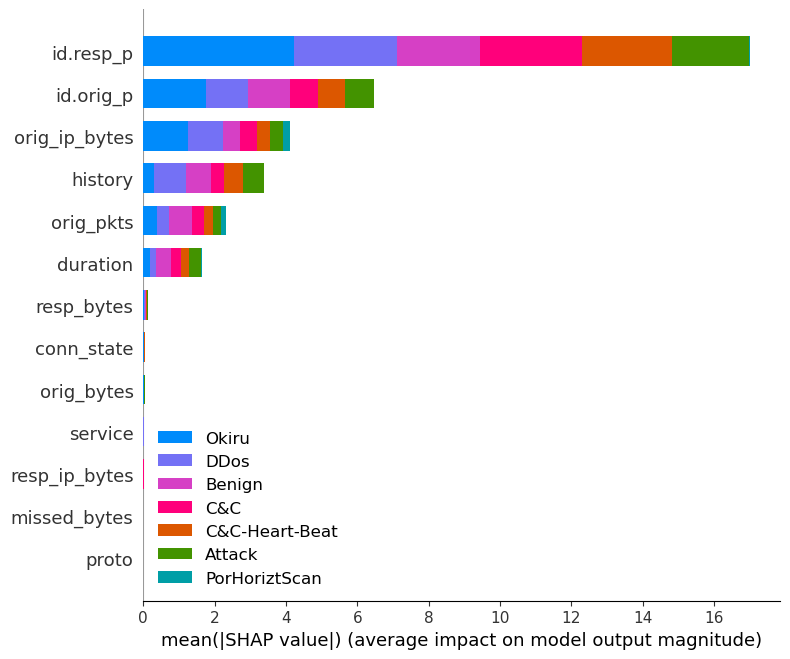

0:	learn: 0.8185428	total: 39.6ms	remaining: 3.92s
1:	learn: 3.8773863	total: 78.8ms	remaining: 3.86s
2:	learn: 349.5895039	total: 121ms	remaining: 3.93s
3:	learn: 1618.8135204	total: 164ms	remaining: 3.94s
4:	learn: 14745.3751593	total: 207ms	remaining: 3.94s
5:	learn: 10467.6650839	total: 240ms	remaining: 3.76s
6:	learn: 22561.3295923	total: 263ms	remaining: 3.5s
7:	learn: 17014.8388478	total: 286ms	remaining: 3.29s
8:	learn: 17693.2531081	total: 308ms	remaining: 3.11s
9:	learn: 12024.4368230	total: 328ms	remaining: 2.95s
10:	learn: 25041.5642975	total: 350ms	remaining: 2.83s
11:	learn: 20654.1928634	total: 371ms	remaining: 2.72s
12:	learn: 11017.1437076	total: 392ms	remaining: 2.63s
13:	learn: 7884.5901117	total: 420ms	remaining: 2.58s
14:	learn: 11666.0938639	total: 441ms	remaining: 2.5s
15:	learn: 3984.6130163	total: 462ms	remaining: 2.42s
16:	learn: 9494.3450705	total: 482ms	remaining: 2.35s
17:	learn: 6635.1606979	total: 503ms	remaining: 2.29s
18:	learn: 7532.4961743	total: 524m

61:	learn: 408.4147405	total: 3.57s	remaining: 2.19s
62:	learn: 399.0592063	total: 3.59s	remaining: 2.11s
63:	learn: 1173.4382313	total: 3.61s	remaining: 2.03s
64:	learn: 697.6347506	total: 3.63s	remaining: 1.96s
65:	learn: 597.3293414	total: 3.65s	remaining: 1.88s
66:	learn: 418.1801867	total: 3.68s	remaining: 1.81s
67:	learn: 848.4322023	total: 3.7s	remaining: 1.74s
68:	learn: 503.2599050	total: 3.72s	remaining: 1.67s
69:	learn: 499.1154771	total: 3.75s	remaining: 1.6s
70:	learn: 493.7101965	total: 3.77s	remaining: 1.54s
71:	learn: 489.9847144	total: 3.79s	remaining: 1.48s
72:	learn: 487.7337804	total: 3.81s	remaining: 1.41s
73:	learn: 486.0432522	total: 3.83s	remaining: 1.35s
74:	learn: 479.8823186	total: 3.86s	remaining: 1.28s
75:	learn: 475.9968589	total: 3.88s	remaining: 1.22s
76:	learn: 484.0255697	total: 3.9s	remaining: 1.16s
77:	learn: 834.9482656	total: 3.92s	remaining: 1.1s
78:	learn: 596.3205348	total: 3.94s	remaining: 1.05s
79:	learn: 590.0492921	total: 3.96s	remaining: 99

16:	learn: 7630.2282909	total: 467ms	remaining: 2.28s
17:	learn: 7250.7822799	total: 489ms	remaining: 2.23s
18:	learn: 6637.3648217	total: 509ms	remaining: 2.17s
19:	learn: 4797.8323799	total: 530ms	remaining: 2.12s
20:	learn: 5438.9356766	total: 552ms	remaining: 2.07s
21:	learn: 4007.7888746	total: 572ms	remaining: 2.03s
22:	learn: 2847.0697986	total: 594ms	remaining: 1.99s
23:	learn: 2750.2283428	total: 615ms	remaining: 1.95s
24:	learn: 2983.3347632	total: 636ms	remaining: 1.91s
25:	learn: 6787.0094567	total: 658ms	remaining: 1.87s
26:	learn: 6794.1838619	total: 681ms	remaining: 1.84s
27:	learn: 5688.2023686	total: 703ms	remaining: 1.81s
28:	learn: 5558.6300081	total: 723ms	remaining: 1.77s
29:	learn: 5118.3895662	total: 743ms	remaining: 1.73s
30:	learn: 5567.8307466	total: 763ms	remaining: 1.7s
31:	learn: 6752.3258733	total: 785ms	remaining: 1.67s
32:	learn: 4778.5930120	total: 806ms	remaining: 1.64s
33:	learn: 4358.5065293	total: 827ms	remaining: 1.6s
34:	learn: 3944.1462796	total:

77:	learn: 1199.5467021	total: 2.09s	remaining: 590ms
78:	learn: 785.8928862	total: 2.11s	remaining: 562ms
79:	learn: 810.9385797	total: 2.14s	remaining: 535ms
80:	learn: 710.8780560	total: 2.16s	remaining: 507ms
81:	learn: 1070.4933853	total: 2.19s	remaining: 480ms
82:	learn: 833.7115705	total: 2.21s	remaining: 453ms
83:	learn: 704.4368053	total: 2.23s	remaining: 426ms
84:	learn: 654.6615657	total: 2.26s	remaining: 398ms
85:	learn: 664.5071285	total: 2.28s	remaining: 371ms
86:	learn: 841.5054639	total: 2.3s	remaining: 344ms
87:	learn: 803.3850331	total: 2.32s	remaining: 317ms
88:	learn: 682.5430321	total: 2.35s	remaining: 290ms
89:	learn: 718.7000544	total: 2.37s	remaining: 264ms
90:	learn: 787.3074153	total: 2.39s	remaining: 237ms
91:	learn: 718.9354170	total: 2.42s	remaining: 210ms
92:	learn: 689.8173971	total: 2.44s	remaining: 183ms
93:	learn: 860.0575038	total: 2.46s	remaining: 157ms
94:	learn: 744.3635746	total: 2.48s	remaining: 131ms
95:	learn: 663.2409470	total: 2.5s	remaining:

40:	learn: 0.2190669	total: 7.04s	remaining: 10.1s
41:	learn: 0.2145029	total: 7.06s	remaining: 9.75s
42:	learn: 0.2100619	total: 7.08s	remaining: 9.39s
43:	learn: 0.2048874	total: 7.11s	remaining: 9.05s
44:	learn: 0.2011822	total: 7.13s	remaining: 8.71s
45:	learn: 0.1984615	total: 7.15s	remaining: 8.39s
46:	learn: 0.1950495	total: 7.17s	remaining: 8.09s
47:	learn: 0.1915506	total: 7.21s	remaining: 7.81s
48:	learn: 0.1889234	total: 7.23s	remaining: 7.53s
49:	learn: 0.1859811	total: 7.26s	remaining: 7.26s
50:	learn: 0.1797682	total: 7.28s	remaining: 7s
51:	learn: 0.1771302	total: 7.31s	remaining: 6.75s
52:	learn: 0.1720954	total: 7.33s	remaining: 6.5s
53:	learn: 0.1697693	total: 7.35s	remaining: 6.26s
54:	learn: 0.1665645	total: 7.37s	remaining: 6.03s
55:	learn: 0.1650638	total: 7.39s	remaining: 5.81s
56:	learn: 0.1630491	total: 7.42s	remaining: 5.59s
57:	learn: 0.1611140	total: 7.44s	remaining: 5.38s
58:	learn: 0.1567260	total: 7.46s	remaining: 5.18s
59:	learn: 0.1528708	total: 7.48s	r

2:	learn: 1.1863387	total: 2.02s	remaining: 1m 5s
3:	learn: 1.0709395	total: 2.59s	remaining: 1m 2s
4:	learn: 0.9807084	total: 3.2s	remaining: 1m
5:	learn: 0.9082387	total: 3.68s	remaining: 57.7s
6:	learn: 0.8487107	total: 4.22s	remaining: 56.1s
7:	learn: 0.7968909	total: 4.55s	remaining: 52.4s
8:	learn: 0.7514729	total: 5.07s	remaining: 51.2s
9:	learn: 0.7122098	total: 5.76s	remaining: 51.8s
10:	learn: 0.6754113	total: 5.98s	remaining: 48.4s
11:	learn: 0.6446206	total: 6.32s	remaining: 46.3s
12:	learn: 0.6187189	total: 6.41s	remaining: 42.9s
13:	learn: 0.5933899	total: 6.44s	remaining: 39.5s
14:	learn: 0.5664983	total: 6.46s	remaining: 36.6s
15:	learn: 0.5477659	total: 6.5s	remaining: 34.1s
16:	learn: 0.5112119	total: 6.53s	remaining: 31.9s
17:	learn: 0.4803351	total: 6.56s	remaining: 29.9s
18:	learn: 0.4603330	total: 6.58s	remaining: 28.1s
19:	learn: 0.4363319	total: 6.61s	remaining: 26.4s
20:	learn: 0.4209690	total: 6.64s	remaining: 25s
21:	learn: 0.4019528	total: 6.66s	remaining: 2

70:	learn: 0.1291168	total: 7.68s	remaining: 3.14s
71:	learn: 0.1279077	total: 7.7s	remaining: 3s
72:	learn: 0.1256673	total: 7.72s	remaining: 2.86s
73:	learn: 0.1247281	total: 7.74s	remaining: 2.72s
74:	learn: 0.1229717	total: 7.76s	remaining: 2.59s
75:	learn: 0.1211670	total: 7.79s	remaining: 2.46s
76:	learn: 0.1203138	total: 7.81s	remaining: 2.33s
77:	learn: 0.1193352	total: 7.83s	remaining: 2.21s
78:	learn: 0.1176906	total: 7.85s	remaining: 2.09s
79:	learn: 0.1157233	total: 7.87s	remaining: 1.97s
80:	learn: 0.1136290	total: 7.89s	remaining: 1.85s
81:	learn: 0.1127819	total: 7.91s	remaining: 1.74s
82:	learn: 0.1120819	total: 7.93s	remaining: 1.63s
83:	learn: 0.1102994	total: 7.96s	remaining: 1.51s
84:	learn: 0.1088922	total: 7.98s	remaining: 1.41s
85:	learn: 0.1082481	total: 8s	remaining: 1.3s
86:	learn: 0.1067324	total: 8.02s	remaining: 1.2s
87:	learn: 0.1051112	total: 8.05s	remaining: 1.1s
88:	learn: 0.1033934	total: 8.09s	remaining: 1s
89:	learn: 0.1021685	total: 8.11s	remaining:

41:	learn: 1.1034941	total: 4.32s	remaining: 5.97s
42:	learn: 1.0935387	total: 4.34s	remaining: 5.76s
43:	learn: 1.0834288	total: 4.36s	remaining: 5.55s
44:	learn: 1.0738956	total: 4.39s	remaining: 5.36s
45:	learn: 1.0642060	total: 4.41s	remaining: 5.18s
46:	learn: 1.0547415	total: 4.43s	remaining: 5s
47:	learn: 1.0457896	total: 4.45s	remaining: 4.83s
48:	learn: 1.0370416	total: 4.48s	remaining: 4.66s
49:	learn: 1.0281336	total: 4.5s	remaining: 4.5s
50:	learn: 1.0194104	total: 4.52s	remaining: 4.34s
51:	learn: 1.0111559	total: 4.54s	remaining: 4.2s
52:	learn: 1.0027818	total: 4.57s	remaining: 4.05s
53:	learn: 0.9945735	total: 4.59s	remaining: 3.91s
54:	learn: 0.9865380	total: 4.62s	remaining: 3.78s
55:	learn: 0.9786598	total: 4.64s	remaining: 3.65s
56:	learn: 0.9711608	total: 4.66s	remaining: 3.52s
57:	learn: 0.9635815	total: 4.68s	remaining: 3.39s
58:	learn: 0.9563569	total: 4.71s	remaining: 3.27s
59:	learn: 0.9492714	total: 4.73s	remaining: 3.15s
60:	learn: 0.9420927	total: 4.75s	rem

5:	learn: 1.7281119	total: 350ms	remaining: 5.48s
6:	learn: 1.6977258	total: 370ms	remaining: 4.92s
7:	learn: 1.6687273	total: 391ms	remaining: 4.49s
8:	learn: 1.6410149	total: 412ms	remaining: 4.16s
9:	learn: 1.6144697	total: 432ms	remaining: 3.89s
10:	learn: 1.5892212	total: 453ms	remaining: 3.66s
11:	learn: 1.5647781	total: 474ms	remaining: 3.47s
12:	learn: 1.5412809	total: 494ms	remaining: 3.31s
13:	learn: 1.5186701	total: 515ms	remaining: 3.16s
14:	learn: 1.4970619	total: 536ms	remaining: 3.04s
15:	learn: 1.4760533	total: 556ms	remaining: 2.92s
16:	learn: 1.4557735	total: 578ms	remaining: 2.82s
17:	learn: 1.4361943	total: 598ms	remaining: 2.73s
18:	learn: 1.4174057	total: 620ms	remaining: 2.64s
19:	learn: 1.3990786	total: 640ms	remaining: 2.56s
20:	learn: 1.3813323	total: 662ms	remaining: 2.49s
21:	learn: 1.3642743	total: 684ms	remaining: 2.42s
22:	learn: 1.3475634	total: 704ms	remaining: 2.36s
23:	learn: 1.3313503	total: 725ms	remaining: 2.29s
24:	learn: 1.3156064	total: 745ms	re

68:	learn: 0.8902126	total: 1.56s	remaining: 702ms
69:	learn: 0.8840916	total: 1.58s	remaining: 678ms
70:	learn: 0.8780796	total: 1.6s	remaining: 655ms
71:	learn: 0.8721721	total: 1.63s	remaining: 632ms
72:	learn: 0.8663692	total: 1.65s	remaining: 609ms
73:	learn: 0.8608163	total: 1.67s	remaining: 586ms
74:	learn: 0.8553593	total: 1.69s	remaining: 563ms
75:	learn: 0.8498301	total: 1.71s	remaining: 540ms
76:	learn: 0.8443963	total: 1.73s	remaining: 517ms
77:	learn: 0.8391993	total: 1.75s	remaining: 494ms
78:	learn: 0.8339364	total: 1.77s	remaining: 471ms
79:	learn: 0.8289016	total: 1.8s	remaining: 449ms
80:	learn: 0.8238038	total: 1.82s	remaining: 427ms
81:	learn: 0.8189289	total: 1.84s	remaining: 404ms
82:	learn: 0.8139887	total: 1.86s	remaining: 381ms
83:	learn: 0.8092653	total: 1.88s	remaining: 359ms
84:	learn: 0.8044768	total: 1.9s	remaining: 336ms
85:	learn: 0.7997611	total: 1.93s	remaining: 313ms
86:	learn: 0.7949770	total: 1.95s	remaining: 291ms
87:	learn: 0.7902862	total: 1.97s	

30:	learn: 192.5570138	total: 1.04s	remaining: 2.31s
31:	learn: 234.9651737	total: 1.06s	remaining: 2.26s
32:	learn: 635.2003980	total: 1.09s	remaining: 2.21s
33:	learn: 300.5478503	total: 1.12s	remaining: 2.17s
34:	learn: 351.8084562	total: 1.14s	remaining: 2.13s
35:	learn: 422.9922144	total: 1.19s	remaining: 2.11s
36:	learn: 2070.2408186	total: 1.21s	remaining: 2.06s
37:	learn: 791.8907813	total: 1.24s	remaining: 2.02s
38:	learn: 772.8295069	total: 1.26s	remaining: 1.98s
39:	learn: 424.3417780	total: 1.29s	remaining: 1.94s
40:	learn: 314.0690297	total: 1.32s	remaining: 1.9s
41:	learn: 297.7203812	total: 1.34s	remaining: 1.86s
42:	learn: 240.0151774	total: 1.37s	remaining: 1.82s
43:	learn: 220.2959082	total: 1.4s	remaining: 1.78s
44:	learn: 205.5216467	total: 1.43s	remaining: 1.75s
45:	learn: 199.1141531	total: 1.46s	remaining: 1.71s
46:	learn: 197.6393973	total: 1.48s	remaining: 1.67s
47:	learn: 215.0965355	total: 1.51s	remaining: 1.64s
48:	learn: 344.2042292	total: 1.54s	remaining: 

86:	learn: 203.2528528	total: 2.45s	remaining: 366ms
87:	learn: 195.4662542	total: 2.47s	remaining: 337ms
88:	learn: 115.7552140	total: 2.5s	remaining: 309ms
89:	learn: 167.9605594	total: 2.53s	remaining: 281ms
90:	learn: 302.0960531	total: 2.56s	remaining: 253ms
91:	learn: 192.4893989	total: 2.58s	remaining: 225ms
92:	learn: 88.6467026	total: 2.61s	remaining: 196ms
93:	learn: 570.3332591	total: 2.63s	remaining: 168ms
94:	learn: 413.5782549	total: 2.66s	remaining: 140ms
95:	learn: 235.9309920	total: 2.69s	remaining: 112ms
96:	learn: 216.2655447	total: 2.71s	remaining: 83.9ms
97:	learn: 165.1937655	total: 2.74s	remaining: 56ms
98:	learn: 113.7177939	total: 2.77s	remaining: 28ms
99:	learn: 134.8673164	total: 2.8s	remaining: 0us
0:	learn: 0.4817018	total: 39.5ms	remaining: 3.91s
1:	learn: 8.1073106	total: 80.2ms	remaining: 3.93s
2:	learn: 1853.6424284	total: 123ms	remaining: 3.97s
3:	learn: 1583.5360415	total: 169ms	remaining: 4.04s
4:	learn: 2406.0335543	total: 212ms	remaining: 4.02s
5:	

47:	learn: 221.2074403	total: 1.46s	remaining: 1.58s
48:	learn: 468.6287685	total: 1.48s	remaining: 1.54s
49:	learn: 192.0754199	total: 1.51s	remaining: 1.51s
50:	learn: 215.9768185	total: 1.53s	remaining: 1.47s
51:	learn: 203.8909674	total: 1.56s	remaining: 1.44s
52:	learn: 179.8243823	total: 1.59s	remaining: 1.41s
53:	learn: 126.7372365	total: 1.61s	remaining: 1.37s
54:	learn: 184.5965316	total: 1.64s	remaining: 1.34s
55:	learn: 294.4139418	total: 1.67s	remaining: 1.31s
56:	learn: 200.1145748	total: 1.69s	remaining: 1.28s
57:	learn: 164.5027457	total: 1.72s	remaining: 1.25s
58:	learn: 103.7132297	total: 1.75s	remaining: 1.21s
59:	learn: 139.7614055	total: 1.77s	remaining: 1.18s
60:	learn: 311.3757267	total: 1.8s	remaining: 1.15s
61:	learn: 218.3801993	total: 1.83s	remaining: 1.12s
62:	learn: 164.8340185	total: 1.85s	remaining: 1.09s
63:	learn: 140.4916439	total: 1.88s	remaining: 1.06s
64:	learn: 746.1102418	total: 1.9s	remaining: 1.02s
65:	learn: 467.2051364	total: 1.93s	remaining: 9

14:	learn: 0.3736703	total: 484ms	remaining: 2.74s
15:	learn: 0.3423404	total: 510ms	remaining: 2.68s
16:	learn: 0.3158226	total: 537ms	remaining: 2.62s
17:	learn: 0.2931349	total: 563ms	remaining: 2.57s
18:	learn: 0.2735853	total: 591ms	remaining: 2.52s
19:	learn: 0.2562780	total: 617ms	remaining: 2.47s
20:	learn: 0.2406612	total: 644ms	remaining: 2.42s
21:	learn: 0.2270031	total: 672ms	remaining: 2.38s
22:	learn: 0.2145954	total: 698ms	remaining: 2.34s
23:	learn: 0.2037529	total: 727ms	remaining: 2.3s
24:	learn: 0.1935663	total: 752ms	remaining: 2.26s
25:	learn: 0.1846944	total: 778ms	remaining: 2.21s
26:	learn: 0.1763080	total: 804ms	remaining: 2.17s
27:	learn: 0.1677765	total: 831ms	remaining: 2.14s
28:	learn: 0.1605557	total: 858ms	remaining: 2.1s
29:	learn: 0.1540615	total: 883ms	remaining: 2.06s
30:	learn: 0.1481920	total: 909ms	remaining: 2.02s
31:	learn: 0.1403772	total: 936ms	remaining: 1.99s
32:	learn: 0.1344065	total: 960ms	remaining: 1.95s
33:	learn: 0.1300077	total: 984ms

80:	learn: 0.0456684	total: 2.19s	remaining: 514ms
81:	learn: 0.0448645	total: 2.22s	remaining: 487ms
82:	learn: 0.0444561	total: 2.25s	remaining: 460ms
83:	learn: 0.0439776	total: 2.27s	remaining: 433ms
84:	learn: 0.0434149	total: 2.3s	remaining: 406ms
85:	learn: 0.0429145	total: 2.33s	remaining: 379ms
86:	learn: 0.0423453	total: 2.35s	remaining: 351ms
87:	learn: 0.0419728	total: 2.38s	remaining: 324ms
88:	learn: 0.0414496	total: 2.41s	remaining: 297ms
89:	learn: 0.0411774	total: 2.43s	remaining: 270ms
90:	learn: 0.0406974	total: 2.46s	remaining: 243ms
91:	learn: 0.0402089	total: 2.48s	remaining: 216ms
92:	learn: 0.0399416	total: 2.51s	remaining: 189ms
93:	learn: 0.0396868	total: 2.53s	remaining: 162ms
94:	learn: 0.0392993	total: 2.56s	remaining: 135ms
95:	learn: 0.0390106	total: 2.58s	remaining: 108ms
96:	learn: 0.0387842	total: 2.61s	remaining: 80.7ms
97:	learn: 0.0385155	total: 2.63s	remaining: 53.8ms
98:	learn: 0.0380973	total: 2.66s	remaining: 26.9ms
99:	learn: 0.0378549	total: 2

47:	learn: 0.0854669	total: 1.35s	remaining: 1.47s
48:	learn: 0.0837233	total: 1.38s	remaining: 1.44s
49:	learn: 0.0816801	total: 1.41s	remaining: 1.41s
50:	learn: 0.0792895	total: 1.44s	remaining: 1.38s
51:	learn: 0.0771585	total: 1.46s	remaining: 1.35s
52:	learn: 0.0753290	total: 1.49s	remaining: 1.32s
53:	learn: 0.0737459	total: 1.52s	remaining: 1.29s
54:	learn: 0.0722292	total: 1.54s	remaining: 1.26s
55:	learn: 0.0705212	total: 1.57s	remaining: 1.23s
56:	learn: 0.0691473	total: 1.59s	remaining: 1.2s
57:	learn: 0.0681126	total: 1.62s	remaining: 1.17s
58:	learn: 0.0669232	total: 1.65s	remaining: 1.14s
59:	learn: 0.0658698	total: 1.67s	remaining: 1.11s
60:	learn: 0.0646086	total: 1.7s	remaining: 1.08s
61:	learn: 0.0634750	total: 1.72s	remaining: 1.06s
62:	learn: 0.0626869	total: 1.75s	remaining: 1.03s
63:	learn: 0.0582158	total: 1.77s	remaining: 999ms
64:	learn: 0.0572825	total: 1.8s	remaining: 972ms
65:	learn: 0.0565969	total: 1.83s	remaining: 944ms
66:	learn: 0.0556329	total: 1.86s	

14:	learn: 1.4502632	total: 477ms	remaining: 2.71s
15:	learn: 1.4272063	total: 504ms	remaining: 2.64s
16:	learn: 1.4050166	total: 528ms	remaining: 2.58s
17:	learn: 1.3836053	total: 554ms	remaining: 2.52s
18:	learn: 1.3628037	total: 581ms	remaining: 2.48s
19:	learn: 1.3426922	total: 609ms	remaining: 2.44s
20:	learn: 1.3232229	total: 636ms	remaining: 2.39s
21:	learn: 1.3044337	total: 661ms	remaining: 2.34s
22:	learn: 1.2861378	total: 688ms	remaining: 2.3s
23:	learn: 1.2681403	total: 717ms	remaining: 2.27s
24:	learn: 1.2509088	total: 743ms	remaining: 2.23s
25:	learn: 1.2342340	total: 768ms	remaining: 2.19s
26:	learn: 1.2180497	total: 793ms	remaining: 2.14s
27:	learn: 1.2020258	total: 819ms	remaining: 2.11s
28:	learn: 1.1864412	total: 845ms	remaining: 2.07s
29:	learn: 1.1715407	total: 871ms	remaining: 2.03s
30:	learn: 1.1568854	total: 895ms	remaining: 1.99s
31:	learn: 1.1424866	total: 921ms	remaining: 1.96s
32:	learn: 1.1284548	total: 947ms	remaining: 1.92s
33:	learn: 1.1150293	total: 972m

79:	learn: 0.7100795	total: 2.14s	remaining: 534ms
80:	learn: 0.7039756	total: 2.16s	remaining: 507ms
81:	learn: 0.6980246	total: 2.19s	remaining: 480ms
82:	learn: 0.6919890	total: 2.22s	remaining: 454ms
83:	learn: 0.6865341	total: 2.24s	remaining: 427ms
84:	learn: 0.6808448	total: 2.27s	remaining: 400ms
85:	learn: 0.6752517	total: 2.29s	remaining: 374ms
86:	learn: 0.6697308	total: 2.32s	remaining: 347ms
87:	learn: 0.6641495	total: 2.35s	remaining: 320ms
88:	learn: 0.6585971	total: 2.38s	remaining: 294ms
89:	learn: 0.6535918	total: 2.4s	remaining: 267ms
90:	learn: 0.6484041	total: 2.43s	remaining: 240ms
91:	learn: 0.6430896	total: 2.45s	remaining: 213ms
92:	learn: 0.6380691	total: 2.48s	remaining: 187ms
93:	learn: 0.6333380	total: 2.5s	remaining: 160ms
94:	learn: 0.6284652	total: 2.53s	remaining: 133ms
95:	learn: 0.6236416	total: 2.56s	remaining: 106ms
96:	learn: 0.6188998	total: 2.58s	remaining: 79.9ms
97:	learn: 0.6140772	total: 2.61s	remaining: 53.3ms
98:	learn: 0.6096521	total: 2.6

48:	learn: 0.9452195	total: 1.5s	remaining: 1.56s
49:	learn: 0.9356875	total: 1.52s	remaining: 1.52s
50:	learn: 0.9263140	total: 1.55s	remaining: 1.49s
51:	learn: 0.9173557	total: 1.57s	remaining: 1.45s
52:	learn: 0.9083483	total: 1.6s	remaining: 1.42s
53:	learn: 0.8995570	total: 1.62s	remaining: 1.38s
54:	learn: 0.8908962	total: 1.65s	remaining: 1.35s
55:	learn: 0.8824027	total: 1.67s	remaining: 1.31s
56:	learn: 0.8740750	total: 1.7s	remaining: 1.28s
57:	learn: 0.8659224	total: 1.73s	remaining: 1.25s
58:	learn: 0.8580993	total: 1.75s	remaining: 1.22s
59:	learn: 0.8500814	total: 1.78s	remaining: 1.19s
60:	learn: 0.8423445	total: 1.8s	remaining: 1.15s
61:	learn: 0.8349533	total: 1.83s	remaining: 1.12s
62:	learn: 0.8274925	total: 1.86s	remaining: 1.09s
63:	learn: 0.8203636	total: 1.88s	remaining: 1.06s
64:	learn: 0.8130069	total: 1.91s	remaining: 1.03s
65:	learn: 0.8061268	total: 1.93s	remaining: 995ms
66:	learn: 0.7990211	total: 1.96s	remaining: 965ms
67:	learn: 0.7914319	total: 1.98s	r

8:	learn: 23.9397380	total: 531ms	remaining: 5.36s
9:	learn: 45.9584740	total: 576ms	remaining: 5.19s
10:	learn: 55.4179702	total: 625ms	remaining: 5.05s
11:	learn: 37.1822699	total: 671ms	remaining: 4.92s
12:	learn: 28.7768401	total: 717ms	remaining: 4.8s
13:	learn: 10.5823618	total: 765ms	remaining: 4.7s
14:	learn: 54.2214790	total: 812ms	remaining: 4.6s
15:	learn: 41.8375910	total: 858ms	remaining: 4.5s
16:	learn: 27.2173494	total: 905ms	remaining: 4.42s
17:	learn: 21.9017425	total: 951ms	remaining: 4.33s
18:	learn: 19.2396136	total: 998ms	remaining: 4.26s
19:	learn: 15.1457605	total: 1.04s	remaining: 4.18s
20:	learn: 14.6663180	total: 1.09s	remaining: 4.1s
21:	learn: 13.7527273	total: 1.14s	remaining: 4.03s
22:	learn: 26.7915287	total: 1.19s	remaining: 3.97s
23:	learn: 37.0715023	total: 1.23s	remaining: 3.9s
24:	learn: 63.8974960	total: 1.28s	remaining: 3.83s
25:	learn: 42.4022282	total: 1.32s	remaining: 3.77s
26:	learn: 20.8814403	total: 1.37s	remaining: 3.71s
27:	learn: 26.820023

70:	learn: 17.6212238	total: 3.6s	remaining: 1.47s
71:	learn: 16.0146388	total: 3.65s	remaining: 1.42s
72:	learn: 14.6378841	total: 3.7s	remaining: 1.37s
73:	learn: 33.2669053	total: 3.74s	remaining: 1.31s
74:	learn: 46.4232551	total: 3.79s	remaining: 1.26s
75:	learn: 33.8059165	total: 3.84s	remaining: 1.21s
76:	learn: 34.8099813	total: 3.88s	remaining: 1.16s
77:	learn: 38.7211188	total: 3.93s	remaining: 1.11s
78:	learn: 32.3916087	total: 3.98s	remaining: 1.06s
79:	learn: 14.2988243	total: 4.03s	remaining: 1.01s
80:	learn: 19.8831082	total: 4.07s	remaining: 956ms
81:	learn: 31.6524353	total: 4.12s	remaining: 905ms
82:	learn: 16.2780451	total: 4.17s	remaining: 854ms
83:	learn: 13.8063210	total: 4.21s	remaining: 803ms
84:	learn: 40.2034937	total: 4.26s	remaining: 752ms
85:	learn: 64.0728759	total: 4.31s	remaining: 701ms
86:	learn: 46.3691216	total: 4.36s	remaining: 651ms
87:	learn: 49.5441100	total: 4.4s	remaining: 600ms
88:	learn: 13.6395574	total: 4.45s	remaining: 550ms
89:	learn: 20.1

33:	learn: 26.1060819	total: 1.81s	remaining: 3.51s
34:	learn: 15.0529890	total: 1.86s	remaining: 3.46s
35:	learn: 38.0133105	total: 1.91s	remaining: 3.39s
36:	learn: 30.0547369	total: 1.96s	remaining: 3.33s
37:	learn: 30.1376720	total: 2s	remaining: 3.27s
38:	learn: 52.7064468	total: 2.05s	remaining: 3.21s
39:	learn: 49.5573301	total: 2.1s	remaining: 3.15s
40:	learn: 47.4681974	total: 2.15s	remaining: 3.09s
41:	learn: 42.7591979	total: 2.2s	remaining: 3.04s
42:	learn: 32.1658203	total: 2.25s	remaining: 2.98s
43:	learn: 26.4054661	total: 2.3s	remaining: 2.92s
44:	learn: 37.0648166	total: 2.35s	remaining: 2.87s
45:	learn: 54.3648098	total: 2.4s	remaining: 2.81s
46:	learn: 32.9130900	total: 2.44s	remaining: 2.75s
47:	learn: 40.1686217	total: 2.49s	remaining: 2.7s
48:	learn: 34.4101755	total: 2.54s	remaining: 2.65s
49:	learn: 61.3704549	total: 2.59s	remaining: 2.59s
50:	learn: 33.4278656	total: 2.64s	remaining: 2.53s
51:	learn: 48.3118078	total: 2.68s	remaining: 2.48s
52:	learn: 64.582345

95:	learn: 0.0254953	total: 4.59s	remaining: 191ms
96:	learn: 0.0253979	total: 4.63s	remaining: 143ms
97:	learn: 0.0253507	total: 4.67s	remaining: 95.4ms
98:	learn: 0.0252686	total: 4.72s	remaining: 47.7ms
99:	learn: 0.0252051	total: 4.77s	remaining: 0us
0:	learn: 1.4433673	total: 267ms	remaining: 26.4s
1:	learn: 1.1798151	total: 308ms	remaining: 15.1s
2:	learn: 0.9975289	total: 352ms	remaining: 11.4s
3:	learn: 0.8639534	total: 395ms	remaining: 9.49s
4:	learn: 0.7572479	total: 440ms	remaining: 8.36s
5:	learn: 0.6715083	total: 486ms	remaining: 7.62s
6:	learn: 0.6004677	total: 530ms	remaining: 7.04s
7:	learn: 0.5408316	total: 575ms	remaining: 6.61s
8:	learn: 0.4906902	total: 620ms	remaining: 6.27s
9:	learn: 0.4471813	total: 665ms	remaining: 5.99s
10:	learn: 0.4094643	total: 711ms	remaining: 5.75s
11:	learn: 0.3742045	total: 755ms	remaining: 5.54s
12:	learn: 0.3454549	total: 800ms	remaining: 5.36s
13:	learn: 0.3203042	total: 845ms	remaining: 5.19s
14:	learn: 0.2987835	total: 893ms	remaini

59:	learn: 0.0318380	total: 3.09s	remaining: 2.06s
60:	learn: 0.0314545	total: 3.13s	remaining: 2s
61:	learn: 0.0311258	total: 3.17s	remaining: 1.95s
62:	learn: 0.0307924	total: 3.22s	remaining: 1.89s
63:	learn: 0.0304273	total: 3.26s	remaining: 1.84s
64:	learn: 0.0300999	total: 3.3s	remaining: 1.78s
65:	learn: 0.0297267	total: 3.35s	remaining: 1.73s
66:	learn: 0.0294709	total: 3.4s	remaining: 1.67s
67:	learn: 0.0293592	total: 3.44s	remaining: 1.62s
68:	learn: 0.0291767	total: 3.48s	remaining: 1.56s
69:	learn: 0.0288384	total: 3.53s	remaining: 1.51s
70:	learn: 0.0286843	total: 3.57s	remaining: 1.46s
71:	learn: 0.0284884	total: 3.62s	remaining: 1.41s
72:	learn: 0.0281981	total: 3.66s	remaining: 1.35s
73:	learn: 0.0279668	total: 3.71s	remaining: 1.3s
74:	learn: 0.0278401	total: 3.75s	remaining: 1.25s
75:	learn: 0.0276670	total: 3.79s	remaining: 1.2s
76:	learn: 0.0275635	total: 3.83s	remaining: 1.15s
77:	learn: 0.0274048	total: 3.88s	remaining: 1.09s
78:	learn: 0.0272402	total: 3.92s	rema

24:	learn: 0.1288686	total: 1.36s	remaining: 4.09s
25:	learn: 0.1204918	total: 1.41s	remaining: 4.02s
26:	learn: 0.1129839	total: 1.46s	remaining: 3.94s
27:	learn: 0.1063360	total: 1.5s	remaining: 3.86s
28:	learn: 0.0958133	total: 1.54s	remaining: 3.78s
29:	learn: 0.0896396	total: 1.59s	remaining: 3.71s
30:	learn: 0.0842189	total: 1.64s	remaining: 3.65s
31:	learn: 0.0794099	total: 1.69s	remaining: 3.58s
32:	learn: 0.0752662	total: 1.74s	remaining: 3.52s
33:	learn: 0.0716179	total: 1.79s	remaining: 3.47s
34:	learn: 0.0680117	total: 1.83s	remaining: 3.41s
35:	learn: 0.0641787	total: 1.88s	remaining: 3.35s
36:	learn: 0.0609976	total: 1.93s	remaining: 3.28s
37:	learn: 0.0582172	total: 1.97s	remaining: 3.22s
38:	learn: 0.0557439	total: 2.02s	remaining: 3.16s
39:	learn: 0.0535294	total: 2.07s	remaining: 3.1s
40:	learn: 0.0515135	total: 2.11s	remaining: 3.04s
41:	learn: 0.0497556	total: 2.16s	remaining: 2.98s
42:	learn: 0.0482370	total: 2.2s	remaining: 2.92s
43:	learn: 0.0466705	total: 2.25s	

89:	learn: 0.5271632	total: 4.26s	remaining: 473ms
90:	learn: 0.5220783	total: 4.3s	remaining: 426ms
91:	learn: 0.5170709	total: 4.35s	remaining: 378ms
92:	learn: 0.5121943	total: 4.39s	remaining: 331ms
93:	learn: 0.5073360	total: 4.44s	remaining: 283ms
94:	learn: 0.5025494	total: 4.48s	remaining: 236ms
95:	learn: 0.4978496	total: 4.53s	remaining: 189ms
96:	learn: 0.4932180	total: 4.57s	remaining: 141ms
97:	learn: 0.4886420	total: 4.62s	remaining: 94.3ms
98:	learn: 0.4841316	total: 4.66s	remaining: 47.1ms
99:	learn: 0.4796870	total: 4.71s	remaining: 0us
0:	learn: 1.8928223	total: 287ms	remaining: 28.4s
1:	learn: 1.8431602	total: 330ms	remaining: 16.2s
2:	learn: 1.7965357	total: 376ms	remaining: 12.2s
3:	learn: 1.7526142	total: 421ms	remaining: 10.1s
4:	learn: 1.7111179	total: 465ms	remaining: 8.84s
5:	learn: 1.6718164	total: 510ms	remaining: 7.99s
6:	learn: 1.6344947	total: 554ms	remaining: 7.36s
7:	learn: 1.5984911	total: 599ms	remaining: 6.88s
8:	learn: 1.5641784	total: 643ms	remaini

55:	learn: 0.7609506	total: 2.81s	remaining: 2.21s
56:	learn: 0.7516903	total: 2.86s	remaining: 2.15s
57:	learn: 0.7428318	total: 2.9s	remaining: 2.1s
58:	learn: 0.7342286	total: 2.95s	remaining: 2.05s
59:	learn: 0.7256980	total: 3s	remaining: 2s
60:	learn: 0.7171134	total: 3.04s	remaining: 1.95s
61:	learn: 0.7086859	total: 3.09s	remaining: 1.89s
62:	learn: 0.7007016	total: 3.13s	remaining: 1.84s
63:	learn: 0.6925813	total: 3.18s	remaining: 1.79s
64:	learn: 0.6846090	total: 3.22s	remaining: 1.74s
65:	learn: 0.6769728	total: 3.27s	remaining: 1.68s
66:	learn: 0.6694740	total: 3.31s	remaining: 1.63s
67:	learn: 0.6619172	total: 3.36s	remaining: 1.58s
68:	learn: 0.6546808	total: 3.4s	remaining: 1.53s
69:	learn: 0.6473853	total: 3.45s	remaining: 1.48s
70:	learn: 0.6403665	total: 3.49s	remaining: 1.43s
71:	learn: 0.6334692	total: 3.54s	remaining: 1.38s
72:	learn: 0.6265433	total: 3.59s	remaining: 1.33s
73:	learn: 0.6198787	total: 3.63s	remaining: 1.28s
74:	learn: 0.6133277	total: 3.68s	remain

20:	learn: 1.2459164	total: 1.13s	remaining: 4.24s
21:	learn: 1.2248689	total: 1.17s	remaining: 4.15s
22:	learn: 1.2046784	total: 1.22s	remaining: 4.07s
23:	learn: 1.1850913	total: 1.26s	remaining: 3.99s
24:	learn: 1.1658755	total: 1.3s	remaining: 3.92s
25:	learn: 1.1474399	total: 1.35s	remaining: 3.84s
26:	learn: 1.1293364	total: 1.39s	remaining: 3.77s
27:	learn: 1.1119131	total: 1.44s	remaining: 3.7s
28:	learn: 1.0947981	total: 1.48s	remaining: 3.63s
29:	learn: 1.0781569	total: 1.53s	remaining: 3.57s
30:	learn: 1.0621068	total: 1.57s	remaining: 3.5s
31:	learn: 1.0463300	total: 1.62s	remaining: 3.44s
32:	learn: 1.0311094	total: 1.66s	remaining: 3.38s
33:	learn: 1.0161251	total: 1.71s	remaining: 3.32s
34:	learn: 1.0016583	total: 1.75s	remaining: 3.26s
35:	learn: 0.9873914	total: 1.8s	remaining: 3.2s
36:	learn: 0.9734913	total: 1.84s	remaining: 3.14s
37:	learn: 0.9600649	total: 1.89s	remaining: 3.08s
38:	learn: 0.9469380	total: 1.94s	remaining: 3.03s
39:	learn: 0.9339872	total: 1.98s	re

82:	learn: 436.1725331	total: 3.08s	remaining: 632ms
83:	learn: 423.1920305	total: 3.12s	remaining: 594ms
84:	learn: 412.5904232	total: 3.15s	remaining: 556ms
85:	learn: 402.5182439	total: 3.19s	remaining: 519ms
86:	learn: 397.5120418	total: 3.22s	remaining: 482ms
87:	learn: 388.9095995	total: 3.26s	remaining: 444ms
88:	learn: 413.6491060	total: 3.29s	remaining: 407ms
89:	learn: 389.3973543	total: 3.33s	remaining: 370ms
90:	learn: 388.1667874	total: 3.36s	remaining: 333ms
91:	learn: 376.6934031	total: 3.4s	remaining: 296ms
92:	learn: 363.3173872	total: 3.44s	remaining: 259ms
93:	learn: 357.2276162	total: 3.47s	remaining: 221ms
94:	learn: 347.3996258	total: 3.5s	remaining: 184ms
95:	learn: 349.0572723	total: 3.54s	remaining: 148ms
96:	learn: 351.1360453	total: 3.58s	remaining: 111ms
97:	learn: 346.5823283	total: 3.61s	remaining: 73.7ms
98:	learn: 336.7949034	total: 3.65s	remaining: 36.8ms
99:	learn: 329.9337999	total: 3.68s	remaining: 0us
0:	learn: 0.3046367	total: 171ms	remaining: 16.9

40:	learn: 284.0021027	total: 1.5s	remaining: 2.15s
41:	learn: 186.4166744	total: 1.53s	remaining: 2.11s
42:	learn: 130.9284588	total: 1.56s	remaining: 2.07s
43:	learn: 274.6338312	total: 1.59s	remaining: 2.03s
44:	learn: 209.4506657	total: 1.62s	remaining: 1.98s
45:	learn: 183.8372708	total: 1.65s	remaining: 1.94s
46:	learn: 233.4547154	total: 1.68s	remaining: 1.9s
47:	learn: 372.7535678	total: 1.72s	remaining: 1.86s
48:	learn: 258.5015089	total: 1.75s	remaining: 1.82s
49:	learn: 386.8678269	total: 1.78s	remaining: 1.78s
50:	learn: 302.2024856	total: 1.81s	remaining: 1.74s
51:	learn: 248.2859139	total: 1.85s	remaining: 1.71s
52:	learn: 313.3364975	total: 1.88s	remaining: 1.67s
53:	learn: 292.9487805	total: 1.92s	remaining: 1.64s
54:	learn: 285.7694526	total: 1.95s	remaining: 1.6s
55:	learn: 360.5063589	total: 1.98s	remaining: 1.56s
56:	learn: 310.0614929	total: 2.01s	remaining: 1.52s
57:	learn: 280.1772836	total: 2.04s	remaining: 1.48s
58:	learn: 262.4659535	total: 2.08s	remaining: 1.

96:	learn: 145.7769529	total: 3.39s	remaining: 105ms
97:	learn: 111.6518884	total: 3.42s	remaining: 69.8ms
98:	learn: 132.7041451	total: 3.46s	remaining: 34.9ms
99:	learn: 180.1302325	total: 3.49s	remaining: 0us
0:	learn: 0.3259823	total: 55.2ms	remaining: 5.46s
1:	learn: 4.3650294	total: 109ms	remaining: 5.34s
2:	learn: 150.4741323	total: 163ms	remaining: 5.28s
3:	learn: 3.2683163	total: 209ms	remaining: 5.01s
4:	learn: 2.4341674	total: 243ms	remaining: 4.62s
5:	learn: 2.3193568	total: 281ms	remaining: 4.4s
6:	learn: 2.3114552	total: 315ms	remaining: 4.19s
7:	learn: 2.1408959	total: 349ms	remaining: 4.01s
8:	learn: 1.9541294	total: 381ms	remaining: 3.85s
9:	learn: 1.9092079	total: 415ms	remaining: 3.74s
10:	learn: 1.8834062	total: 450ms	remaining: 3.64s
11:	learn: 1.8336686	total: 484ms	remaining: 3.55s
12:	learn: 1.9744698	total: 518ms	remaining: 3.47s
13:	learn: 3.6316184	total: 551ms	remaining: 3.38s
14:	learn: 12.3525928	total: 586ms	remaining: 3.32s
15:	learn: 12.2749437	total: 6

57:	learn: 0.0402070	total: 2.19s	remaining: 1.59s
58:	learn: 0.0397268	total: 2.22s	remaining: 1.54s
59:	learn: 0.0391171	total: 2.26s	remaining: 1.5s
60:	learn: 0.0386696	total: 2.29s	remaining: 1.46s
61:	learn: 0.0380134	total: 2.32s	remaining: 1.42s
62:	learn: 0.0373411	total: 2.36s	remaining: 1.38s
63:	learn: 0.0370269	total: 2.39s	remaining: 1.34s
64:	learn: 0.0365652	total: 2.42s	remaining: 1.3s
65:	learn: 0.0362799	total: 2.45s	remaining: 1.26s
66:	learn: 0.0358190	total: 2.48s	remaining: 1.22s
67:	learn: 0.0354996	total: 2.51s	remaining: 1.18s
68:	learn: 0.0352432	total: 2.54s	remaining: 1.14s
69:	learn: 0.0349065	total: 2.57s	remaining: 1.1s
70:	learn: 0.0345843	total: 2.61s	remaining: 1.06s
71:	learn: 0.0343057	total: 2.63s	remaining: 1.02s
72:	learn: 0.0340227	total: 2.67s	remaining: 987ms
73:	learn: 0.0338048	total: 2.7s	remaining: 948ms
74:	learn: 0.0333489	total: 2.74s	remaining: 912ms
75:	learn: 0.0329748	total: 2.77s	remaining: 875ms
76:	learn: 0.0326323	total: 2.81s	r

24:	learn: 0.1473913	total: 1.1s	remaining: 3.3s
25:	learn: 0.1387571	total: 1.13s	remaining: 3.22s
26:	learn: 0.1232563	total: 1.17s	remaining: 3.16s
27:	learn: 0.1157825	total: 1.2s	remaining: 3.1s
28:	learn: 0.1083833	total: 1.24s	remaining: 3.04s
29:	learn: 0.1025070	total: 1.28s	remaining: 2.98s
30:	learn: 0.0974196	total: 1.31s	remaining: 2.92s
31:	learn: 0.0918404	total: 1.34s	remaining: 2.86s
32:	learn: 0.0870295	total: 1.38s	remaining: 2.8s
33:	learn: 0.0832467	total: 1.41s	remaining: 2.74s
34:	learn: 0.0792945	total: 1.44s	remaining: 2.68s
35:	learn: 0.0757882	total: 1.48s	remaining: 2.63s
36:	learn: 0.0725125	total: 1.51s	remaining: 2.57s
37:	learn: 0.0695799	total: 1.54s	remaining: 2.52s
38:	learn: 0.0668915	total: 1.58s	remaining: 2.47s
39:	learn: 0.0646175	total: 1.61s	remaining: 2.42s
40:	learn: 0.0625632	total: 1.64s	remaining: 2.36s
41:	learn: 0.0605428	total: 1.67s	remaining: 2.31s
42:	learn: 0.0583635	total: 1.71s	remaining: 2.26s
43:	learn: 0.0560638	total: 1.74s	re

86:	learn: 0.0301078	total: 2.97s	remaining: 444ms
87:	learn: 0.0299087	total: 3s	remaining: 410ms
88:	learn: 0.0297420	total: 3.03s	remaining: 375ms
89:	learn: 0.0296592	total: 3.06s	remaining: 340ms
90:	learn: 0.0295162	total: 3.1s	remaining: 306ms
91:	learn: 0.0293938	total: 3.13s	remaining: 272ms
92:	learn: 0.0292340	total: 3.16s	remaining: 238ms
93:	learn: 0.0291629	total: 3.19s	remaining: 204ms
94:	learn: 0.0290963	total: 3.22s	remaining: 169ms
95:	learn: 0.0289727	total: 3.25s	remaining: 135ms
96:	learn: 0.0288560	total: 3.28s	remaining: 102ms
97:	learn: 0.0286543	total: 3.31s	remaining: 67.7ms
98:	learn: 0.0283271	total: 3.35s	remaining: 33.8ms
99:	learn: 0.0281707	total: 3.38s	remaining: 0us
0:	learn: 1.4758680	total: 200ms	remaining: 19.8s
1:	learn: 1.2260683	total: 233ms	remaining: 11.4s
2:	learn: 1.0437205	total: 266ms	remaining: 8.59s
3:	learn: 0.9100107	total: 298ms	remaining: 7.16s
4:	learn: 0.7989779	total: 330ms	remaining: 6.26s
5:	learn: 0.7130685	total: 363ms	remaini

54:	learn: 0.8114787	total: 2.01s	remaining: 1.64s
55:	learn: 0.8022079	total: 2.04s	remaining: 1.6s
56:	learn: 0.7931740	total: 2.08s	remaining: 1.57s
57:	learn: 0.7843075	total: 2.11s	remaining: 1.53s
58:	learn: 0.7755794	total: 2.15s	remaining: 1.49s
59:	learn: 0.7670639	total: 2.18s	remaining: 1.45s
60:	learn: 0.7586821	total: 2.21s	remaining: 1.42s
61:	learn: 0.7503936	total: 2.25s	remaining: 1.38s
62:	learn: 0.7423737	total: 2.28s	remaining: 1.34s
63:	learn: 0.7342865	total: 2.31s	remaining: 1.3s
64:	learn: 0.7265518	total: 2.35s	remaining: 1.26s
65:	learn: 0.7189628	total: 2.38s	remaining: 1.23s
66:	learn: 0.7114110	total: 2.41s	remaining: 1.19s
67:	learn: 0.7040726	total: 2.45s	remaining: 1.15s
68:	learn: 0.6969000	total: 2.48s	remaining: 1.11s
69:	learn: 0.6897582	total: 2.52s	remaining: 1.08s
70:	learn: 0.6828151	total: 2.55s	remaining: 1.04s
71:	learn: 0.6760144	total: 2.58s	remaining: 1s
72:	learn: 0.6693506	total: 2.61s	remaining: 966ms
73:	learn: 0.6628050	total: 2.64s	re

16:	learn: 1.3697483	total: 685ms	remaining: 3.34s
17:	learn: 1.3471740	total: 718ms	remaining: 3.27s
18:	learn: 1.3244586	total: 752ms	remaining: 3.2s
19:	learn: 1.3033464	total: 785ms	remaining: 3.14s
20:	learn: 1.2820532	total: 819ms	remaining: 3.08s
21:	learn: 1.2614587	total: 853ms	remaining: 3.02s
22:	learn: 1.2422425	total: 885ms	remaining: 2.96s
23:	learn: 1.2236015	total: 918ms	remaining: 2.91s
24:	learn: 1.2047586	total: 952ms	remaining: 2.86s
25:	learn: 1.1864848	total: 989ms	remaining: 2.81s
26:	learn: 1.1684141	total: 1.02s	remaining: 2.76s
27:	learn: 1.1511283	total: 1.05s	remaining: 2.71s
28:	learn: 1.1340374	total: 1.08s	remaining: 2.66s
29:	learn: 1.1176488	total: 1.12s	remaining: 2.61s
30:	learn: 1.1014744	total: 1.15s	remaining: 2.56s
31:	learn: 1.0859084	total: 1.19s	remaining: 2.52s
32:	learn: 1.0707603	total: 1.22s	remaining: 2.48s
33:	learn: 1.0557660	total: 1.26s	remaining: 2.44s
34:	learn: 1.0411706	total: 1.29s	remaining: 2.4s
35:	learn: 1.0270660	total: 1.33s

84:	learn: 0.5954754	total: 2.92s	remaining: 515ms
85:	learn: 0.5900900	total: 2.95s	remaining: 480ms
86:	learn: 0.5847952	total: 2.98s	remaining: 446ms
87:	learn: 0.5791824	total: 3.02s	remaining: 411ms
88:	learn: 0.5736329	total: 3.05s	remaining: 377ms
89:	learn: 0.5681756	total: 3.08s	remaining: 343ms
90:	learn: 0.5628099	total: 3.12s	remaining: 309ms
91:	learn: 0.5575590	total: 3.16s	remaining: 275ms
92:	learn: 0.5527088	total: 3.19s	remaining: 240ms
93:	learn: 0.5475847	total: 3.23s	remaining: 206ms
94:	learn: 0.5425886	total: 3.26s	remaining: 172ms
95:	learn: 0.5379441	total: 3.29s	remaining: 137ms
96:	learn: 0.5333627	total: 3.32s	remaining: 103ms
97:	learn: 0.5285336	total: 3.36s	remaining: 68.6ms
98:	learn: 0.5239843	total: 3.39s	remaining: 34.3ms
99:	learn: 0.5192710	total: 3.42s	remaining: 0us
0:	learn: 1.8962735	total: 201ms	remaining: 19.9s
1:	learn: 1.8495152	total: 257ms	remaining: 12.6s
2:	learn: 1.8055429	total: 289ms	remaining: 9.34s
3:	learn: 1.7640647	total: 321ms	r

46:	learn: 0.0410422	total: 2.73s	remaining: 3.08s
47:	learn: 0.0398291	total: 2.78s	remaining: 3.02s
48:	learn: 0.0387683	total: 2.84s	remaining: 2.96s
49:	learn: 0.0378643	total: 2.89s	remaining: 2.89s
50:	learn: 0.0369078	total: 2.95s	remaining: 2.83s
51:	learn: 0.0360369	total: 3s	remaining: 2.77s
52:	learn: 0.0352034	total: 3.05s	remaining: 2.71s
53:	learn: 0.0345369	total: 3.11s	remaining: 2.65s
54:	learn: 0.0338193	total: 3.16s	remaining: 2.58s
55:	learn: 0.0331935	total: 3.21s	remaining: 2.52s
56:	learn: 0.0326774	total: 3.26s	remaining: 2.46s
57:	learn: 0.0321676	total: 3.31s	remaining: 2.4s
58:	learn: 0.0316831	total: 3.37s	remaining: 2.34s
59:	learn: 0.0312430	total: 3.42s	remaining: 2.28s
60:	learn: 0.0308508	total: 3.47s	remaining: 2.22s
61:	learn: 0.0304036	total: 3.52s	remaining: 2.16s
62:	learn: 0.0300368	total: 3.58s	remaining: 2.1s
63:	learn: 0.0296090	total: 3.63s	remaining: 2.04s
64:	learn: 0.0293444	total: 3.68s	remaining: 1.98s
65:	learn: 0.0290167	total: 3.73s	re

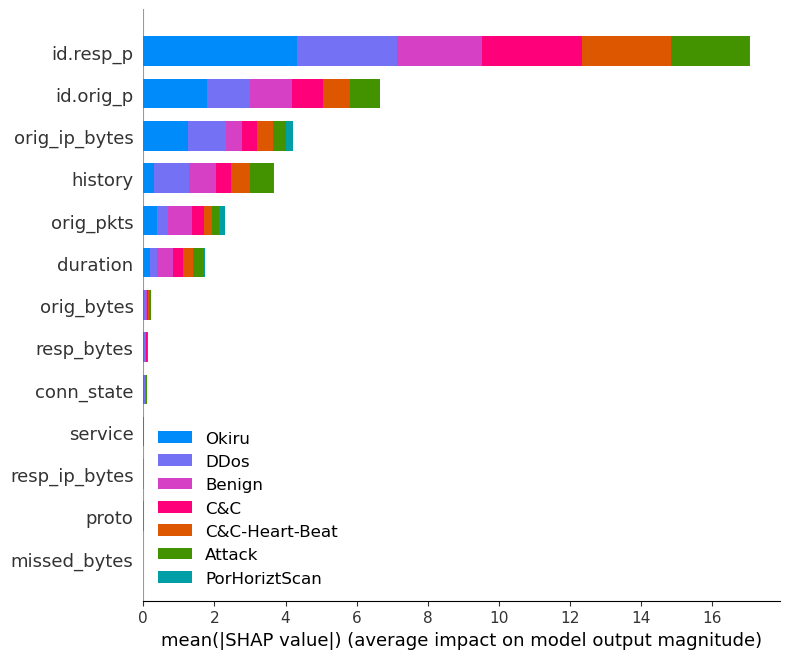

0:	learn: 0.8186970	total: 139ms	remaining: 13.8s
1:	learn: 3.8902948	total: 219ms	remaining: 10.8s
2:	learn: 357.8610537	total: 240ms	remaining: 7.75s
3:	learn: 1685.6333056	total: 260ms	remaining: 6.23s
4:	learn: 13664.4262144	total: 281ms	remaining: 5.33s
5:	learn: 9421.5564838	total: 303ms	remaining: 4.74s
6:	learn: 21583.7243140	total: 325ms	remaining: 4.32s
7:	learn: 9341.9296378	total: 346ms	remaining: 3.98s
8:	learn: 8197.1408781	total: 368ms	remaining: 3.72s
9:	learn: 8964.3506127	total: 390ms	remaining: 3.51s
10:	learn: 8745.4349345	total: 412ms	remaining: 3.33s
11:	learn: 6042.3708825	total: 432ms	remaining: 3.17s
12:	learn: 4141.5047732	total: 452ms	remaining: 3.03s
13:	learn: 4633.2987356	total: 472ms	remaining: 2.9s
14:	learn: 3861.0885098	total: 493ms	remaining: 2.79s
15:	learn: 2638.3165673	total: 516ms	remaining: 2.71s
16:	learn: 4247.2411106	total: 537ms	remaining: 2.62s
17:	learn: 21412.2295393	total: 557ms	remaining: 2.54s
18:	learn: 3751.6015965	total: 579ms	remain

56:	learn: 992.5198750	total: 1.32s	remaining: 995ms
57:	learn: 1098.9553784	total: 1.34s	remaining: 971ms
58:	learn: 1160.2808952	total: 1.36s	remaining: 946ms
59:	learn: 745.3396126	total: 1.38s	remaining: 921ms
60:	learn: 874.7216077	total: 1.4s	remaining: 898ms
61:	learn: 871.4946448	total: 1.43s	remaining: 874ms
62:	learn: 856.4121792	total: 1.45s	remaining: 849ms
63:	learn: 774.8779942	total: 1.47s	remaining: 825ms
64:	learn: 733.3212248	total: 1.49s	remaining: 801ms
65:	learn: 750.4156966	total: 1.51s	remaining: 777ms
66:	learn: 726.3617535	total: 1.53s	remaining: 752ms
67:	learn: 828.5253523	total: 1.55s	remaining: 729ms
68:	learn: 1064.1667442	total: 1.57s	remaining: 706ms
69:	learn: 957.2874433	total: 1.59s	remaining: 683ms
70:	learn: 849.5213092	total: 1.61s	remaining: 659ms
71:	learn: 684.2898164	total: 1.63s	remaining: 636ms
72:	learn: 885.6269369	total: 1.66s	remaining: 612ms
73:	learn: 906.1039880	total: 1.68s	remaining: 589ms
74:	learn: 719.2681254	total: 1.7s	remaining

20:	learn: 5447.1933034	total: 569ms	remaining: 2.14s
21:	learn: 4025.6476332	total: 590ms	remaining: 2.09s
22:	learn: 2869.1988652	total: 612ms	remaining: 2.05s
23:	learn: 2777.5187722	total: 635ms	remaining: 2.01s
24:	learn: 2904.0652006	total: 655ms	remaining: 1.96s
25:	learn: 6474.3997724	total: 676ms	remaining: 1.92s
26:	learn: 6827.9653143	total: 698ms	remaining: 1.89s
27:	learn: 5723.8008201	total: 720ms	remaining: 1.85s
28:	learn: 5578.7438171	total: 741ms	remaining: 1.81s
29:	learn: 5139.7820863	total: 761ms	remaining: 1.78s
30:	learn: 5623.4505236	total: 783ms	remaining: 1.74s
31:	learn: 6766.2316483	total: 804ms	remaining: 1.71s
32:	learn: 4807.1588297	total: 826ms	remaining: 1.68s
33:	learn: 4388.4438185	total: 847ms	remaining: 1.64s
34:	learn: 3975.3243450	total: 867ms	remaining: 1.61s
35:	learn: 3554.2197114	total: 888ms	remaining: 1.58s
36:	learn: 3282.2114564	total: 910ms	remaining: 1.55s
37:	learn: 2417.8318650	total: 932ms	remaining: 1.52s
38:	learn: 2125.5407553	tota

80:	learn: 1382.1216076	total: 1.79s	remaining: 420ms
81:	learn: 1352.9693217	total: 1.81s	remaining: 397ms
82:	learn: 1351.7047325	total: 1.83s	remaining: 375ms
83:	learn: 1242.2838390	total: 1.85s	remaining: 352ms
84:	learn: 1475.5631818	total: 1.87s	remaining: 330ms
85:	learn: 1567.8805535	total: 1.89s	remaining: 308ms
86:	learn: 1262.5748623	total: 1.91s	remaining: 285ms
87:	learn: 1567.4281035	total: 1.93s	remaining: 263ms
88:	learn: 992.2167759	total: 1.95s	remaining: 241ms
89:	learn: 923.6652097	total: 1.97s	remaining: 219ms
90:	learn: 868.1765436	total: 2s	remaining: 197ms
91:	learn: 810.8145990	total: 2.02s	remaining: 175ms
92:	learn: 841.8495086	total: 2.04s	remaining: 153ms
93:	learn: 920.8286061	total: 2.06s	remaining: 131ms
94:	learn: 923.9193321	total: 2.08s	remaining: 110ms
95:	learn: 826.2308479	total: 2.1s	remaining: 87.6ms
96:	learn: 732.1091451	total: 2.13s	remaining: 65.7ms
97:	learn: 957.4884044	total: 2.15s	remaining: 43.8ms
98:	learn: 894.8607759	total: 2.17s	rem

46:	learn: 0.1959969	total: 1.08s	remaining: 1.22s
47:	learn: 0.1926217	total: 1.1s	remaining: 1.2s
48:	learn: 0.1896693	total: 1.13s	remaining: 1.17s
49:	learn: 0.1870587	total: 1.15s	remaining: 1.15s
50:	learn: 0.1839163	total: 1.17s	remaining: 1.12s
51:	learn: 0.1777625	total: 1.19s	remaining: 1.1s
52:	learn: 0.1752339	total: 1.22s	remaining: 1.08s
53:	learn: 0.1720187	total: 1.24s	remaining: 1.05s
54:	learn: 0.1670631	total: 1.26s	remaining: 1.03s
55:	learn: 0.1648712	total: 1.28s	remaining: 1.01s
56:	learn: 0.1607900	total: 1.31s	remaining: 986ms
57:	learn: 0.1588446	total: 1.33s	remaining: 962ms
58:	learn: 0.1542558	total: 1.35s	remaining: 940ms
59:	learn: 0.1513361	total: 1.37s	remaining: 916ms
60:	learn: 0.1496289	total: 1.4s	remaining: 892ms
61:	learn: 0.1478613	total: 1.42s	remaining: 868ms
62:	learn: 0.1463781	total: 1.44s	remaining: 844ms
63:	learn: 0.1431572	total: 1.46s	remaining: 820ms
64:	learn: 0.1394343	total: 1.48s	remaining: 797ms
65:	learn: 0.1381002	total: 1.5s	re

15:	learn: 0.5477315	total: 447ms	remaining: 2.35s
16:	learn: 0.5111853	total: 471ms	remaining: 2.3s
17:	learn: 0.4803684	total: 493ms	remaining: 2.25s
18:	learn: 0.4603669	total: 516ms	remaining: 2.2s
19:	learn: 0.4363640	total: 538ms	remaining: 2.15s
20:	learn: 0.4209984	total: 560ms	remaining: 2.1s
21:	learn: 0.4019570	total: 584ms	remaining: 2.07s
22:	learn: 0.3898968	total: 606ms	remaining: 2.03s
23:	learn: 0.3688047	total: 629ms	remaining: 1.99s
24:	learn: 0.3582924	total: 651ms	remaining: 1.95s
25:	learn: 0.3412592	total: 676ms	remaining: 1.92s
26:	learn: 0.3272073	total: 697ms	remaining: 1.88s
27:	learn: 0.3131236	total: 719ms	remaining: 1.85s
28:	learn: 0.3029086	total: 741ms	remaining: 1.81s
29:	learn: 0.2946182	total: 766ms	remaining: 1.79s
30:	learn: 0.2837097	total: 787ms	remaining: 1.75s
31:	learn: 0.2754972	total: 809ms	remaining: 1.72s
32:	learn: 0.2671383	total: 830ms	remaining: 1.69s
33:	learn: 0.2588699	total: 853ms	remaining: 1.66s
34:	learn: 0.2515932	total: 874ms	

83:	learn: 0.1131191	total: 2.07s	remaining: 395ms
84:	learn: 0.1123078	total: 2.1s	remaining: 370ms
85:	learn: 0.1108845	total: 2.12s	remaining: 345ms
86:	learn: 0.1093609	total: 2.14s	remaining: 320ms
87:	learn: 0.1073934	total: 2.16s	remaining: 295ms
88:	learn: 0.1067201	total: 2.19s	remaining: 270ms
89:	learn: 0.1060698	total: 2.21s	remaining: 245ms
90:	learn: 0.1044179	total: 2.23s	remaining: 221ms
91:	learn: 0.1038244	total: 2.25s	remaining: 196ms
92:	learn: 0.1025582	total: 2.27s	remaining: 171ms
93:	learn: 0.1011568	total: 2.29s	remaining: 147ms
94:	learn: 0.0994397	total: 2.32s	remaining: 122ms
95:	learn: 0.0984832	total: 2.34s	remaining: 97.4ms
96:	learn: 0.0979423	total: 2.36s	remaining: 73ms
97:	learn: 0.0964645	total: 2.38s	remaining: 48.6ms
98:	learn: 0.0951982	total: 2.4s	remaining: 24.3ms
99:	learn: 0.0940585	total: 2.42s	remaining: 0us
0:	learn: 1.9057878	total: 35.6ms	remaining: 3.52s
1:	learn: 1.8662623	total: 72.7ms	remaining: 3.56s
2:	learn: 1.8289446	total: 108ms	

46:	learn: 1.0549537	total: 1.11s	remaining: 1.25s
47:	learn: 1.0456944	total: 1.13s	remaining: 1.23s
48:	learn: 1.0366378	total: 1.16s	remaining: 1.2s
49:	learn: 1.0280353	total: 1.18s	remaining: 1.18s
50:	learn: 1.0196124	total: 1.2s	remaining: 1.15s
51:	learn: 1.0113775	total: 1.22s	remaining: 1.13s
52:	learn: 1.0029941	total: 1.24s	remaining: 1.1s
53:	learn: 0.9947899	total: 1.26s	remaining: 1.08s
54:	learn: 0.9870076	total: 1.29s	remaining: 1.05s
55:	learn: 0.9791084	total: 1.31s	remaining: 1.03s
56:	learn: 0.9713720	total: 1.33s	remaining: 1s
57:	learn: 0.9637910	total: 1.35s	remaining: 979ms
58:	learn: 0.9565679	total: 1.37s	remaining: 955ms
59:	learn: 0.9494838	total: 1.4s	remaining: 931ms
60:	learn: 0.9423018	total: 1.42s	remaining: 907ms
61:	learn: 0.9352581	total: 1.44s	remaining: 883ms
62:	learn: 0.9285573	total: 1.46s	remaining: 859ms
63:	learn: 0.9217627	total: 1.49s	remaining: 835ms
64:	learn: 0.9150925	total: 1.51s	remaining: 811ms
65:	learn: 0.9085475	total: 1.53s	rema

17:	learn: 1.4363164	total: 469ms	remaining: 2.13s
18:	learn: 1.4175328	total: 490ms	remaining: 2.09s
19:	learn: 1.3992082	total: 511ms	remaining: 2.04s
20:	learn: 1.3816039	total: 532ms	remaining: 2s
21:	learn: 1.3643669	total: 554ms	remaining: 1.96s
22:	learn: 1.3477279	total: 575ms	remaining: 1.93s
23:	learn: 1.3315092	total: 597ms	remaining: 1.89s
24:	learn: 1.3157689	total: 620ms	remaining: 1.86s
25:	learn: 1.3004799	total: 642ms	remaining: 1.83s
26:	learn: 1.2857723	total: 664ms	remaining: 1.79s
27:	learn: 1.2713224	total: 686ms	remaining: 1.76s
28:	learn: 1.2573290	total: 708ms	remaining: 1.73s
29:	learn: 1.2436479	total: 729ms	remaining: 1.7s
30:	learn: 1.2304648	total: 751ms	remaining: 1.67s
31:	learn: 1.2174899	total: 773ms	remaining: 1.64s
32:	learn: 1.2048464	total: 795ms	remaining: 1.61s
33:	learn: 1.1926438	total: 818ms	remaining: 1.59s
34:	learn: 1.1806232	total: 839ms	remaining: 1.56s
35:	learn: 1.1688956	total: 861ms	remaining: 1.53s
36:	learn: 1.1574540	total: 883ms	r

87:	learn: 0.7911972	total: 1.99s	remaining: 271ms
88:	learn: 0.7863263	total: 2.01s	remaining: 248ms
89:	learn: 0.7815655	total: 2.03s	remaining: 226ms
90:	learn: 0.7768300	total: 2.05s	remaining: 203ms
91:	learn: 0.7721713	total: 2.08s	remaining: 181ms
92:	learn: 0.7675988	total: 2.1s	remaining: 158ms
93:	learn: 0.7630684	total: 2.12s	remaining: 135ms
94:	learn: 0.7586263	total: 2.14s	remaining: 113ms
95:	learn: 0.7542154	total: 2.17s	remaining: 90.3ms
96:	learn: 0.7498752	total: 2.19s	remaining: 67.7ms
97:	learn: 0.7456051	total: 2.21s	remaining: 45.1ms
98:	learn: 0.7413812	total: 2.23s	remaining: 22.6ms
99:	learn: 0.7372225	total: 2.25s	remaining: 0us
0:	learn: 0.4819847	total: 44ms	remaining: 4.36s
1:	learn: 8.0543811	total: 88ms	remaining: 4.31s
2:	learn: 1845.3933047	total: 133ms	remaining: 4.31s
3:	learn: 1593.9774804	total: 181ms	remaining: 4.34s
4:	learn: 2442.8372124	total: 217ms	remaining: 4.13s
5:	learn: 1726.8456145	total: 246ms	remaining: 3.86s
6:	learn: 1950.9337371	tot

47:	learn: 222.2298465	total: 1.49s	remaining: 1.61s
48:	learn: 397.0328015	total: 1.52s	remaining: 1.58s
49:	learn: 256.7045656	total: 1.54s	remaining: 1.54s
50:	learn: 292.4986490	total: 1.57s	remaining: 1.51s
51:	learn: 295.9533947	total: 1.6s	remaining: 1.48s
52:	learn: 289.2945129	total: 1.63s	remaining: 1.45s
53:	learn: 257.0281722	total: 1.66s	remaining: 1.41s
54:	learn: 334.7741058	total: 1.69s	remaining: 1.38s
55:	learn: 266.3892789	total: 1.72s	remaining: 1.35s
56:	learn: 239.0906861	total: 1.74s	remaining: 1.31s
57:	learn: 512.8178858	total: 1.77s	remaining: 1.28s
58:	learn: 318.2603225	total: 1.8s	remaining: 1.25s
59:	learn: 226.1091106	total: 1.83s	remaining: 1.22s
60:	learn: 221.8864591	total: 1.86s	remaining: 1.19s
61:	learn: 275.9494749	total: 1.88s	remaining: 1.16s
62:	learn: 386.5636550	total: 1.91s	remaining: 1.12s
63:	learn: 245.8394730	total: 1.94s	remaining: 1.09s
64:	learn: 231.0875537	total: 1.97s	remaining: 1.06s
65:	learn: 201.2634311	total: 2s	remaining: 1.03

5:	learn: 1736.7032236	total: 255ms	remaining: 3.99s
6:	learn: 1321.7235550	total: 284ms	remaining: 3.77s
7:	learn: 1395.6894296	total: 311ms	remaining: 3.58s
8:	learn: 1002.9896672	total: 337ms	remaining: 3.4s
9:	learn: 741.8533635	total: 365ms	remaining: 3.28s
10:	learn: 675.8291761	total: 392ms	remaining: 3.17s
11:	learn: 374.0498047	total: 418ms	remaining: 3.07s
12:	learn: 260.0319340	total: 445ms	remaining: 2.98s
13:	learn: 402.6641486	total: 472ms	remaining: 2.9s
14:	learn: 415.5904345	total: 499ms	remaining: 2.83s
15:	learn: 321.2811339	total: 527ms	remaining: 2.76s
16:	learn: 266.9547955	total: 554ms	remaining: 2.71s
17:	learn: 231.1232657	total: 582ms	remaining: 2.65s
18:	learn: 366.8836372	total: 610ms	remaining: 2.6s
19:	learn: 327.6290703	total: 638ms	remaining: 2.55s
20:	learn: 276.0760126	total: 665ms	remaining: 2.5s
21:	learn: 263.3101713	total: 693ms	remaining: 2.46s
22:	learn: 304.8289435	total: 721ms	remaining: 2.41s
23:	learn: 362.8850001	total: 750ms	remaining: 2.38

62:	learn: 254.5352487	total: 1.89s	remaining: 1.11s
63:	learn: 247.2697616	total: 1.91s	remaining: 1.07s
64:	learn: 744.8759036	total: 1.94s	remaining: 1.04s
65:	learn: 473.1498068	total: 1.96s	remaining: 1.01s
66:	learn: 342.8177097	total: 1.99s	remaining: 980ms
67:	learn: 321.5650573	total: 2.02s	remaining: 949ms
68:	learn: 235.2804784	total: 2.05s	remaining: 919ms
69:	learn: 238.6703572	total: 2.07s	remaining: 889ms
70:	learn: 1044.6823481	total: 2.1s	remaining: 858ms
71:	learn: 448.7879801	total: 2.13s	remaining: 828ms
72:	learn: 550.3778067	total: 2.16s	remaining: 798ms
73:	learn: 396.3579545	total: 2.18s	remaining: 768ms
74:	learn: 326.7849147	total: 2.21s	remaining: 737ms
75:	learn: 263.1904306	total: 2.24s	remaining: 707ms
76:	learn: 329.0417996	total: 2.27s	remaining: 677ms
77:	learn: 294.3064018	total: 2.29s	remaining: 647ms
78:	learn: 224.9921571	total: 2.32s	remaining: 617ms
79:	learn: 203.3278278	total: 2.35s	remaining: 588ms
80:	learn: 355.5154170	total: 2.38s	remaining:

28:	learn: 0.1625046	total: 892ms	remaining: 2.18s
29:	learn: 0.1548070	total: 921ms	remaining: 2.15s
30:	learn: 0.1491893	total: 949ms	remaining: 2.11s
31:	learn: 0.1420615	total: 975ms	remaining: 2.07s
32:	learn: 0.1358332	total: 1s	remaining: 2.03s
33:	learn: 0.1311446	total: 1.03s	remaining: 1.99s
34:	learn: 0.1268175	total: 1.05s	remaining: 1.95s
35:	learn: 0.1218974	total: 1.08s	remaining: 1.92s
36:	learn: 0.1176601	total: 1.11s	remaining: 1.89s
37:	learn: 0.1133470	total: 1.14s	remaining: 1.85s
38:	learn: 0.1095577	total: 1.16s	remaining: 1.82s
39:	learn: 0.1058844	total: 1.19s	remaining: 1.78s
40:	learn: 0.1031136	total: 1.21s	remaining: 1.75s
41:	learn: 0.1000650	total: 1.24s	remaining: 1.71s
42:	learn: 0.0972158	total: 1.27s	remaining: 1.68s
43:	learn: 0.0940403	total: 1.3s	remaining: 1.65s
44:	learn: 0.0918448	total: 1.32s	remaining: 1.62s
45:	learn: 0.0894141	total: 1.35s	remaining: 1.58s
46:	learn: 0.0868972	total: 1.38s	remaining: 1.56s
47:	learn: 0.0847172	total: 1.41s	r

93:	learn: 0.0400256	total: 2.76s	remaining: 176ms
94:	learn: 0.0397473	total: 2.79s	remaining: 147ms
95:	learn: 0.0394732	total: 2.81s	remaining: 117ms
96:	learn: 0.0391429	total: 2.84s	remaining: 87.9ms
97:	learn: 0.0387834	total: 2.87s	remaining: 58.6ms
98:	learn: 0.0386402	total: 2.89s	remaining: 29.2ms
99:	learn: 0.0382877	total: 2.92s	remaining: 0us
0:	learn: 1.5055198	total: 43.1ms	remaining: 4.26s
1:	learn: 1.2674241	total: 84.9ms	remaining: 4.16s
2:	learn: 1.1021750	total: 125ms	remaining: 4.05s
3:	learn: 0.9811637	total: 161ms	remaining: 3.87s
4:	learn: 0.8831958	total: 198ms	remaining: 3.76s
5:	learn: 0.7977272	total: 238ms	remaining: 3.73s
6:	learn: 0.7301384	total: 277ms	remaining: 3.69s
7:	learn: 0.6679967	total: 313ms	remaining: 3.6s
8:	learn: 0.6168285	total: 340ms	remaining: 3.44s
9:	learn: 0.5728327	total: 370ms	remaining: 3.33s
10:	learn: 0.5304925	total: 397ms	remaining: 3.21s
11:	learn: 0.4970622	total: 425ms	remaining: 3.12s
12:	learn: 0.4655213	total: 454ms	remai

55:	learn: 0.0716544	total: 1.67s	remaining: 1.31s
56:	learn: 0.0702552	total: 1.7s	remaining: 1.28s
57:	learn: 0.0689016	total: 1.73s	remaining: 1.25s
58:	learn: 0.0677301	total: 1.75s	remaining: 1.22s
59:	learn: 0.0665424	total: 1.78s	remaining: 1.19s
60:	learn: 0.0655220	total: 1.81s	remaining: 1.16s
61:	learn: 0.0643887	total: 1.83s	remaining: 1.12s
62:	learn: 0.0618872	total: 1.86s	remaining: 1.09s
63:	learn: 0.0608850	total: 1.89s	remaining: 1.06s
64:	learn: 0.0599644	total: 1.91s	remaining: 1.03s
65:	learn: 0.0571482	total: 1.94s	remaining: 998ms
66:	learn: 0.0559435	total: 1.96s	remaining: 967ms
67:	learn: 0.0546207	total: 1.99s	remaining: 936ms
68:	learn: 0.0538736	total: 2.02s	remaining: 906ms
69:	learn: 0.0533332	total: 2.04s	remaining: 875ms
70:	learn: 0.0525118	total: 2.07s	remaining: 846ms
71:	learn: 0.0520113	total: 2.1s	remaining: 816ms
72:	learn: 0.0505055	total: 2.13s	remaining: 787ms
73:	learn: 0.0498796	total: 2.15s	remaining: 756ms
74:	learn: 0.0493020	total: 2.18s

24:	learn: 1.2512317	total: 801ms	remaining: 2.4s
25:	learn: 1.2342220	total: 829ms	remaining: 2.36s
26:	learn: 1.2180363	total: 855ms	remaining: 2.31s
27:	learn: 1.2021927	total: 886ms	remaining: 2.28s
28:	learn: 1.1868906	total: 912ms	remaining: 2.23s
29:	learn: 1.1718422	total: 938ms	remaining: 2.19s
30:	learn: 1.1570582	total: 965ms	remaining: 2.15s
31:	learn: 1.1425454	total: 994ms	remaining: 2.11s
32:	learn: 1.1287720	total: 1.02s	remaining: 2.07s
33:	learn: 1.1150757	total: 1.05s	remaining: 2.04s
34:	learn: 1.1019913	total: 1.08s	remaining: 2s
35:	learn: 1.0889461	total: 1.1s	remaining: 1.96s
36:	learn: 1.0764952	total: 1.13s	remaining: 1.93s
37:	learn: 1.0640552	total: 1.16s	remaining: 1.89s
38:	learn: 1.0521904	total: 1.19s	remaining: 1.85s
39:	learn: 1.0403141	total: 1.21s	remaining: 1.82s
40:	learn: 1.0287468	total: 1.24s	remaining: 1.78s
41:	learn: 1.0174026	total: 1.27s	remaining: 1.75s
42:	learn: 1.0065791	total: 1.29s	remaining: 1.71s
43:	learn: 0.9957211	total: 1.32s	re

86:	learn: 0.6716511	total: 2.52s	remaining: 377ms
87:	learn: 0.6660314	total: 2.55s	remaining: 348ms
88:	learn: 0.6609514	total: 2.58s	remaining: 319ms
89:	learn: 0.6556024	total: 2.61s	remaining: 290ms
90:	learn: 0.6503521	total: 2.64s	remaining: 261ms
91:	learn: 0.6451948	total: 2.66s	remaining: 232ms
92:	learn: 0.6403851	total: 2.69s	remaining: 203ms
93:	learn: 0.6352938	total: 2.72s	remaining: 174ms
94:	learn: 0.6303981	total: 2.75s	remaining: 145ms
95:	learn: 0.6255440	total: 2.77s	remaining: 116ms
96:	learn: 0.6209876	total: 2.8s	remaining: 86.7ms
97:	learn: 0.6160618	total: 2.83s	remaining: 57.8ms
98:	learn: 0.6116426	total: 2.86s	remaining: 28.9ms
99:	learn: 0.6070778	total: 2.88s	remaining: 0us
0:	learn: 1.8994243	total: 45.8ms	remaining: 4.53s
1:	learn: 1.8557721	total: 90.6ms	remaining: 4.44s
2:	learn: 1.8146459	total: 134ms	remaining: 4.32s
3:	learn: 1.7757801	total: 178ms	remaining: 4.26s
4:	learn: 1.7389587	total: 213ms	remaining: 4.05s
5:	learn: 1.7039837	total: 242ms	r

55:	learn: 0.8854342	total: 1.56s	remaining: 1.23s
56:	learn: 0.8771882	total: 1.59s	remaining: 1.2s
57:	learn: 0.8691010	total: 1.61s	remaining: 1.17s
58:	learn: 0.8613571	total: 1.64s	remaining: 1.14s
59:	learn: 0.8537652	total: 1.67s	remaining: 1.11s
60:	learn: 0.8461101	total: 1.69s	remaining: 1.08s
61:	learn: 0.8385987	total: 1.72s	remaining: 1.05s
62:	learn: 0.8314203	total: 1.74s	remaining: 1.02s
63:	learn: 0.8241734	total: 1.77s	remaining: 996ms
64:	learn: 0.8170577	total: 1.8s	remaining: 967ms
65:	learn: 0.8102633	total: 1.82s	remaining: 939ms
66:	learn: 0.8035939	total: 1.85s	remaining: 910ms
67:	learn: 0.7968383	total: 1.87s	remaining: 881ms
68:	learn: 0.7902850	total: 1.9s	remaining: 853ms
69:	learn: 0.7839619	total: 1.93s	remaining: 825ms
70:	learn: 0.7775440	total: 1.95s	remaining: 797ms
71:	learn: 0.7713168	total: 1.98s	remaining: 770ms
72:	learn: 0.7653137	total: 2s	remaining: 742ms
73:	learn: 0.7592947	total: 2.03s	remaining: 714ms
74:	learn: 0.7534938	total: 2.06s	rem

17:	learn: 40.7214563	total: 1.12s	remaining: 5.12s
18:	learn: 28.4287346	total: 1.17s	remaining: 5s
19:	learn: 12.9369604	total: 1.22s	remaining: 4.89s
20:	learn: 54.1763793	total: 1.27s	remaining: 4.78s
21:	learn: 80.1853396	total: 1.32s	remaining: 4.67s
22:	learn: 62.2241701	total: 1.37s	remaining: 4.58s
23:	learn: 44.9070512	total: 1.42s	remaining: 4.48s
24:	learn: 31.4660833	total: 1.46s	remaining: 4.39s
25:	learn: 34.1296637	total: 1.51s	remaining: 4.31s
26:	learn: 54.1581128	total: 1.56s	remaining: 4.22s
27:	learn: 65.4544212	total: 1.61s	remaining: 4.15s
28:	learn: 59.0657393	total: 1.66s	remaining: 4.07s
29:	learn: 56.6029399	total: 1.71s	remaining: 3.99s
30:	learn: 40.5321407	total: 1.76s	remaining: 3.91s
31:	learn: 65.4539755	total: 1.8s	remaining: 3.84s
32:	learn: 122.8994192	total: 1.85s	remaining: 3.76s
33:	learn: 1075.8105589	total: 1.9s	remaining: 3.69s
34:	learn: 3826.0537830	total: 1.95s	remaining: 3.62s
35:	learn: 2439.4709701	total: 2s	remaining: 3.55s
36:	learn: 52

75:	learn: 42.9811775	total: 3.96s	remaining: 1.25s
76:	learn: 31.6900414	total: 4.01s	remaining: 1.2s
77:	learn: 25.6308741	total: 4.06s	remaining: 1.14s
78:	learn: 30.7741014	total: 4.11s	remaining: 1.09s
79:	learn: 74.0268028	total: 4.15s	remaining: 1.04s
80:	learn: 60.1093918	total: 4.2s	remaining: 986ms
81:	learn: 38.8395963	total: 4.25s	remaining: 934ms
82:	learn: 19.1369042	total: 4.3s	remaining: 881ms
83:	learn: 31.5531502	total: 4.35s	remaining: 828ms
84:	learn: 52.7874488	total: 4.4s	remaining: 776ms
85:	learn: 54.2770921	total: 4.45s	remaining: 724ms
86:	learn: 37.6496512	total: 4.5s	remaining: 672ms
87:	learn: 32.0387224	total: 4.55s	remaining: 620ms
88:	learn: 34.5143392	total: 4.59s	remaining: 568ms
89:	learn: 56.7986069	total: 4.64s	remaining: 516ms
90:	learn: 48.4934962	total: 4.69s	remaining: 464ms
91:	learn: 32.8789244	total: 4.74s	remaining: 412ms
92:	learn: 21.3315349	total: 4.79s	remaining: 361ms
93:	learn: 48.0073508	total: 4.84s	remaining: 309ms
94:	learn: 54.517

34:	learn: 7.4777260	total: 1.95s	remaining: 3.62s
35:	learn: 16.5142651	total: 2s	remaining: 3.55s
36:	learn: 5.4184938	total: 2.04s	remaining: 3.48s
37:	learn: 17.8876576	total: 2.09s	remaining: 3.42s
38:	learn: 4.2124415	total: 2.14s	remaining: 3.35s
39:	learn: 17.6474083	total: 2.19s	remaining: 3.28s
40:	learn: 5.0911954	total: 2.23s	remaining: 3.22s
41:	learn: 17.2737096	total: 2.28s	remaining: 3.15s
42:	learn: 2.8333171	total: 2.33s	remaining: 3.09s
43:	learn: 16.1212983	total: 2.38s	remaining: 3.03s
44:	learn: 4.7068016	total: 2.43s	remaining: 2.97s
45:	learn: 19.0544590	total: 2.48s	remaining: 2.91s
46:	learn: 5.8991099	total: 2.52s	remaining: 2.85s
47:	learn: 17.0251825	total: 2.57s	remaining: 2.79s
48:	learn: 4.0868843	total: 2.62s	remaining: 2.73s
49:	learn: 17.0965841	total: 2.67s	remaining: 2.67s
50:	learn: 5.2088718	total: 2.71s	remaining: 2.61s
51:	learn: 18.2636861	total: 2.76s	remaining: 2.55s
52:	learn: 5.0217824	total: 2.81s	remaining: 2.49s
53:	learn: 15.8358606	tot

98:	learn: 0.0252927	total: 4.78s	remaining: 48.3ms
99:	learn: 0.0252163	total: 4.82s	remaining: 0us
0:	learn: 1.4433412	total: 253ms	remaining: 25s
1:	learn: 1.1797117	total: 301ms	remaining: 14.7s
2:	learn: 0.9974101	total: 347ms	remaining: 11.2s
3:	learn: 0.8621936	total: 394ms	remaining: 9.47s
4:	learn: 0.7572228	total: 440ms	remaining: 8.35s
5:	learn: 0.6713998	total: 487ms	remaining: 7.63s
6:	learn: 0.6012635	total: 534ms	remaining: 7.1s
7:	learn: 0.5401069	total: 580ms	remaining: 6.67s
8:	learn: 0.4894182	total: 628ms	remaining: 6.35s
9:	learn: 0.4458725	total: 677ms	remaining: 6.09s
10:	learn: 0.4082510	total: 727ms	remaining: 5.88s
11:	learn: 0.3731795	total: 775ms	remaining: 5.68s
12:	learn: 0.3444187	total: 823ms	remaining: 5.51s
13:	learn: 0.3201760	total: 870ms	remaining: 5.34s
14:	learn: 0.2940196	total: 918ms	remaining: 5.2s
15:	learn: 0.2718832	total: 963ms	remaining: 5.05s
16:	learn: 0.2507019	total: 1.01s	remaining: 4.93s
17:	learn: 0.2260004	total: 1.06s	remaining: 4

63:	learn: 0.0307846	total: 3.25s	remaining: 1.83s
64:	learn: 0.0304101	total: 3.3s	remaining: 1.78s
65:	learn: 0.0300948	total: 3.35s	remaining: 1.72s
66:	learn: 0.0298945	total: 3.39s	remaining: 1.67s
67:	learn: 0.0296602	total: 3.44s	remaining: 1.62s
68:	learn: 0.0294610	total: 3.48s	remaining: 1.56s
69:	learn: 0.0290444	total: 3.53s	remaining: 1.51s
70:	learn: 0.0288193	total: 3.57s	remaining: 1.46s
71:	learn: 0.0286118	total: 3.62s	remaining: 1.41s
72:	learn: 0.0284005	total: 3.66s	remaining: 1.35s
73:	learn: 0.0281144	total: 3.71s	remaining: 1.3s
74:	learn: 0.0279577	total: 3.75s	remaining: 1.25s
75:	learn: 0.0278106	total: 3.8s	remaining: 1.2s
76:	learn: 0.0276975	total: 3.85s	remaining: 1.15s
77:	learn: 0.0275864	total: 3.89s	remaining: 1.1s
78:	learn: 0.0274246	total: 3.94s	remaining: 1.05s
79:	learn: 0.0273258	total: 3.98s	remaining: 995ms
80:	learn: 0.0271576	total: 4.04s	remaining: 947ms
81:	learn: 0.0270143	total: 4.09s	remaining: 898ms
82:	learn: 0.0268510	total: 4.15s	re

25:	learn: 0.1169549	total: 1.43s	remaining: 4.06s
26:	learn: 0.1083198	total: 1.47s	remaining: 3.98s
27:	learn: 0.1005738	total: 1.52s	remaining: 3.91s
28:	learn: 0.0938537	total: 1.57s	remaining: 3.84s
29:	learn: 0.0878132	total: 1.61s	remaining: 3.77s
30:	learn: 0.0823467	total: 1.66s	remaining: 3.7s
31:	learn: 0.0772739	total: 1.71s	remaining: 3.63s
32:	learn: 0.0729282	total: 1.75s	remaining: 3.56s
33:	learn: 0.0689214	total: 1.8s	remaining: 3.5s
34:	learn: 0.0655050	total: 1.85s	remaining: 3.44s
35:	learn: 0.0623385	total: 1.9s	remaining: 3.37s
36:	learn: 0.0593190	total: 1.95s	remaining: 3.31s
37:	learn: 0.0564943	total: 2s	remaining: 3.26s
38:	learn: 0.0539208	total: 2.04s	remaining: 3.2s
39:	learn: 0.0517027	total: 2.09s	remaining: 3.14s
40:	learn: 0.0495537	total: 2.14s	remaining: 3.08s
41:	learn: 0.0476860	total: 2.19s	remaining: 3.02s
42:	learn: 0.0461128	total: 2.24s	remaining: 2.96s
43:	learn: 0.0445452	total: 2.28s	remaining: 2.9s
44:	learn: 0.0431427	total: 2.33s	remain

89:	learn: 0.5272620	total: 4.37s	remaining: 486ms
90:	learn: 0.5221959	total: 4.42s	remaining: 437ms
91:	learn: 0.5172058	total: 4.46s	remaining: 388ms
92:	learn: 0.5122768	total: 4.5s	remaining: 339ms
93:	learn: 0.5074229	total: 4.55s	remaining: 291ms
94:	learn: 0.5026419	total: 4.6s	remaining: 242ms
95:	learn: 0.4979446	total: 4.65s	remaining: 194ms
96:	learn: 0.4933450	total: 4.69s	remaining: 145ms
97:	learn: 0.4887700	total: 4.74s	remaining: 96.7ms
98:	learn: 0.4842658	total: 4.79s	remaining: 48.3ms
99:	learn: 0.4798261	total: 4.84s	remaining: 0us
0:	learn: 1.8928203	total: 216ms	remaining: 21.4s
1:	learn: 1.8431561	total: 261ms	remaining: 12.8s
2:	learn: 1.7965322	total: 306ms	remaining: 9.89s
3:	learn: 1.7526048	total: 352ms	remaining: 8.46s
4:	learn: 1.7111111	total: 399ms	remaining: 7.59s
5:	learn: 1.6718054	total: 446ms	remaining: 6.98s
6:	learn: 1.6339817	total: 492ms	remaining: 6.54s
7:	learn: 1.5984660	total: 538ms	remaining: 6.18s
8:	learn: 1.5641457	total: 584ms	remainin

54:	learn: 0.7706838	total: 2.69s	remaining: 2.2s
55:	learn: 0.7612289	total: 2.74s	remaining: 2.15s
56:	learn: 0.7519580	total: 2.79s	remaining: 2.1s
57:	learn: 0.7430957	total: 2.83s	remaining: 2.05s
58:	learn: 0.7341766	total: 2.88s	remaining: 2s
59:	learn: 0.7257292	total: 2.93s	remaining: 1.95s
60:	learn: 0.7173555	total: 2.98s	remaining: 1.9s
61:	learn: 0.7089237	total: 3.02s	remaining: 1.85s
62:	learn: 0.7006488	total: 3.07s	remaining: 1.8s
63:	learn: 0.6927310	total: 3.12s	remaining: 1.75s
64:	learn: 0.6850256	total: 3.17s	remaining: 1.7s
65:	learn: 0.6771889	total: 3.21s	remaining: 1.65s
66:	learn: 0.6694927	total: 3.26s	remaining: 1.6s
67:	learn: 0.6621228	total: 3.31s	remaining: 1.55s
68:	learn: 0.6546970	total: 3.35s	remaining: 1.51s
69:	learn: 0.6476474	total: 3.4s	remaining: 1.46s
70:	learn: 0.6404731	total: 3.45s	remaining: 1.41s
71:	learn: 0.6335694	total: 3.5s	remaining: 1.36s
72:	learn: 0.6267844	total: 3.54s	remaining: 1.31s
73:	learn: 0.6199714	total: 3.59s	remainin

20:	learn: 1.2459590	total: 1.13s	remaining: 4.26s
21:	learn: 1.2248994	total: 1.18s	remaining: 4.18s
22:	learn: 1.2049086	total: 1.23s	remaining: 4.11s
23:	learn: 1.1851133	total: 1.27s	remaining: 4.03s
24:	learn: 1.1661173	total: 1.32s	remaining: 3.95s
25:	learn: 1.1474698	total: 1.36s	remaining: 3.88s
26:	learn: 1.1295556	total: 1.41s	remaining: 3.81s
27:	learn: 1.1119481	total: 1.46s	remaining: 3.75s
28:	learn: 1.0951683	total: 1.5s	remaining: 3.68s
29:	learn: 1.0785040	total: 1.55s	remaining: 3.61s
30:	learn: 1.0624636	total: 1.59s	remaining: 3.55s
31:	learn: 1.0466678	total: 1.64s	remaining: 3.49s
32:	learn: 1.0312862	total: 1.69s	remaining: 3.43s
33:	learn: 1.0164485	total: 1.74s	remaining: 3.37s
34:	learn: 1.0018278	total: 1.78s	remaining: 3.31s
35:	learn: 0.9878257	total: 1.83s	remaining: 3.26s
36:	learn: 0.9739062	total: 1.88s	remaining: 3.21s
37:	learn: 0.9605656	total: 1.93s	remaining: 3.15s
38:	learn: 0.9472915	total: 1.98s	remaining: 3.09s
39:	learn: 0.9344618	total: 2.02

84:	learn: 252.9239635	total: 3.19s	remaining: 562ms
85:	learn: 234.2025981	total: 3.22s	remaining: 525ms
86:	learn: 228.0748575	total: 3.26s	remaining: 487ms
87:	learn: 211.9945226	total: 3.3s	remaining: 450ms
88:	learn: 328.2519940	total: 3.33s	remaining: 412ms
89:	learn: 292.4223638	total: 3.37s	remaining: 374ms
90:	learn: 267.8685170	total: 3.4s	remaining: 337ms
91:	learn: 274.2869480	total: 3.44s	remaining: 299ms
92:	learn: 331.0501812	total: 3.48s	remaining: 262ms
93:	learn: 285.5308016	total: 3.51s	remaining: 224ms
94:	learn: 251.9236888	total: 3.55s	remaining: 187ms
95:	learn: 281.7659135	total: 3.58s	remaining: 149ms
96:	learn: 218.5369344	total: 3.62s	remaining: 112ms
97:	learn: 310.6546072	total: 3.66s	remaining: 74.6ms
98:	learn: 244.7103025	total: 3.69s	remaining: 37.3ms
99:	learn: 219.1250992	total: 3.73s	remaining: 0us
0:	learn: 0.3042719	total: 231ms	remaining: 22.9s
1:	learn: 2.6450905	total: 268ms	remaining: 13.2s
2:	learn: 11.8149135	total: 303ms	remaining: 9.8s
3:	l

41:	learn: 80.1402572	total: 1.7s	remaining: 2.35s
42:	learn: 58.2296648	total: 1.74s	remaining: 2.31s
43:	learn: 69.8317718	total: 1.77s	remaining: 2.26s
44:	learn: 114.6375780	total: 1.81s	remaining: 2.21s
45:	learn: 95.6342444	total: 1.85s	remaining: 2.17s
46:	learn: 71.6821563	total: 1.88s	remaining: 2.12s
47:	learn: 59.1632851	total: 1.92s	remaining: 2.08s
48:	learn: 78.3914248	total: 1.96s	remaining: 2.04s
49:	learn: 95.8978335	total: 1.99s	remaining: 1.99s
50:	learn: 82.8509708	total: 2.03s	remaining: 1.95s
51:	learn: 84.2119131	total: 2.06s	remaining: 1.9s
52:	learn: 338.0807805	total: 2.1s	remaining: 1.86s
53:	learn: 160.2020832	total: 2.13s	remaining: 1.82s
54:	learn: 319.8383265	total: 2.17s	remaining: 1.78s
55:	learn: 166.9668437	total: 2.21s	remaining: 1.74s
56:	learn: 288.3331422	total: 2.25s	remaining: 1.7s
57:	learn: 170.5693141	total: 2.28s	remaining: 1.65s
58:	learn: 226.7601657	total: 2.32s	remaining: 1.61s
59:	learn: 217.2555742	total: 2.36s	remaining: 1.57s
60:	lea

99:	learn: 463.2857265	total: 3.53s	remaining: 0us
0:	learn: 0.3072857	total: 179ms	remaining: 17.7s
1:	learn: 2.4796429	total: 211ms	remaining: 10.3s
2:	learn: 106.1173892	total: 244ms	remaining: 7.89s
3:	learn: 4.3081700	total: 278ms	remaining: 6.67s
4:	learn: 0.5737105	total: 312ms	remaining: 5.93s
5:	learn: 0.5111207	total: 342ms	remaining: 5.36s
6:	learn: 0.5026832	total: 378ms	remaining: 5.02s
7:	learn: 0.5024646	total: 410ms	remaining: 4.72s
8:	learn: 0.5070896	total: 444ms	remaining: 4.49s
9:	learn: 0.4762442	total: 477ms	remaining: 4.29s
10:	learn: 0.4738331	total: 505ms	remaining: 4.09s
11:	learn: 0.4517699	total: 537ms	remaining: 3.94s
12:	learn: 0.4781193	total: 574ms	remaining: 3.84s
13:	learn: 0.4489581	total: 609ms	remaining: 3.74s
14:	learn: 0.4294572	total: 643ms	remaining: 3.64s
15:	learn: 0.4253082	total: 671ms	remaining: 3.52s
16:	learn: 0.4313820	total: 701ms	remaining: 3.42s
17:	learn: 0.4248999	total: 731ms	remaining: 3.33s
18:	learn: 0.4230380	total: 761ms	remai

67:	learn: 0.0358279	total: 2.57s	remaining: 1.21s
68:	learn: 0.0354709	total: 2.6s	remaining: 1.17s
69:	learn: 0.0351309	total: 2.64s	remaining: 1.13s
70:	learn: 0.0348799	total: 2.67s	remaining: 1.09s
71:	learn: 0.0346493	total: 2.7s	remaining: 1.05s
72:	learn: 0.0342750	total: 2.73s	remaining: 1.01s
73:	learn: 0.0340927	total: 2.76s	remaining: 971ms
74:	learn: 0.0338635	total: 2.8s	remaining: 932ms
75:	learn: 0.0335230	total: 2.83s	remaining: 894ms
76:	learn: 0.0331361	total: 2.86s	remaining: 855ms
77:	learn: 0.0327593	total: 2.9s	remaining: 817ms
78:	learn: 0.0324175	total: 2.94s	remaining: 780ms
79:	learn: 0.0320902	total: 2.97s	remaining: 743ms
80:	learn: 0.0318923	total: 3s	remaining: 704ms
81:	learn: 0.0316045	total: 3.04s	remaining: 666ms
82:	learn: 0.0314039	total: 3.07s	remaining: 628ms
83:	learn: 0.0312484	total: 3.1s	remaining: 590ms
84:	learn: 0.0309977	total: 3.13s	remaining: 552ms
85:	learn: 0.0308203	total: 3.16s	remaining: 514ms
86:	learn: 0.0306415	total: 3.19s	remai

33:	learn: 0.0840320	total: 1.39s	remaining: 2.71s
34:	learn: 0.0799141	total: 1.43s	remaining: 2.65s
35:	learn: 0.0759308	total: 1.46s	remaining: 2.6s
36:	learn: 0.0727746	total: 1.5s	remaining: 2.55s
37:	learn: 0.0696249	total: 1.53s	remaining: 2.5s
38:	learn: 0.0666455	total: 1.56s	remaining: 2.45s
39:	learn: 0.0640978	total: 1.6s	remaining: 2.4s
40:	learn: 0.0618815	total: 1.64s	remaining: 2.35s
41:	learn: 0.0595589	total: 1.67s	remaining: 2.31s
42:	learn: 0.0578310	total: 1.7s	remaining: 2.26s
43:	learn: 0.0558371	total: 1.74s	remaining: 2.21s
44:	learn: 0.0544825	total: 1.77s	remaining: 2.16s
45:	learn: 0.0529328	total: 1.8s	remaining: 2.12s
46:	learn: 0.0515528	total: 1.84s	remaining: 2.07s
47:	learn: 0.0503855	total: 1.87s	remaining: 2.03s
48:	learn: 0.0489759	total: 1.92s	remaining: 2s
49:	learn: 0.0475220	total: 1.96s	remaining: 1.96s
50:	learn: 0.0462370	total: 2s	remaining: 1.92s
51:	learn: 0.0451162	total: 2.03s	remaining: 1.88s
52:	learn: 0.0442977	total: 2.07s	remaining:

0:	learn: 1.4744890	total: 204ms	remaining: 20.2s
1:	learn: 1.2254885	total: 275ms	remaining: 13.5s
2:	learn: 1.0455284	total: 308ms	remaining: 9.96s
3:	learn: 0.9123531	total: 343ms	remaining: 8.24s
4:	learn: 0.8094819	total: 381ms	remaining: 7.23s
5:	learn: 0.7235039	total: 412ms	remaining: 6.45s
6:	learn: 0.6536884	total: 444ms	remaining: 5.9s
7:	learn: 0.5957806	total: 476ms	remaining: 5.47s
8:	learn: 0.5470270	total: 508ms	remaining: 5.14s
9:	learn: 0.4984806	total: 542ms	remaining: 4.88s
10:	learn: 0.4618483	total: 575ms	remaining: 4.65s
11:	learn: 0.4266000	total: 609ms	remaining: 4.47s
12:	learn: 0.3987494	total: 642ms	remaining: 4.29s
13:	learn: 0.3535877	total: 677ms	remaining: 4.16s
14:	learn: 0.3180508	total: 710ms	remaining: 4.02s
15:	learn: 0.2884746	total: 746ms	remaining: 3.91s
16:	learn: 0.2632161	total: 779ms	remaining: 3.8s
17:	learn: 0.2415088	total: 813ms	remaining: 3.7s
18:	learn: 0.2223946	total: 848ms	remaining: 3.61s
19:	learn: 0.2057699	total: 885ms	remaining:

64:	learn: 0.7270020	total: 2.35s	remaining: 1.26s
65:	learn: 0.7194822	total: 2.38s	remaining: 1.23s
66:	learn: 0.7120682	total: 2.42s	remaining: 1.19s
67:	learn: 0.7048252	total: 2.45s	remaining: 1.15s
68:	learn: 0.6976147	total: 2.48s	remaining: 1.11s
69:	learn: 0.6906353	total: 2.51s	remaining: 1.08s
70:	learn: 0.6837663	total: 2.55s	remaining: 1.04s
71:	learn: 0.6769335	total: 2.58s	remaining: 1s
72:	learn: 0.6702253	total: 2.62s	remaining: 968ms
73:	learn: 0.6637160	total: 2.65s	remaining: 931ms
74:	learn: 0.6573333	total: 2.68s	remaining: 895ms
75:	learn: 0.6505508	total: 2.72s	remaining: 858ms
76:	learn: 0.6438897	total: 2.75s	remaining: 822ms
77:	learn: 0.6378065	total: 2.79s	remaining: 786ms
78:	learn: 0.6313728	total: 2.82s	remaining: 750ms
79:	learn: 0.6250313	total: 2.86s	remaining: 714ms
80:	learn: 0.6187852	total: 2.89s	remaining: 678ms
81:	learn: 0.6126470	total: 2.93s	remaining: 642ms
82:	learn: 0.6066299	total: 2.96s	remaining: 606ms
83:	learn: 0.6007179	total: 3s	rem

32:	learn: 1.0712154	total: 1.27s	remaining: 2.58s
33:	learn: 1.0563680	total: 1.31s	remaining: 2.54s
34:	learn: 1.0417970	total: 1.34s	remaining: 2.49s
35:	learn: 1.0276372	total: 1.37s	remaining: 2.44s
36:	learn: 1.0138353	total: 1.41s	remaining: 2.4s
37:	learn: 1.0003811	total: 1.44s	remaining: 2.36s
38:	learn: 0.9871750	total: 1.48s	remaining: 2.31s
39:	learn: 0.9743265	total: 1.51s	remaining: 2.27s
40:	learn: 0.9617842	total: 1.55s	remaining: 2.23s
41:	learn: 0.9494438	total: 1.58s	remaining: 2.19s
42:	learn: 0.9374239	total: 1.62s	remaining: 2.15s
43:	learn: 0.9256262	total: 1.65s	remaining: 2.1s
44:	learn: 0.9141051	total: 1.68s	remaining: 2.06s
45:	learn: 0.9028260	total: 1.72s	remaining: 2.02s
46:	learn: 0.8917908	total: 1.76s	remaining: 1.98s
47:	learn: 0.8809701	total: 1.79s	remaining: 1.94s
48:	learn: 0.8703617	total: 1.82s	remaining: 1.9s
49:	learn: 0.8599889	total: 1.86s	remaining: 1.86s
50:	learn: 0.8498664	total: 1.9s	remaining: 1.82s
51:	learn: 0.8398784	total: 1.93s	r

99:	learn: 0.5185298	total: 3.67s	remaining: 0us
0:	learn: 1.8961284	total: 63ms	remaining: 6.24s
1:	learn: 1.8494818	total: 122ms	remaining: 5.96s
2:	learn: 1.8056059	total: 177ms	remaining: 5.72s
3:	learn: 1.7642103	total: 231ms	remaining: 5.54s
4:	learn: 1.7250499	total: 286ms	remaining: 5.44s
5:	learn: 1.6878700	total: 328ms	remaining: 5.14s
6:	learn: 1.6525472	total: 365ms	remaining: 4.86s
7:	learn: 1.6188381	total: 399ms	remaining: 4.59s
8:	learn: 1.5866673	total: 434ms	remaining: 4.39s
9:	learn: 1.5559434	total: 470ms	remaining: 4.22s
10:	learn: 1.5264873	total: 506ms	remaining: 4.09s
11:	learn: 1.4982649	total: 541ms	remaining: 3.96s
12:	learn: 1.4711275	total: 575ms	remaining: 3.85s
13:	learn: 1.4450435	total: 608ms	remaining: 3.74s
14:	learn: 1.4199306	total: 642ms	remaining: 3.64s
15:	learn: 1.3957365	total: 675ms	remaining: 3.54s
16:	learn: 1.3724219	total: 708ms	remaining: 3.45s
17:	learn: 1.3495787	total: 743ms	remaining: 3.38s
18:	learn: 1.3275235	total: 776ms	remaining:

64:	learn: 0.0298480	total: 3.77s	remaining: 2.03s
65:	learn: 0.0294891	total: 3.82s	remaining: 1.97s
66:	learn: 0.0292211	total: 3.87s	remaining: 1.91s
67:	learn: 0.0289697	total: 3.92s	remaining: 1.84s
68:	learn: 0.0287691	total: 3.98s	remaining: 1.79s
69:	learn: 0.0285402	total: 4.03s	remaining: 1.73s
70:	learn: 0.0283415	total: 4.08s	remaining: 1.67s
71:	learn: 0.0281023	total: 4.13s	remaining: 1.61s
72:	learn: 0.0278977	total: 4.18s	remaining: 1.55s
73:	learn: 0.0277417	total: 4.24s	remaining: 1.49s
74:	learn: 0.0275643	total: 4.29s	remaining: 1.43s
75:	learn: 0.0274278	total: 4.34s	remaining: 1.37s
76:	learn: 0.0272606	total: 4.39s	remaining: 1.31s
77:	learn: 0.0270831	total: 4.44s	remaining: 1.25s
78:	learn: 0.0269647	total: 4.49s	remaining: 1.19s
79:	learn: 0.0267855	total: 4.55s	remaining: 1.14s
80:	learn: 0.0265966	total: 4.61s	remaining: 1.08s
81:	learn: 0.0264550	total: 4.67s	remaining: 1.02s
82:	learn: 0.0263427	total: 4.73s	remaining: 968ms
83:	learn: 0.0262296	total: 4.7

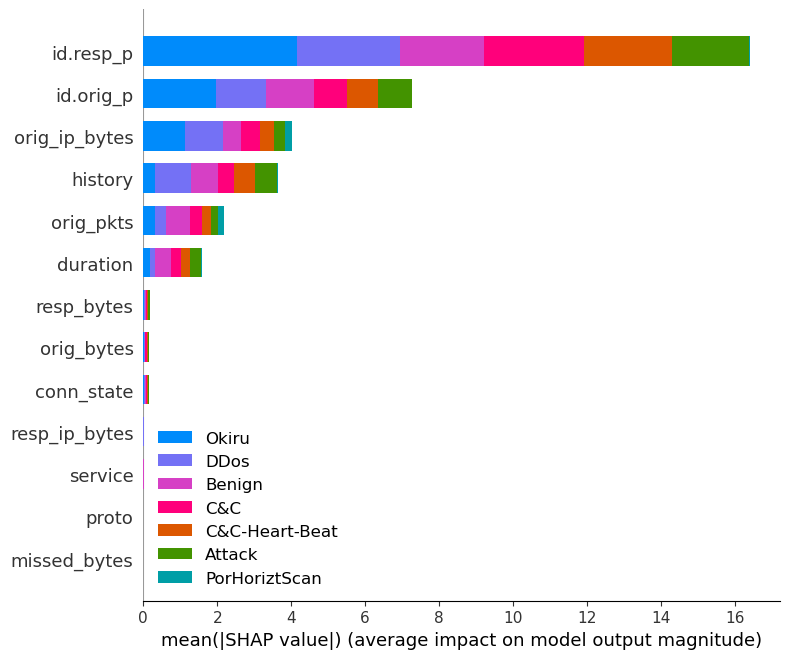

0:	learn: 0.8192482	total: 144ms	remaining: 14.3s
1:	learn: 3.8688178	total: 256ms	remaining: 12.5s
2:	learn: 355.2562413	total: 280ms	remaining: 9.04s
3:	learn: 1629.2438696	total: 302ms	remaining: 7.25s
4:	learn: 14723.7700932	total: 324ms	remaining: 6.16s
5:	learn: 10491.0781531	total: 347ms	remaining: 5.44s
6:	learn: 22488.1046585	total: 370ms	remaining: 4.92s
7:	learn: 10419.2875826	total: 393ms	remaining: 4.52s
8:	learn: 9275.6663519	total: 415ms	remaining: 4.19s
9:	learn: 10040.1334212	total: 438ms	remaining: 3.94s
10:	learn: 9809.5711317	total: 461ms	remaining: 3.73s
11:	learn: 6739.9197734	total: 482ms	remaining: 3.53s
12:	learn: 4901.4838442	total: 502ms	remaining: 3.36s
13:	learn: 4684.5282808	total: 523ms	remaining: 3.21s
14:	learn: 5515.7901422	total: 545ms	remaining: 3.09s
15:	learn: 3937.8770512	total: 566ms	remaining: 2.97s
16:	learn: 3412.7670787	total: 588ms	remaining: 2.87s
17:	learn: 2676.2765900	total: 610ms	remaining: 2.78s
18:	learn: 3149.1388390	total: 632ms	rem

61:	learn: 1866.0094859	total: 1.65s	remaining: 1.01s
62:	learn: 1822.5580927	total: 1.68s	remaining: 985ms
63:	learn: 1908.7212868	total: 1.7s	remaining: 956ms
64:	learn: 1785.0606805	total: 1.72s	remaining: 928ms
65:	learn: 1620.4699680	total: 1.75s	remaining: 899ms
66:	learn: 2111.7035124	total: 1.77s	remaining: 870ms
67:	learn: 1760.2956915	total: 1.79s	remaining: 843ms
68:	learn: 1998.6051479	total: 1.81s	remaining: 814ms
69:	learn: 1815.6492319	total: 1.83s	remaining: 786ms
70:	learn: 1199.5368722	total: 1.85s	remaining: 758ms
71:	learn: 1201.6195541	total: 1.88s	remaining: 730ms
72:	learn: 531.7437014	total: 1.9s	remaining: 703ms
73:	learn: 962.7349824	total: 1.92s	remaining: 675ms
74:	learn: 773.9561962	total: 1.94s	remaining: 648ms
75:	learn: 784.9687420	total: 1.97s	remaining: 621ms
76:	learn: 633.9075704	total: 1.99s	remaining: 594ms
77:	learn: 749.7374561	total: 2.01s	remaining: 568ms
78:	learn: 823.0103263	total: 2.03s	remaining: 541ms
79:	learn: 667.7300729	total: 2.06s	r

17:	learn: 3681.7895517	total: 468ms	remaining: 2.13s
18:	learn: 3056.2913477	total: 491ms	remaining: 2.09s
19:	learn: 3059.0475820	total: 512ms	remaining: 2.05s
20:	learn: 3118.0607335	total: 535ms	remaining: 2.01s
21:	learn: 3251.2144817	total: 556ms	remaining: 1.97s
22:	learn: 2355.5795706	total: 576ms	remaining: 1.93s
23:	learn: 2390.0909239	total: 598ms	remaining: 1.89s
24:	learn: 2867.5815089	total: 619ms	remaining: 1.86s
25:	learn: 2198.4803106	total: 641ms	remaining: 1.82s
26:	learn: 3272.2503583	total: 662ms	remaining: 1.79s
27:	learn: 2501.4489898	total: 683ms	remaining: 1.76s
28:	learn: 1987.5350767	total: 704ms	remaining: 1.72s
29:	learn: 1580.7565479	total: 725ms	remaining: 1.69s
30:	learn: 1646.7797662	total: 747ms	remaining: 1.66s
31:	learn: 1563.4110181	total: 768ms	remaining: 1.63s
32:	learn: 1340.1917643	total: 790ms	remaining: 1.6s
33:	learn: 1363.0309335	total: 811ms	remaining: 1.57s
34:	learn: 1788.9355792	total: 831ms	remaining: 1.54s
35:	learn: 1737.3576700	total

78:	learn: 772.5615987	total: 2.13s	remaining: 567ms
79:	learn: 790.9376506	total: 2.16s	remaining: 539ms
80:	learn: 754.5838630	total: 2.18s	remaining: 511ms
81:	learn: 790.7547602	total: 2.2s	remaining: 484ms
82:	learn: 4133.8883500	total: 2.23s	remaining: 456ms
83:	learn: 5557.2976598	total: 2.25s	remaining: 428ms
84:	learn: 2844.8299464	total: 2.27s	remaining: 401ms
85:	learn: 2734.8038748	total: 2.29s	remaining: 374ms
86:	learn: 4177.1518217	total: 2.32s	remaining: 346ms
87:	learn: 1830.6110508	total: 2.34s	remaining: 319ms
88:	learn: 1245.4438267	total: 2.37s	remaining: 292ms
89:	learn: 930.7876591	total: 2.39s	remaining: 265ms
90:	learn: 926.8582158	total: 2.41s	remaining: 238ms
91:	learn: 898.5301450	total: 2.43s	remaining: 211ms
92:	learn: 835.4603107	total: 2.46s	remaining: 185ms
93:	learn: 858.1373322	total: 2.48s	remaining: 158ms
94:	learn: 1462.5031302	total: 2.5s	remaining: 132ms
95:	learn: 1503.8933947	total: 2.52s	remaining: 105ms
96:	learn: 941.0329810	total: 2.55s	rem

42:	learn: 0.2103322	total: 1.1s	remaining: 1.46s
43:	learn: 0.2050332	total: 1.13s	remaining: 1.44s
44:	learn: 0.2016158	total: 1.15s	remaining: 1.41s
45:	learn: 0.1981069	total: 1.18s	remaining: 1.38s
46:	learn: 0.1952781	total: 1.2s	remaining: 1.35s
47:	learn: 0.1917412	total: 1.23s	remaining: 1.33s
48:	learn: 0.1888397	total: 1.25s	remaining: 1.3s
49:	learn: 0.1824140	total: 1.28s	remaining: 1.28s
50:	learn: 0.1792940	total: 1.3s	remaining: 1.25s
51:	learn: 0.1769381	total: 1.32s	remaining: 1.22s
52:	learn: 0.1745066	total: 1.35s	remaining: 1.19s
53:	learn: 0.1694431	total: 1.37s	remaining: 1.17s
54:	learn: 0.1672915	total: 1.39s	remaining: 1.14s
55:	learn: 0.1641645	total: 1.42s	remaining: 1.11s
56:	learn: 0.1600402	total: 1.44s	remaining: 1.09s
57:	learn: 0.1582286	total: 1.46s	remaining: 1.06s
58:	learn: 0.1563515	total: 1.49s	remaining: 1.03s
59:	learn: 0.1518627	total: 1.51s	remaining: 1.01s
60:	learn: 0.1489502	total: 1.53s	remaining: 982ms
61:	learn: 0.1472993	total: 1.56s	r

7:	learn: 0.7958537	total: 396ms	remaining: 4.55s
8:	learn: 0.7488694	total: 420ms	remaining: 4.24s
9:	learn: 0.7084974	total: 443ms	remaining: 3.98s
10:	learn: 0.6728097	total: 466ms	remaining: 3.77s
11:	learn: 0.6405607	total: 488ms	remaining: 3.58s
12:	learn: 0.6107006	total: 511ms	remaining: 3.42s
13:	learn: 0.5862236	total: 533ms	remaining: 3.28s
14:	learn: 0.5658880	total: 556ms	remaining: 3.15s
15:	learn: 0.5413546	total: 581ms	remaining: 3.05s
16:	learn: 0.5251071	total: 604ms	remaining: 2.95s
17:	learn: 0.4874546	total: 629ms	remaining: 2.87s
18:	learn: 0.4572673	total: 653ms	remaining: 2.78s
19:	learn: 0.4324467	total: 676ms	remaining: 2.7s
20:	learn: 0.4162184	total: 699ms	remaining: 2.63s
21:	learn: 0.4037089	total: 721ms	remaining: 2.56s
22:	learn: 0.3823917	total: 743ms	remaining: 2.49s
23:	learn: 0.3709875	total: 765ms	remaining: 2.42s
24:	learn: 0.3539740	total: 787ms	remaining: 2.36s
25:	learn: 0.3392514	total: 810ms	remaining: 2.3s
26:	learn: 0.3257254	total: 835ms	re

74:	learn: 0.1238871	total: 1.77s	remaining: 589ms
75:	learn: 0.1221316	total: 1.79s	remaining: 566ms
76:	learn: 0.1200774	total: 1.81s	remaining: 542ms
77:	learn: 0.1178219	total: 1.83s	remaining: 518ms
78:	learn: 0.1168962	total: 1.86s	remaining: 494ms
79:	learn: 0.1148165	total: 1.88s	remaining: 470ms
80:	learn: 0.1140114	total: 1.9s	remaining: 446ms
81:	learn: 0.1120315	total: 1.93s	remaining: 423ms
82:	learn: 0.1110904	total: 1.95s	remaining: 399ms
83:	learn: 0.1103820	total: 1.97s	remaining: 375ms
84:	learn: 0.1085796	total: 1.99s	remaining: 352ms
85:	learn: 0.1079346	total: 2.02s	remaining: 328ms
86:	learn: 0.1061475	total: 2.04s	remaining: 305ms
87:	learn: 0.1045923	total: 2.07s	remaining: 282ms
88:	learn: 0.1040052	total: 2.09s	remaining: 258ms
89:	learn: 0.1025269	total: 2.11s	remaining: 235ms
90:	learn: 0.1011787	total: 2.13s	remaining: 211ms
91:	learn: 0.1000097	total: 2.16s	remaining: 188ms
92:	learn: 0.0981892	total: 2.18s	remaining: 164ms
93:	learn: 0.0967858	total: 2.21

42:	learn: 1.0935305	total: 1.11s	remaining: 1.47s
43:	learn: 1.0837869	total: 1.14s	remaining: 1.45s
44:	learn: 1.0742567	total: 1.16s	remaining: 1.42s
45:	learn: 1.0649331	total: 1.18s	remaining: 1.39s
46:	learn: 1.0554438	total: 1.2s	remaining: 1.36s
47:	learn: 1.0461575	total: 1.23s	remaining: 1.33s
48:	learn: 1.0374126	total: 1.25s	remaining: 1.3s
49:	learn: 1.0285061	total: 1.27s	remaining: 1.27s
50:	learn: 1.0197855	total: 1.3s	remaining: 1.25s
51:	learn: 1.0115369	total: 1.32s	remaining: 1.22s
52:	learn: 1.0031600	total: 1.35s	remaining: 1.19s
53:	learn: 0.9949570	total: 1.37s	remaining: 1.17s
54:	learn: 0.9871753	total: 1.39s	remaining: 1.14s
55:	learn: 0.9792847	total: 1.42s	remaining: 1.11s
56:	learn: 0.9718075	total: 1.44s	remaining: 1.09s
57:	learn: 0.9642081	total: 1.46s	remaining: 1.06s
58:	learn: 0.9567581	total: 1.49s	remaining: 1.03s
59:	learn: 0.9496764	total: 1.51s	remaining: 1.01s
60:	learn: 0.9427254	total: 1.53s	remaining: 979ms
61:	learn: 0.9356689	total: 1.56s	

5:	learn: 1.7324047	total: 238ms	remaining: 3.73s
6:	learn: 1.7027728	total: 263ms	remaining: 3.49s
7:	learn: 1.6744681	total: 285ms	remaining: 3.28s
8:	learn: 1.6473704	total: 310ms	remaining: 3.13s
9:	learn: 1.6214083	total: 332ms	remaining: 2.99s
10:	learn: 1.5965070	total: 355ms	remaining: 2.87s
11:	learn: 1.5725921	total: 378ms	remaining: 2.77s
12:	learn: 1.5495707	total: 399ms	remaining: 2.67s
13:	learn: 1.5274002	total: 422ms	remaining: 2.59s
14:	learn: 1.5060343	total: 444ms	remaining: 2.51s
15:	learn: 1.4850063	total: 466ms	remaining: 2.45s
16:	learn: 1.4650839	total: 488ms	remaining: 2.38s
17:	learn: 1.4454506	total: 511ms	remaining: 2.33s
18:	learn: 1.4264837	total: 532ms	remaining: 2.27s
19:	learn: 1.4083764	total: 554ms	remaining: 2.22s
20:	learn: 1.3905717	total: 579ms	remaining: 2.18s
21:	learn: 1.3735445	total: 601ms	remaining: 2.13s
22:	learn: 1.3567962	total: 623ms	remaining: 2.09s
23:	learn: 1.3407401	total: 645ms	remaining: 2.04s
24:	learn: 1.3249430	total: 669ms	re

74:	learn: 0.8557405	total: 1.85s	remaining: 617ms
75:	learn: 0.8502132	total: 1.88s	remaining: 593ms
76:	learn: 0.8447817	total: 1.9s	remaining: 569ms
77:	learn: 0.8394419	total: 1.93s	remaining: 543ms
78:	learn: 0.8343254	total: 1.95s	remaining: 518ms
79:	learn: 0.8291532	total: 1.97s	remaining: 493ms
80:	learn: 0.8241986	total: 2s	remaining: 469ms
81:	learn: 0.8193262	total: 2.02s	remaining: 444ms
82:	learn: 0.8143872	total: 2.04s	remaining: 419ms
83:	learn: 0.8095289	total: 2.07s	remaining: 394ms
84:	learn: 0.8047497	total: 2.09s	remaining: 370ms
85:	learn: 0.7999071	total: 2.12s	remaining: 345ms
86:	learn: 0.7953778	total: 2.14s	remaining: 320ms
87:	learn: 0.7906836	total: 2.16s	remaining: 295ms
88:	learn: 0.7861492	total: 2.18s	remaining: 270ms
89:	learn: 0.7815963	total: 2.21s	remaining: 245ms
90:	learn: 0.7768226	total: 2.23s	remaining: 220ms
91:	learn: 0.7721293	total: 2.25s	remaining: 196ms
92:	learn: 0.7676530	total: 2.27s	remaining: 171ms
93:	learn: 0.7633830	total: 2.3s	re

34:	learn: 203.6673557	total: 1.12s	remaining: 2.09s
35:	learn: 295.5689144	total: 1.16s	remaining: 2.06s
36:	learn: 247.9970320	total: 1.19s	remaining: 2.02s
37:	learn: 205.5434550	total: 1.22s	remaining: 1.99s
38:	learn: 176.0391636	total: 1.25s	remaining: 1.95s
39:	learn: 216.1031355	total: 1.27s	remaining: 1.91s
40:	learn: 304.6915679	total: 1.3s	remaining: 1.88s
41:	learn: 247.1080364	total: 1.33s	remaining: 1.84s
42:	learn: 204.3657076	total: 1.37s	remaining: 1.81s
43:	learn: 145.1601385	total: 1.4s	remaining: 1.78s
44:	learn: 331.8074829	total: 1.43s	remaining: 1.75s
45:	learn: 237.2227043	total: 1.46s	remaining: 1.71s
46:	learn: 190.6961605	total: 1.49s	remaining: 1.68s
47:	learn: 147.8321354	total: 1.52s	remaining: 1.65s
48:	learn: 184.9818340	total: 1.55s	remaining: 1.62s
49:	learn: 255.6233507	total: 1.58s	remaining: 1.58s
50:	learn: 210.1835763	total: 1.61s	remaining: 1.55s
51:	learn: 182.5823818	total: 1.64s	remaining: 1.52s
52:	learn: 156.0816803	total: 1.67s	remaining: 1

90:	learn: 190.9768304	total: 2.71s	remaining: 268ms
91:	learn: 223.7858027	total: 2.74s	remaining: 238ms
92:	learn: 198.6100715	total: 2.77s	remaining: 209ms
93:	learn: 243.7875031	total: 2.8s	remaining: 179ms
94:	learn: 227.2691862	total: 2.83s	remaining: 149ms
95:	learn: 179.4158725	total: 2.86s	remaining: 119ms
96:	learn: 181.8361786	total: 2.89s	remaining: 89.3ms
97:	learn: 142.5174407	total: 2.92s	remaining: 59.5ms
98:	learn: 128.3421583	total: 2.95s	remaining: 29.8ms
99:	learn: 142.8690482	total: 2.98s	remaining: 0us
0:	learn: 0.4771101	total: 54.5ms	remaining: 5.4s
1:	learn: 7.7480377	total: 104ms	remaining: 5.11s
2:	learn: 1731.7138138	total: 155ms	remaining: 5s
3:	learn: 1637.9716678	total: 211ms	remaining: 5.06s
4:	learn: 1823.5063270	total: 256ms	remaining: 4.86s
5:	learn: 1367.5346657	total: 288ms	remaining: 4.5s
6:	learn: 1189.9527696	total: 315ms	remaining: 4.19s
7:	learn: 1105.5921067	total: 342ms	remaining: 3.94s
8:	learn: 991.6519057	total: 367ms	remaining: 3.71s
9:	l

51:	learn: 291.3026180	total: 1.72s	remaining: 1.59s
52:	learn: 1314.6467186	total: 1.75s	remaining: 1.55s
53:	learn: 383.6793188	total: 1.78s	remaining: 1.52s
54:	learn: 4478.7949449	total: 1.81s	remaining: 1.48s
55:	learn: 17322.8863382	total: 1.84s	remaining: 1.44s
56:	learn: 7782.6550774	total: 1.87s	remaining: 1.41s
57:	learn: 6516.1067264	total: 1.9s	remaining: 1.37s
58:	learn: 5567.9759100	total: 1.93s	remaining: 1.34s
59:	learn: 4917.8187797	total: 1.95s	remaining: 1.3s
60:	learn: 4414.7354121	total: 1.98s	remaining: 1.27s
61:	learn: 3929.9164377	total: 2.01s	remaining: 1.23s
62:	learn: 3379.5390879	total: 2.04s	remaining: 1.2s
63:	learn: 2699.0509533	total: 2.07s	remaining: 1.17s
64:	learn: 1995.5830106	total: 2.1s	remaining: 1.13s
65:	learn: 1681.7298439	total: 2.13s	remaining: 1.1s
66:	learn: 1592.0718893	total: 2.16s	remaining: 1.06s
67:	learn: 1506.3802053	total: 2.19s	remaining: 1.03s
68:	learn: 1367.5563074	total: 2.22s	remaining: 997ms
69:	learn: 1248.8485504	total: 2.2

11:	learn: 0.4961113	total: 625ms	remaining: 4.58s
12:	learn: 0.4660116	total: 659ms	remaining: 4.41s
13:	learn: 0.4401585	total: 689ms	remaining: 4.23s
14:	learn: 0.3847503	total: 718ms	remaining: 4.07s
15:	learn: 0.3512813	total: 748ms	remaining: 3.93s
16:	learn: 0.3238453	total: 777ms	remaining: 3.79s
17:	learn: 0.2990349	total: 804ms	remaining: 3.66s
18:	learn: 0.2777605	total: 836ms	remaining: 3.56s
19:	learn: 0.2595660	total: 866ms	remaining: 3.46s
20:	learn: 0.2435503	total: 898ms	remaining: 3.38s
21:	learn: 0.2291704	total: 929ms	remaining: 3.29s
22:	learn: 0.2165967	total: 958ms	remaining: 3.21s
23:	learn: 0.2053611	total: 987ms	remaining: 3.12s
24:	learn: 0.1951459	total: 1.01s	remaining: 3.04s
25:	learn: 0.1855790	total: 1.04s	remaining: 2.97s
26:	learn: 0.1769634	total: 1.07s	remaining: 2.9s
27:	learn: 0.1687467	total: 1.1s	remaining: 2.84s
28:	learn: 0.1617077	total: 1.14s	remaining: 2.78s
29:	learn: 0.1550706	total: 1.17s	remaining: 2.73s
30:	learn: 0.1492898	total: 1.2s	

79:	learn: 0.0450911	total: 2.56s	remaining: 641ms
80:	learn: 0.0447547	total: 2.59s	remaining: 608ms
81:	learn: 0.0443912	total: 2.62s	remaining: 575ms
82:	learn: 0.0438681	total: 2.65s	remaining: 543ms
83:	learn: 0.0435050	total: 2.68s	remaining: 510ms
84:	learn: 0.0426150	total: 2.71s	remaining: 478ms
85:	learn: 0.0421235	total: 2.73s	remaining: 445ms
86:	learn: 0.0418505	total: 2.76s	remaining: 412ms
87:	learn: 0.0414428	total: 2.79s	remaining: 380ms
88:	learn: 0.0411226	total: 2.81s	remaining: 348ms
89:	learn: 0.0408525	total: 2.84s	remaining: 316ms
90:	learn: 0.0404666	total: 2.87s	remaining: 284ms
91:	learn: 0.0402173	total: 2.9s	remaining: 252ms
92:	learn: 0.0398372	total: 2.92s	remaining: 220ms
93:	learn: 0.0395346	total: 2.95s	remaining: 189ms
94:	learn: 0.0391766	total: 2.98s	remaining: 157ms
95:	learn: 0.0384970	total: 3.01s	remaining: 126ms
96:	learn: 0.0380834	total: 3.05s	remaining: 94.3ms
97:	learn: 0.0376387	total: 3.08s	remaining: 62.8ms
98:	learn: 0.0374538	total: 3.

45:	learn: 0.0883405	total: 1.58s	remaining: 1.86s
46:	learn: 0.0862914	total: 1.61s	remaining: 1.82s
47:	learn: 0.0839054	total: 1.64s	remaining: 1.78s
48:	learn: 0.0811241	total: 1.67s	remaining: 1.74s
49:	learn: 0.0791411	total: 1.7s	remaining: 1.7s
50:	learn: 0.0730984	total: 1.73s	remaining: 1.66s
51:	learn: 0.0718155	total: 1.76s	remaining: 1.63s
52:	learn: 0.0697645	total: 1.79s	remaining: 1.59s
53:	learn: 0.0680451	total: 1.82s	remaining: 1.55s
54:	learn: 0.0665629	total: 1.85s	remaining: 1.52s
55:	learn: 0.0654554	total: 1.88s	remaining: 1.48s
56:	learn: 0.0641075	total: 1.91s	remaining: 1.44s
57:	learn: 0.0628725	total: 1.94s	remaining: 1.4s
58:	learn: 0.0619039	total: 1.97s	remaining: 1.37s
59:	learn: 0.0608212	total: 2s	remaining: 1.33s
60:	learn: 0.0594724	total: 2.03s	remaining: 1.3s
61:	learn: 0.0587675	total: 2.06s	remaining: 1.26s
62:	learn: 0.0576473	total: 2.08s	remaining: 1.22s
63:	learn: 0.0567629	total: 2.11s	remaining: 1.19s
64:	learn: 0.0557663	total: 2.14s	rema

12:	learn: 1.4991809	total: 597ms	remaining: 4s
13:	learn: 1.4743275	total: 630ms	remaining: 3.87s
14:	learn: 1.4504946	total: 656ms	remaining: 3.72s
15:	learn: 1.4274150	total: 686ms	remaining: 3.6s
16:	learn: 1.4051454	total: 715ms	remaining: 3.49s
17:	learn: 1.3836597	total: 743ms	remaining: 3.38s
18:	learn: 1.3628894	total: 771ms	remaining: 3.29s
19:	learn: 1.3428434	total: 799ms	remaining: 3.2s
20:	learn: 1.3234540	total: 829ms	remaining: 3.12s
21:	learn: 1.3045813	total: 860ms	remaining: 3.05s
22:	learn: 1.2862876	total: 892ms	remaining: 2.98s
23:	learn: 1.2686203	total: 923ms	remaining: 2.92s
24:	learn: 1.2511269	total: 953ms	remaining: 2.86s
25:	learn: 1.2341341	total: 985ms	remaining: 2.8s
26:	learn: 1.2179387	total: 1.01s	remaining: 2.74s
27:	learn: 1.2022113	total: 1.04s	remaining: 2.68s
28:	learn: 1.1866183	total: 1.07s	remaining: 2.62s
29:	learn: 1.1717303	total: 1.1s	remaining: 2.56s
30:	learn: 1.1569411	total: 1.12s	remaining: 2.5s
31:	learn: 1.1428271	total: 1.15s	remai

80:	learn: 0.7068593	total: 2.5s	remaining: 586ms
81:	learn: 0.7008723	total: 2.52s	remaining: 554ms
82:	learn: 0.6948345	total: 2.55s	remaining: 523ms
83:	learn: 0.6889964	total: 2.58s	remaining: 492ms
84:	learn: 0.6832693	total: 2.61s	remaining: 460ms
85:	learn: 0.6779656	total: 2.64s	remaining: 430ms
86:	learn: 0.6724562	total: 2.67s	remaining: 399ms
87:	learn: 0.6673052	total: 2.7s	remaining: 368ms
88:	learn: 0.6619273	total: 2.72s	remaining: 337ms
89:	learn: 0.6565016	total: 2.75s	remaining: 306ms
90:	learn: 0.6510917	total: 2.78s	remaining: 275ms
91:	learn: 0.6459704	total: 2.81s	remaining: 244ms
92:	learn: 0.6409474	total: 2.84s	remaining: 214ms
93:	learn: 0.6358248	total: 2.87s	remaining: 183ms
94:	learn: 0.6307005	total: 2.9s	remaining: 152ms
95:	learn: 0.6258786	total: 2.92s	remaining: 122ms
96:	learn: 0.6208987	total: 2.95s	remaining: 91.2ms
97:	learn: 0.6161911	total: 2.98s	remaining: 60.7ms
98:	learn: 0.6117663	total: 3s	remaining: 30.4ms
99:	learn: 0.6072295	total: 3.03s	

42:	learn: 1.0067001	total: 1.5s	remaining: 1.99s
43:	learn: 0.9958713	total: 1.53s	remaining: 1.95s
44:	learn: 0.9853176	total: 1.55s	remaining: 1.9s
45:	learn: 0.9749529	total: 1.58s	remaining: 1.86s
46:	learn: 0.9650259	total: 1.61s	remaining: 1.82s
47:	learn: 0.9550847	total: 1.64s	remaining: 1.78s
48:	learn: 0.9455471	total: 1.67s	remaining: 1.73s
49:	learn: 0.9362381	total: 1.7s	remaining: 1.7s
50:	learn: 0.9268809	total: 1.72s	remaining: 1.66s
51:	learn: 0.9177149	total: 1.75s	remaining: 1.62s
52:	learn: 0.9089355	total: 1.78s	remaining: 1.58s
53:	learn: 0.9001335	total: 1.81s	remaining: 1.54s
54:	learn: 0.8914865	total: 1.84s	remaining: 1.5s
55:	learn: 0.8830089	total: 1.87s	remaining: 1.47s
56:	learn: 0.8748947	total: 1.89s	remaining: 1.43s
57:	learn: 0.8667342	total: 1.92s	remaining: 1.39s
58:	learn: 0.8587151	total: 1.95s	remaining: 1.35s
59:	learn: 0.8508532	total: 1.98s	remaining: 1.32s
60:	learn: 0.8433336	total: 2.01s	remaining: 1.28s
61:	learn: 0.8351783	total: 2.04s	re

4:	learn: 106.0392869	total: 484ms	remaining: 9.19s
5:	learn: 83.8522970	total: 534ms	remaining: 8.36s
6:	learn: 67.6905371	total: 584ms	remaining: 7.76s
7:	learn: 43.5820584	total: 631ms	remaining: 7.26s
8:	learn: 24.3796649	total: 679ms	remaining: 6.86s
9:	learn: 39.9648254	total: 730ms	remaining: 6.57s
10:	learn: 84.7436289	total: 780ms	remaining: 6.31s
11:	learn: 64.5181005	total: 830ms	remaining: 6.09s
12:	learn: 49.1380776	total: 880ms	remaining: 5.89s
13:	learn: 30.2380991	total: 931ms	remaining: 5.72s
14:	learn: 75.3255434	total: 981ms	remaining: 5.56s
15:	learn: 78.8064781	total: 1.03s	remaining: 5.41s
16:	learn: 49.3675042	total: 1.08s	remaining: 5.27s
17:	learn: 31.6473023	total: 1.13s	remaining: 5.15s
18:	learn: 22.1676353	total: 1.18s	remaining: 5.05s
19:	learn: 80.6892230	total: 1.23s	remaining: 4.93s
20:	learn: 68.1636852	total: 1.29s	remaining: 4.84s
21:	learn: 44.6432970	total: 1.34s	remaining: 4.74s
22:	learn: 23.7380791	total: 1.39s	remaining: 4.65s
23:	learn: 27.010

64:	learn: 0.0300194	total: 3.22s	remaining: 1.74s
65:	learn: 0.0299566	total: 3.27s	remaining: 1.69s
66:	learn: 0.0299041	total: 3.31s	remaining: 1.63s
67:	learn: 0.0298879	total: 3.36s	remaining: 1.58s
68:	learn: 0.0297864	total: 3.4s	remaining: 1.53s
69:	learn: 0.0297662	total: 3.45s	remaining: 1.48s
70:	learn: 0.0297050	total: 3.49s	remaining: 1.43s
71:	learn: 0.0296249	total: 3.54s	remaining: 1.38s
72:	learn: 0.0295781	total: 3.59s	remaining: 1.33s
73:	learn: 0.0294663	total: 3.64s	remaining: 1.28s
74:	learn: 0.0293495	total: 3.69s	remaining: 1.23s
75:	learn: 0.0293136	total: 3.73s	remaining: 1.18s
76:	learn: 0.0292624	total: 3.78s	remaining: 1.13s
77:	learn: 0.0292179	total: 3.83s	remaining: 1.08s
78:	learn: 0.0291993	total: 3.88s	remaining: 1.03s
79:	learn: 0.0291163	total: 3.92s	remaining: 981ms
80:	learn: 0.0290775	total: 3.97s	remaining: 932ms
81:	learn: 0.0290200	total: 4.01s	remaining: 881ms
82:	learn: 0.0289931	total: 4.06s	remaining: 832ms
83:	learn: 0.0289418	total: 4.11

27:	learn: 40.3727854	total: 1.61s	remaining: 4.15s
28:	learn: 14.5198371	total: 1.66s	remaining: 4.07s
29:	learn: 64.9950418	total: 1.71s	remaining: 3.99s
30:	learn: 48.4291642	total: 1.76s	remaining: 3.92s
31:	learn: 21.9406208	total: 1.81s	remaining: 3.85s
32:	learn: 44.5568958	total: 1.87s	remaining: 3.79s
33:	learn: 58.5919449	total: 1.91s	remaining: 3.72s
34:	learn: 58.5852042	total: 1.96s	remaining: 3.65s
35:	learn: 31.7868240	total: 2.01s	remaining: 3.58s
36:	learn: 16.6771902	total: 2.06s	remaining: 3.52s
37:	learn: 60.8948960	total: 2.12s	remaining: 3.45s
38:	learn: 40.2097797	total: 2.17s	remaining: 3.39s
39:	learn: 32.1356557	total: 2.21s	remaining: 3.32s
40:	learn: 14.4982521	total: 2.27s	remaining: 3.26s
41:	learn: 50.1662203	total: 2.32s	remaining: 3.2s
42:	learn: 66.8728784	total: 2.36s	remaining: 3.13s
43:	learn: 47.8064102	total: 2.42s	remaining: 3.08s
44:	learn: 30.6935855	total: 2.46s	remaining: 3.01s
45:	learn: 10.9907694	total: 2.52s	remaining: 2.95s
46:	learn: 64

88:	learn: 0.0260131	total: 4.62s	remaining: 571ms
89:	learn: 0.0259217	total: 4.67s	remaining: 519ms
90:	learn: 0.0258074	total: 4.72s	remaining: 466ms
91:	learn: 0.0257003	total: 4.76s	remaining: 414ms
92:	learn: 0.0256472	total: 4.81s	remaining: 362ms
93:	learn: 0.0255713	total: 4.86s	remaining: 310ms
94:	learn: 0.0254637	total: 4.91s	remaining: 259ms
95:	learn: 0.0253537	total: 4.97s	remaining: 207ms
96:	learn: 0.0252793	total: 5.01s	remaining: 155ms
97:	learn: 0.0251875	total: 5.07s	remaining: 103ms
98:	learn: 0.0251526	total: 5.11s	remaining: 51.7ms
99:	learn: 0.0250738	total: 5.16s	remaining: 0us
0:	learn: 1.4434974	total: 97.2ms	remaining: 9.63s
1:	learn: 1.1798892	total: 192ms	remaining: 9.39s
2:	learn: 0.9975358	total: 285ms	remaining: 9.21s
3:	learn: 0.8623070	total: 340ms	remaining: 8.15s
4:	learn: 0.7573797	total: 388ms	remaining: 7.37s
5:	learn: 0.6695385	total: 436ms	remaining: 6.83s
6:	learn: 0.5989667	total: 483ms	remaining: 6.42s
7:	learn: 0.5400315	total: 532ms	remai

51:	learn: 0.0368138	total: 2.86s	remaining: 2.64s
52:	learn: 0.0361387	total: 2.91s	remaining: 2.58s
53:	learn: 0.0353117	total: 2.96s	remaining: 2.53s
54:	learn: 0.0347018	total: 3.01s	remaining: 2.46s
55:	learn: 0.0340745	total: 3.06s	remaining: 2.41s
56:	learn: 0.0335159	total: 3.11s	remaining: 2.35s
57:	learn: 0.0328532	total: 3.17s	remaining: 2.29s
58:	learn: 0.0323463	total: 3.21s	remaining: 2.23s
59:	learn: 0.0319095	total: 3.27s	remaining: 2.18s
60:	learn: 0.0315506	total: 3.31s	remaining: 2.12s
61:	learn: 0.0312613	total: 3.36s	remaining: 2.06s
62:	learn: 0.0308688	total: 3.41s	remaining: 2s
63:	learn: 0.0304291	total: 3.47s	remaining: 1.95s
64:	learn: 0.0301193	total: 3.51s	remaining: 1.89s
65:	learn: 0.0298428	total: 3.56s	remaining: 1.83s
66:	learn: 0.0295335	total: 3.61s	remaining: 1.78s
67:	learn: 0.0293026	total: 3.65s	remaining: 1.72s
68:	learn: 0.0291165	total: 3.7s	remaining: 1.66s
69:	learn: 0.0288504	total: 3.75s	remaining: 1.61s
70:	learn: 0.0285974	total: 3.8s	re

14:	learn: 0.2977795	total: 922ms	remaining: 5.22s
15:	learn: 0.2782482	total: 970ms	remaining: 5.09s
16:	learn: 0.2503611	total: 1.02s	remaining: 4.98s
17:	learn: 0.2269094	total: 1.07s	remaining: 4.87s
18:	learn: 0.2068223	total: 1.12s	remaining: 4.77s
19:	learn: 0.1893739	total: 1.17s	remaining: 4.69s
20:	learn: 0.1739225	total: 1.22s	remaining: 4.6s
21:	learn: 0.1603601	total: 1.27s	remaining: 4.51s
22:	learn: 0.1484817	total: 1.32s	remaining: 4.42s
23:	learn: 0.1378904	total: 1.37s	remaining: 4.34s
24:	learn: 0.1284670	total: 1.42s	remaining: 4.26s
25:	learn: 0.1201384	total: 1.47s	remaining: 4.18s
26:	learn: 0.1125052	total: 1.52s	remaining: 4.1s
27:	learn: 0.1057438	total: 1.57s	remaining: 4.03s
28:	learn: 0.0956851	total: 1.62s	remaining: 3.96s
29:	learn: 0.0896384	total: 1.67s	remaining: 3.89s
30:	learn: 0.0841139	total: 1.72s	remaining: 3.82s
31:	learn: 0.0791800	total: 1.76s	remaining: 3.75s
32:	learn: 0.0748463	total: 1.83s	remaining: 3.71s
33:	learn: 0.0710884	total: 1.88s

78:	learn: 0.5876884	total: 4.16s	remaining: 1.1s
79:	learn: 0.5816399	total: 4.21s	remaining: 1.05s
80:	learn: 0.5757087	total: 4.26s	remaining: 999ms
81:	learn: 0.5698545	total: 4.31s	remaining: 946ms
82:	learn: 0.5640942	total: 4.36s	remaining: 893ms
83:	learn: 0.5584442	total: 4.41s	remaining: 840ms
84:	learn: 0.5528663	total: 4.46s	remaining: 787ms
85:	learn: 0.5473929	total: 4.51s	remaining: 734ms
86:	learn: 0.5419988	total: 4.56s	remaining: 681ms
87:	learn: 0.5366772	total: 4.61s	remaining: 629ms
88:	learn: 0.5314527	total: 4.66s	remaining: 576ms
89:	learn: 0.5262939	total: 4.71s	remaining: 524ms
90:	learn: 0.5212294	total: 4.76s	remaining: 471ms
91:	learn: 0.5162420	total: 4.81s	remaining: 418ms
92:	learn: 0.5113142	total: 4.86s	remaining: 366ms
93:	learn: 0.5064617	total: 4.91s	remaining: 314ms
94:	learn: 0.5016961	total: 4.96s	remaining: 261ms
95:	learn: 0.4970026	total: 5.01s	remaining: 209ms
96:	learn: 0.4923647	total: 5.06s	remaining: 157ms
97:	learn: 0.4878084	total: 5.11

42:	learn: 0.8970717	total: 2.19s	remaining: 2.9s
43:	learn: 0.8853671	total: 2.24s	remaining: 2.85s
44:	learn: 0.8738009	total: 2.28s	remaining: 2.79s
45:	learn: 0.8625972	total: 2.33s	remaining: 2.73s
46:	learn: 0.8515199	total: 2.38s	remaining: 2.68s
47:	learn: 0.8407867	total: 2.42s	remaining: 2.63s
48:	learn: 0.8301631	total: 2.47s	remaining: 2.57s
49:	learn: 0.8198692	total: 2.52s	remaining: 2.52s
50:	learn: 0.8096630	total: 2.57s	remaining: 2.47s
51:	learn: 0.7996808	total: 2.61s	remaining: 2.41s
52:	learn: 0.7899020	total: 2.66s	remaining: 2.36s
53:	learn: 0.7800545	total: 2.71s	remaining: 2.31s
54:	learn: 0.7704066	total: 2.76s	remaining: 2.26s
55:	learn: 0.7612870	total: 2.81s	remaining: 2.2s
56:	learn: 0.7520084	total: 2.85s	remaining: 2.15s
57:	learn: 0.7431463	total: 2.9s	remaining: 2.1s
58:	learn: 0.7342191	total: 2.95s	remaining: 2.05s
59:	learn: 0.7257757	total: 3s	remaining: 2s
60:	learn: 0.7174033	total: 3.05s	remaining: 1.95s
61:	learn: 0.7089631	total: 3.1s	remainin

8:	learn: 1.5642491	total: 692ms	remaining: 7s
9:	learn: 1.5314974	total: 739ms	remaining: 6.65s
10:	learn: 1.5001781	total: 786ms	remaining: 6.36s
11:	learn: 1.4705387	total: 831ms	remaining: 6.1s
12:	learn: 1.4417476	total: 879ms	remaining: 5.88s
13:	learn: 1.4141006	total: 928ms	remaining: 5.7s
14:	learn: 1.3875120	total: 976ms	remaining: 5.53s
15:	learn: 1.3619138	total: 1.02s	remaining: 5.38s
16:	learn: 1.3369349	total: 1.07s	remaining: 5.24s
17:	learn: 1.3128407	total: 1.12s	remaining: 5.11s
18:	learn: 1.2898560	total: 1.17s	remaining: 4.98s
19:	learn: 1.2673572	total: 1.22s	remaining: 4.87s
20:	learn: 1.2458394	total: 1.27s	remaining: 4.76s
21:	learn: 1.2247772	total: 1.31s	remaining: 4.66s
22:	learn: 1.2043639	total: 1.36s	remaining: 4.56s
23:	learn: 1.1848039	total: 1.41s	remaining: 4.46s
24:	learn: 1.1656170	total: 1.46s	remaining: 4.37s
25:	learn: 1.1471738	total: 1.5s	remaining: 4.28s
26:	learn: 1.1290742	total: 1.55s	remaining: 4.19s
27:	learn: 1.1116624	total: 1.6s	remain

70:	learn: 137.5403010	total: 2.77s	remaining: 1.13s
71:	learn: 132.1890386	total: 2.8s	remaining: 1.09s
72:	learn: 128.1617079	total: 2.84s	remaining: 1.05s
73:	learn: 120.7220007	total: 2.88s	remaining: 1.01s
74:	learn: 115.8476936	total: 2.91s	remaining: 971ms
75:	learn: 109.6740380	total: 2.95s	remaining: 933ms
76:	learn: 104.8937288	total: 2.99s	remaining: 895ms
77:	learn: 100.5588780	total: 3.03s	remaining: 856ms
78:	learn: 95.6002038	total: 3.07s	remaining: 816ms
79:	learn: 89.5830902	total: 3.11s	remaining: 777ms
80:	learn: 85.3979196	total: 3.15s	remaining: 738ms
81:	learn: 81.4235802	total: 3.18s	remaining: 698ms
82:	learn: 77.5134636	total: 3.22s	remaining: 659ms
83:	learn: 74.5517803	total: 3.25s	remaining: 620ms
84:	learn: 71.5972834	total: 3.29s	remaining: 581ms
85:	learn: 69.6487538	total: 3.33s	remaining: 542ms
86:	learn: 66.4447855	total: 3.36s	remaining: 503ms
87:	learn: 61.4997009	total: 3.4s	remaining: 464ms
88:	learn: 56.3873834	total: 3.44s	remaining: 425ms
89:	le

33:	learn: 3.5775380	total: 1.51s	remaining: 2.93s
34:	learn: 5.4361249	total: 1.54s	remaining: 2.87s
35:	learn: 6.1972335	total: 1.58s	remaining: 2.81s
36:	learn: 6.1546552	total: 1.62s	remaining: 2.76s
37:	learn: 6.8471517	total: 1.65s	remaining: 2.7s
38:	learn: 17.6977192	total: 1.69s	remaining: 2.64s
39:	learn: 47.5903480	total: 1.72s	remaining: 2.59s
40:	learn: 35.6533075	total: 1.76s	remaining: 2.53s
41:	learn: 72.7917268	total: 1.8s	remaining: 2.48s
42:	learn: 707.5438682	total: 1.83s	remaining: 2.43s
43:	learn: 177.4509584	total: 1.87s	remaining: 2.38s
44:	learn: 452.5660340	total: 1.9s	remaining: 2.33s
45:	learn: 459.1233739	total: 1.94s	remaining: 2.28s
46:	learn: 988.5556417	total: 1.98s	remaining: 2.23s
47:	learn: 1074.4193023	total: 2.02s	remaining: 2.18s
48:	learn: 525.3490732	total: 2.05s	remaining: 2.14s
49:	learn: 1198.9171764	total: 2.09s	remaining: 2.09s
50:	learn: 826.9871924	total: 2.13s	remaining: 2.04s
51:	learn: 1147.8823317	total: 2.16s	remaining: 2s
52:	learn:

94:	learn: 0.5980874	total: 3.35s	remaining: 176ms
95:	learn: 0.5974299	total: 3.38s	remaining: 141ms
96:	learn: 0.5967243	total: 3.41s	remaining: 105ms
97:	learn: 0.5960342	total: 3.44s	remaining: 70.2ms
98:	learn: 0.5953526	total: 3.47s	remaining: 35.1ms
99:	learn: 0.5947101	total: 3.5s	remaining: 0us
0:	learn: 0.3061157	total: 165ms	remaining: 16.4s
1:	learn: 2.6561655	total: 200ms	remaining: 9.78s
2:	learn: 12.3465970	total: 235ms	remaining: 7.61s
3:	learn: 4.7130938	total: 270ms	remaining: 6.48s
4:	learn: 4.6984290	total: 301ms	remaining: 5.71s
5:	learn: 4.0137575	total: 336ms	remaining: 5.26s
6:	learn: 2.9321197	total: 371ms	remaining: 4.93s
7:	learn: 2.4476486	total: 403ms	remaining: 4.63s
8:	learn: 2.6158705	total: 438ms	remaining: 4.43s
9:	learn: 1.8445831	total: 470ms	remaining: 4.23s
10:	learn: 1.9637869	total: 506ms	remaining: 4.09s
11:	learn: 1.3670318	total: 543ms	remaining: 3.98s
12:	learn: 1.1372785	total: 578ms	remaining: 3.87s
13:	learn: 0.9558804	total: 612ms	remaini

60:	learn: 0.0383143	total: 2.36s	remaining: 1.51s
61:	learn: 0.0377253	total: 2.4s	remaining: 1.47s
62:	learn: 0.0370885	total: 2.44s	remaining: 1.43s
63:	learn: 0.0364887	total: 2.48s	remaining: 1.39s
64:	learn: 0.0359913	total: 2.51s	remaining: 1.35s
65:	learn: 0.0355870	total: 2.55s	remaining: 1.31s
66:	learn: 0.0351481	total: 2.58s	remaining: 1.27s
67:	learn: 0.0347045	total: 2.62s	remaining: 1.23s
68:	learn: 0.0344737	total: 2.65s	remaining: 1.19s
69:	learn: 0.0342565	total: 2.68s	remaining: 1.15s
70:	learn: 0.0339233	total: 2.71s	remaining: 1.11s
71:	learn: 0.0336282	total: 2.75s	remaining: 1.07s
72:	learn: 0.0333509	total: 2.78s	remaining: 1.03s
73:	learn: 0.0331447	total: 2.82s	remaining: 990ms
74:	learn: 0.0328768	total: 2.85s	remaining: 950ms
75:	learn: 0.0326966	total: 2.88s	remaining: 911ms
76:	learn: 0.0323831	total: 2.92s	remaining: 872ms
77:	learn: 0.0321214	total: 2.95s	remaining: 833ms
78:	learn: 0.0319074	total: 2.99s	remaining: 794ms
79:	learn: 0.0316509	total: 3.02

24:	learn: 0.1462011	total: 1.2s	remaining: 3.61s
25:	learn: 0.1374536	total: 1.25s	remaining: 3.55s
26:	learn: 0.1214535	total: 1.28s	remaining: 3.47s
27:	learn: 0.1143685	total: 1.32s	remaining: 3.4s
28:	learn: 0.1079168	total: 1.36s	remaining: 3.33s
29:	learn: 0.1019560	total: 1.39s	remaining: 3.25s
30:	learn: 0.0966562	total: 1.43s	remaining: 3.19s
31:	learn: 0.0913115	total: 1.47s	remaining: 3.12s
32:	learn: 0.0868983	total: 1.51s	remaining: 3.06s
33:	learn: 0.0830051	total: 1.54s	remaining: 2.99s
34:	learn: 0.0791479	total: 1.58s	remaining: 2.93s
35:	learn: 0.0757692	total: 1.61s	remaining: 2.87s
36:	learn: 0.0727046	total: 1.65s	remaining: 2.81s
37:	learn: 0.0694454	total: 1.69s	remaining: 2.75s
38:	learn: 0.0668052	total: 1.72s	remaining: 2.69s
39:	learn: 0.0639931	total: 1.75s	remaining: 2.63s
40:	learn: 0.0619664	total: 1.79s	remaining: 2.57s
41:	learn: 0.0601193	total: 1.82s	remaining: 2.52s
42:	learn: 0.0579932	total: 1.86s	remaining: 2.46s
43:	learn: 0.0559216	total: 1.9s	

88:	learn: 0.0301928	total: 3.27s	remaining: 405ms
89:	learn: 0.0299648	total: 3.31s	remaining: 368ms
90:	learn: 0.0297884	total: 3.36s	remaining: 332ms
91:	learn: 0.0296858	total: 3.39s	remaining: 295ms
92:	learn: 0.0295641	total: 3.43s	remaining: 258ms
93:	learn: 0.0293659	total: 3.46s	remaining: 221ms
94:	learn: 0.0292799	total: 3.49s	remaining: 184ms
95:	learn: 0.0291640	total: 3.53s	remaining: 147ms
96:	learn: 0.0290055	total: 3.56s	remaining: 110ms
97:	learn: 0.0288167	total: 3.6s	remaining: 73.5ms
98:	learn: 0.0286894	total: 3.63s	remaining: 36.7ms
99:	learn: 0.0285730	total: 3.66s	remaining: 0us
0:	learn: 1.4738581	total: 209ms	remaining: 20.6s
1:	learn: 1.2251407	total: 262ms	remaining: 12.8s
2:	learn: 1.0451583	total: 298ms	remaining: 9.62s
3:	learn: 0.9043158	total: 333ms	remaining: 8s
4:	learn: 0.8000562	total: 367ms	remaining: 6.97s
5:	learn: 0.7108533	total: 402ms	remaining: 6.29s
6:	learn: 0.6411822	total: 437ms	remaining: 5.8s
7:	learn: 0.5788585	total: 475ms	remaining:

53:	learn: 0.8200856	total: 2.2s	remaining: 1.87s
54:	learn: 0.8106839	total: 2.23s	remaining: 1.83s
55:	learn: 0.8014945	total: 2.27s	remaining: 1.78s
56:	learn: 0.7924381	total: 2.31s	remaining: 1.75s
57:	learn: 0.7835571	total: 2.35s	remaining: 1.7s
58:	learn: 0.7747482	total: 2.39s	remaining: 1.66s
59:	learn: 0.7662209	total: 2.42s	remaining: 1.62s
60:	learn: 0.7578641	total: 2.46s	remaining: 1.57s
61:	learn: 0.7496370	total: 2.5s	remaining: 1.53s
62:	learn: 0.7414995	total: 2.53s	remaining: 1.49s
63:	learn: 0.7336249	total: 2.57s	remaining: 1.45s
64:	learn: 0.7257947	total: 2.61s	remaining: 1.4s
65:	learn: 0.7182175	total: 2.64s	remaining: 1.36s
66:	learn: 0.7106809	total: 2.68s	remaining: 1.32s
67:	learn: 0.7033847	total: 2.71s	remaining: 1.28s
68:	learn: 0.6961222	total: 2.75s	remaining: 1.23s
69:	learn: 0.6890882	total: 2.78s	remaining: 1.19s
70:	learn: 0.6821519	total: 2.82s	remaining: 1.15s
71:	learn: 0.6753747	total: 2.85s	remaining: 1.11s
72:	learn: 0.6686171	total: 2.89s	r

19:	learn: 1.3035455	total: 924ms	remaining: 3.69s
20:	learn: 1.2831088	total: 959ms	remaining: 3.61s
21:	learn: 1.2633223	total: 996ms	remaining: 3.53s
22:	learn: 1.2432477	total: 1.03s	remaining: 3.45s
23:	learn: 1.2238059	total: 1.06s	remaining: 3.37s
24:	learn: 1.2057204	total: 1.1s	remaining: 3.3s
25:	learn: 1.1873814	total: 1.14s	remaining: 3.25s
26:	learn: 1.1693342	total: 1.18s	remaining: 3.18s
27:	learn: 1.1519925	total: 1.21s	remaining: 3.12s
28:	learn: 1.1349302	total: 1.25s	remaining: 3.05s
29:	learn: 1.1184687	total: 1.28s	remaining: 3s
30:	learn: 1.1024833	total: 1.32s	remaining: 2.94s
31:	learn: 1.0867106	total: 1.35s	remaining: 2.88s
32:	learn: 1.0714935	total: 1.4s	remaining: 2.83s
33:	learn: 1.0565172	total: 1.43s	remaining: 2.77s
34:	learn: 1.0420308	total: 1.46s	remaining: 2.71s
35:	learn: 1.0279147	total: 1.5s	remaining: 2.66s
36:	learn: 1.0141537	total: 1.53s	remaining: 2.61s
37:	learn: 1.0007363	total: 1.57s	remaining: 2.56s
38:	learn: 0.9874695	total: 1.6s	remai

84:	learn: 0.6101884	total: 3.23s	remaining: 569ms
85:	learn: 0.6048894	total: 3.26s	remaining: 531ms
86:	learn: 0.5996746	total: 3.29s	remaining: 492ms
87:	learn: 0.5941529	total: 3.33s	remaining: 454ms
88:	learn: 0.5890950	total: 3.36s	remaining: 416ms
89:	learn: 0.5834982	total: 3.4s	remaining: 378ms
90:	learn: 0.5785775	total: 3.43s	remaining: 340ms
91:	learn: 0.5737466	total: 3.47s	remaining: 302ms
92:	learn: 0.5689774	total: 3.5s	remaining: 264ms
93:	learn: 0.5636750	total: 3.54s	remaining: 226ms
94:	learn: 0.5590551	total: 3.57s	remaining: 188ms
95:	learn: 0.5544927	total: 3.61s	remaining: 150ms
96:	learn: 0.5494067	total: 3.64s	remaining: 113ms
97:	learn: 0.5449741	total: 3.68s	remaining: 75.1ms
98:	learn: 0.5402115	total: 3.71s	remaining: 37.5ms
99:	learn: 0.5353389	total: 3.75s	remaining: 0us
0:	learn: 1.8960596	total: 156ms	remaining: 15.5s
1:	learn: 1.8493461	total: 191ms	remaining: 9.36s
2:	learn: 1.8054153	total: 227ms	remaining: 7.34s
3:	learn: 1.7639633	total: 262ms	rem

48:	learn: 0.0380575	total: 2.99s	remaining: 3.11s
49:	learn: 0.0370711	total: 3.04s	remaining: 3.04s
50:	learn: 0.0363223	total: 3.1s	remaining: 2.98s
51:	learn: 0.0356640	total: 3.16s	remaining: 2.91s
52:	learn: 0.0350734	total: 3.22s	remaining: 2.86s
53:	learn: 0.0344389	total: 3.28s	remaining: 2.79s
54:	learn: 0.0336249	total: 3.33s	remaining: 2.73s
55:	learn: 0.0330890	total: 3.39s	remaining: 2.66s
56:	learn: 0.0324693	total: 3.46s	remaining: 2.61s
57:	learn: 0.0320152	total: 3.51s	remaining: 2.54s
58:	learn: 0.0315425	total: 3.57s	remaining: 2.48s
59:	learn: 0.0311532	total: 3.63s	remaining: 2.42s
60:	learn: 0.0308220	total: 3.69s	remaining: 2.36s
61:	learn: 0.0303227	total: 3.75s	remaining: 2.29s
62:	learn: 0.0300550	total: 3.79s	remaining: 2.23s
63:	learn: 0.0297477	total: 3.85s	remaining: 2.17s
64:	learn: 0.0294582	total: 3.9s	remaining: 2.1s
65:	learn: 0.0290666	total: 3.96s	remaining: 2.04s
66:	learn: 0.0287073	total: 4.02s	remaining: 1.98s
67:	learn: 0.0284700	total: 4.07s	

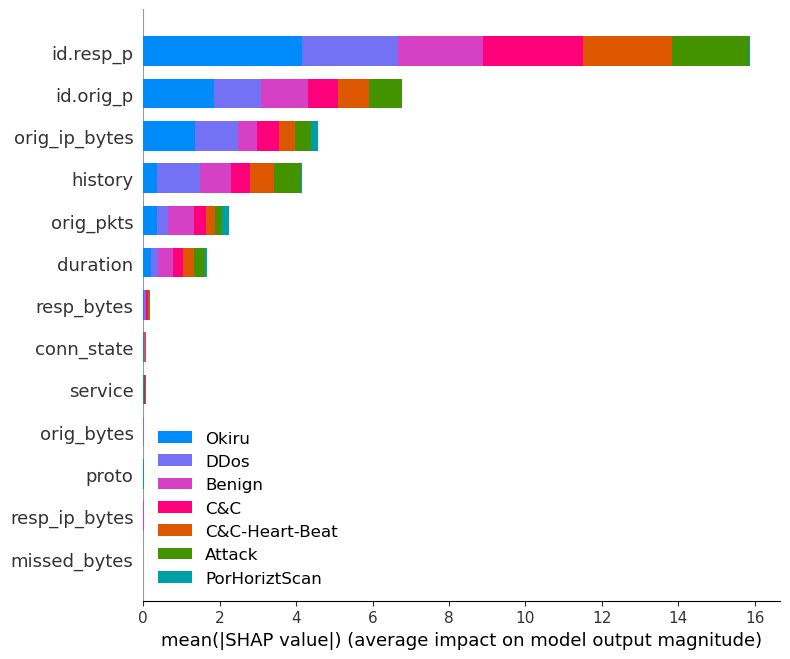

Acurácia: 0.991 +- 0.0
Precisão: 0.988 +- 0.003
Recall: 0.925 +- 0.009
F1-score: 0.946 +- 0.008
Matriz de Confusão (Média):
[[0.996 0.001 0.    0.    0.    0.    0.003]
 [0.    0.989 0.    0.    0.    0.    0.011]
 [0.    0.005 0.992 0.    0.    0.    0.004]
 [0.    0.482 0.006 0.513 0.    0.    0.   ]
 [0.    0.    0.    0.    0.999 0.    0.001]
 [0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.012 0.    0.    0.    0.    0.988]]


In [19]:
metrics, conf_matrices = catboost(X, y, balanced=0)

accuracy_mean = np.mean(metrics[0])
accuracy_std = np.std(metrics[0])
precision_mean = np.mean(metrics[1])
precision_std = np.std(metrics[1])
recall_mean = np.mean(metrics[2])
recall_std = np.std(metrics[2])
f1_score_mean = np.mean(metrics[3])
f1_score_std = np.std(metrics[3])

print(f"Acurácia: {round(accuracy_mean, 3)} +- {round(accuracy_std, 3)}")
print(f"Precisão: {round(precision_mean, 3)} +- {round(precision_std, 3)}")
print(f"Recall: {round(recall_mean, 3)} +- {round(recall_std, 3)}")
print(f"F1-score: {round(f1_score_mean, 3)} +- {round(f1_score_std, 3)}")

num_classes = 7
conf_matrices_filled = []
for conf_matrix in conf_matrices:
    conf_matrix_filled = np.zeros((num_classes, num_classes))
    conf_matrix_filled[:conf_matrix.shape[0], :conf_matrix.shape[1]] = conf_matrix
    conf_matrices_filled.append(conf_matrix_filled)

conf_matrix_mean = np.mean(conf_matrices_filled, axis=0)

class_labels = ['Attack', 'Benign', 'C&C', 'C&C-Heart-Beat', 'DDos', 'Okiru', 'PorHoriztScan']

print("Matriz de Confusão (Média):")
np.set_printoptions(precision=3, suppress=True)
print(conf_matrix_mean)

# Salvar os resultados em um arquivo pickle
results = {
    'metrics': metrics,
    'conf_matrices': conf_matrices,
    'conf_matrix_mean': conf_matrix_mean
}

with open('results_cat.pkl', 'wb') as f:
    pickle.dump(results, f)

### Carregado o arquivo pickle com o resultado da Matriz de Confusão - Média

Acurácia: 0.991 +- 0.0
Precisão: 0.988 +- 0.003
Recall: 0.925 +- 0.009
F1-score: 0.946 +- 0.008
Matriz de Confusão (Média):
[[0.996 0.001 0.    0.    0.    0.    0.003]
 [0.    0.989 0.    0.    0.    0.    0.011]
 [0.    0.005 0.992 0.    0.    0.    0.004]
 [0.    0.482 0.006 0.513 0.    0.    0.   ]
 [0.    0.    0.    0.    0.999 0.    0.001]
 [0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.012 0.    0.    0.    0.    0.988]]


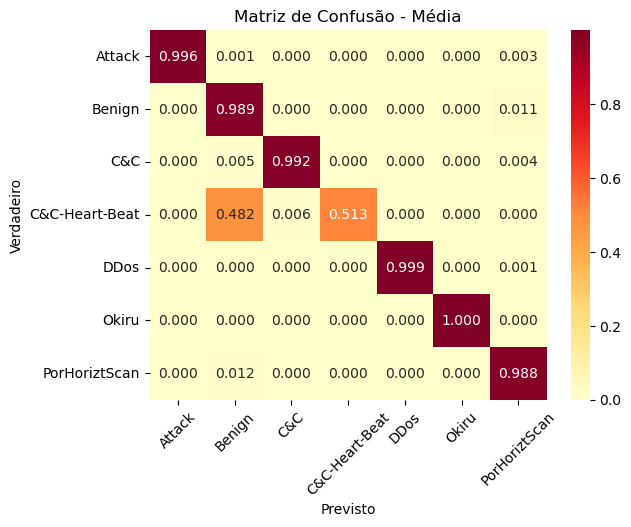

In [21]:
# Carregar os resultados do arquivo pickle
with open('results_cat.pkl', 'rb') as f:
    results = pickle.load(f)

metrics = results['metrics']
conf_matrices = results['conf_matrices']
conf_matrix_mean = results['conf_matrix_mean']

# Acessar os resultados
# imprimir a média e o desvio padrão das métricas
accuracy_mean = np.mean(metrics[0])
accuracy_std = np.std(metrics[0])
precision_mean = np.mean(metrics[1])
precision_std = np.std(metrics[1])
recall_mean = np.mean(metrics[2])
recall_std = np.std(metrics[2])
f1_score_mean = np.mean(metrics[3])
f1_score_std = np.std(metrics[3])

print(f"Acurácia: {round(accuracy_mean, 3)} +- {round(accuracy_std, 3)}")
print(f"Precisão: {round(precision_mean, 3)} +- {round(precision_std, 3)}")
print(f"Recall: {round(recall_mean, 3)} +- {round(recall_std, 3)}")
print(f"F1-score: {round(f1_score_mean, 3)} +- {round(f1_score_std, 3)}")

print("Matriz de Confusão (Média):")
np.set_printoptions(precision=3, suppress=True)
print(conf_matrix_mean)

ax = sns.heatmap(conf_matrix_mean, annot=True, cmap="YlOrRd", fmt=".3f", 
                 xticklabels=class_labels, yticklabels=class_labels, cbar=True)
ax.set_xticklabels(class_labels, rotation=45)
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão - Média")
plt.show()